In [1]:
%matplotlib inline

In [2]:
%run notebook_setup

# Astrometric fitting

In this tutorial we'll walk through the simplest astrometric example with `exoplanet` and then explain how to build up a more complicated example with parallax measurements. For our dataset, we'll use astrometric and radial velocity observations of a binary star system.

Astrometric observations usually consist of measurements of the separation and position angle of the secondary star (or directly imaged exoplanet), relative to the primary star as a function of time. The simplest astrometric orbit (in terms of number of parameters), describes the orbit using a semi-major axis `a_ang` measured in *arcseconds*, since the distance to the system is assumed to be unknown. We'll work through this example first, then introduce the extra constraints provided by parallax information.

## Data
First, let's load and examine the data. We'll use the astrometric measurements of HR 466 (HD 10009) as compiled by [Pourbaix 1998](https://ui.adsabs.harvard.edu/#abs/1998A&AS..131..377P/abstract). The speckle observations are originally from [Hartkopf et al. 1996](https://ui.adsabs.harvard.edu/#abs/1996AJ....111..370H/abstract).

In [3]:
from astropy.io import ascii
from astropy.time import Time

# grab the formatted data and do some munging
dirname = "https://gist.github.com/iancze/262aba2429cb9aee3fd5b5e1a4582d4d/raw/c5fa5bc39fec90d2cc2e736eed479099e3e598e3/"

astro_data_full = ascii.read(
    dirname + "astro.txt", format="csv", fill_values=[(".", "0")]
)

# convert UT date to JD
astro_dates = Time(astro_data_full["date"].data, format="decimalyear")

# Following the Pourbaix et al. 1998 analysis, we'll limit ourselves to the highest quality data
# since the raw collection of data outside of these ranges has some ambiguities in swapping
# the primary and secondary star
ind = (
    (astro_dates.value > 1975.0)
    & (astro_dates.value < 1999.73)
    & (~astro_data_full["rho"].mask)
    & (~astro_data_full["PA"].mask)
)

astro_data = astro_data_full[ind]

astro_yrs = astro_data["date"]
astro_dates.format = "jd"
astro_jds = astro_dates[ind].value

Many of these measurements in this heterogeneous dataset do not have reported error measurements. For these, we assume a modest uncertainty of $1^\circ$ in position angle and $0.01^{\prime\prime}$ in separation for the sake of specifying something, but we'll include a jitter term for both of these measurements as well. The scatter in points around the final solution will be a decent guide of what the measurement uncertainties actually were.

In [4]:
import numpy as np

astro_data["rho_err"][astro_data["rho_err"].mask == True] = 0.01
astro_data["PA_err"][astro_data["PA_err"].mask == True] = 1.0

# Convert all masked frames to be raw np arrays, since theano has issues with astropy masked columns
rho_data = np.ascontiguousarray(astro_data["rho"], dtype=float)  # arcsec
rho_err = np.ascontiguousarray(astro_data["rho_err"], dtype=float)

# The position angle measurements come in degrees in the range [0, 360].
# We'll convert this to radians in the range [-pi, pi]
deg = np.pi / 180.0
theta_data = np.ascontiguousarray(astro_data["PA"] * deg, dtype=float)
theta_data[theta_data > np.pi] -= 2 * np.pi

theta_err = np.ascontiguousarray(astro_data["PA_err"] * deg)  # radians

## Astrometric conventions

The conventions describing the orientation of the orbits are described in detail in the *exoplanet* paper; we summarize them briefly here. Generally, we follow the conventions from Pourbaix et al. 1998, which are a consistent set conforming to the right-hand-rule and the conventions of the visual binary field, where the ascending node is that where the secondary is *receeding* from the observer (without radial velocity information, there is a $\pi$ degeneracy in which node is ascending, and so common practice in the literature is to report a value in the range $[0,\pi]$). The orbital inclination ranges from $[0, \pi$]. $i = 0$ describes a face-on orbit rotating counter-clockwise on the sky plane, while $i=\pi$ describes a face-on orbit rotating clockwise on the sky. $i = \pi/2$ is an edge-on orbit.

The observer frame $X$, $Y$, $Z$ is oriented on the sky such that $+Z$ points towards the observer, $X$ is the north axis, and $Y$ is the east axis. *All* angles are measured in radians, and the position angle is returned in the range $[-\pi, \pi]$, which is the degrees east of north (be sure to check your data is in this format too!) The radial velocity is still defined such that a positive radial velocity corresponds to motion away from the observer.

In an astrometric-only orbit, it is common practice in the field to report $\omega = \omega_\mathrm{secondary}$, whereas with an RV orbit it is generally common practice to report $\omega = \omega_\mathrm{primary}$. The result is that unless the authors specify what they're using, in a joint astrometric-RV orbit there is an ambiguity to which $\omega$ the authors mean, since $\omega_\mathrm{primary} = \omega_\mathrm{secondary} + \pi$. To standardize this across the *exoplanet* package, in all orbits (including astrometric-only) $\omega = \omega_\mathrm{primary}$.

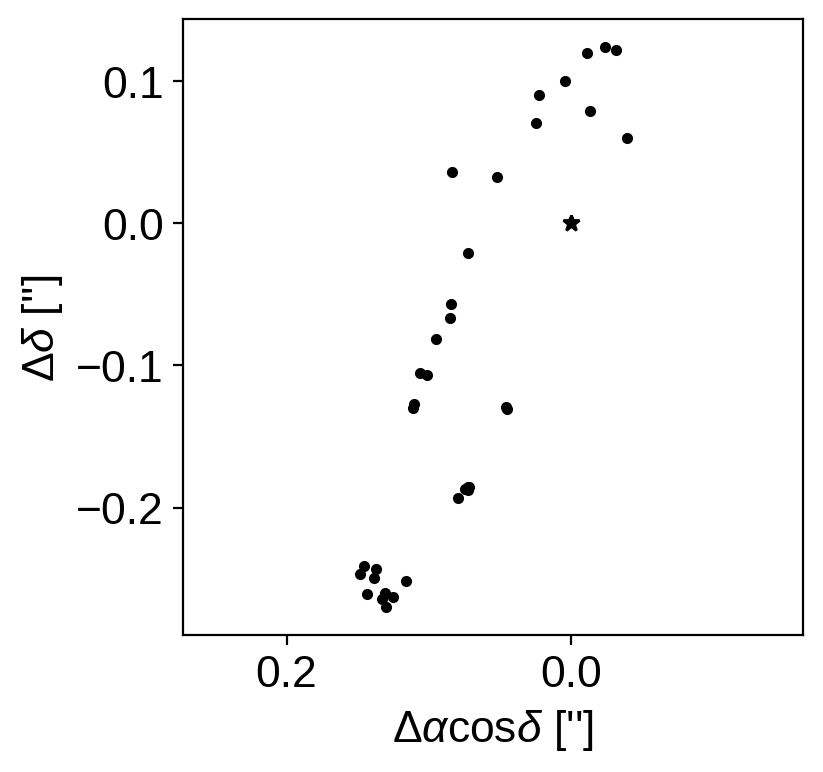

In [5]:
import matplotlib.pyplot as plt

# Make a plot of the astrometric data on the sky
# The convention is that North is up and East is left
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")
ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")

The plot on the sky is helpful to look at, but the "raw" measurements are the values of $\rho$ (separation) and $\theta$ (also called P.A., position angle) that we listed in our data table, and that the measurement uncertainties live on these values as nice Gaussians. So, to visualize this space more clearly, we can plot $\rho$ vs. time and P.A. vs. time.

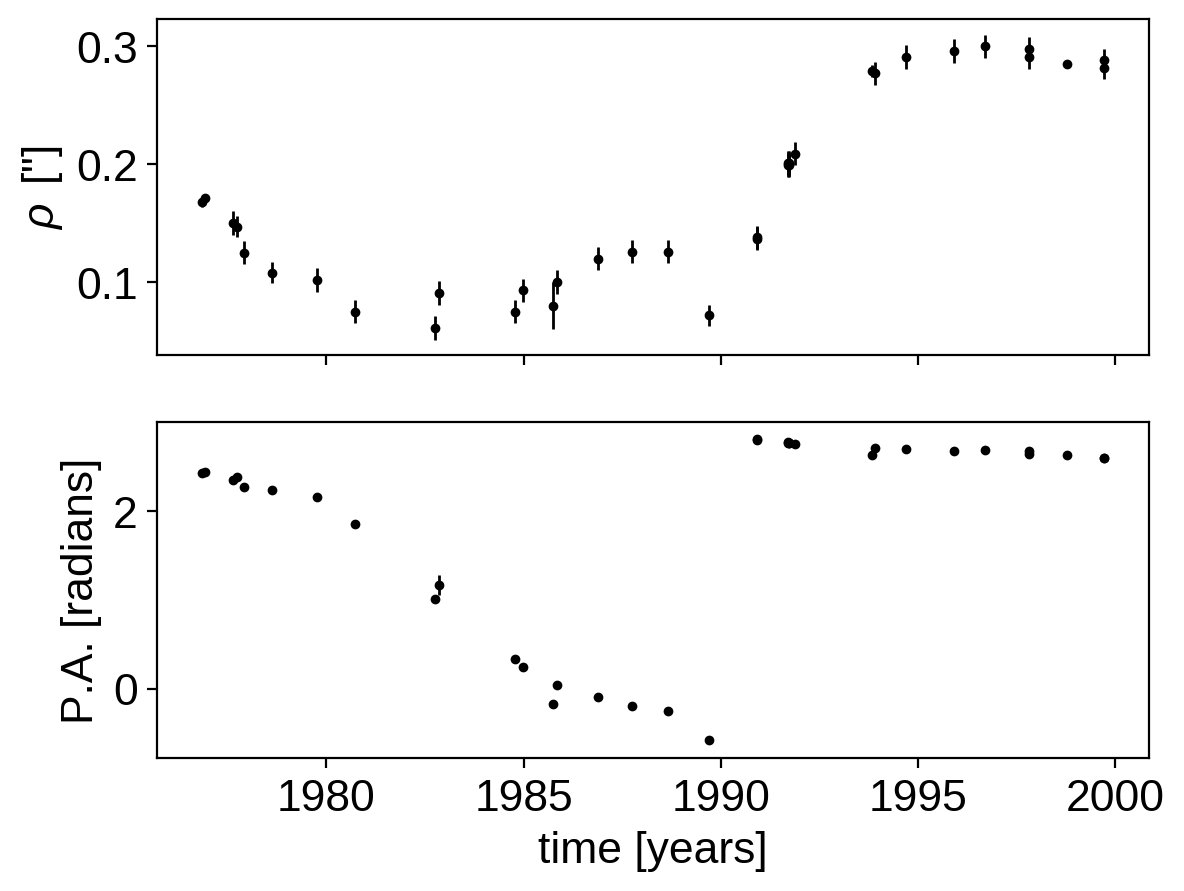

In [6]:
fig, ax = plt.subplots(nrows=2, sharex=True)
ax[0].errorbar(astro_yrs, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].set_ylabel(r'$\rho\,$ ["]')

ax[1].errorbar(astro_yrs, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [years]")

## Fitting the astrometric orbit with *exoplanet*

To get started, let's import the relative packages from *exoplanet*, plot up a preliminary orbit from the literature, and then sample to find the best parameters.

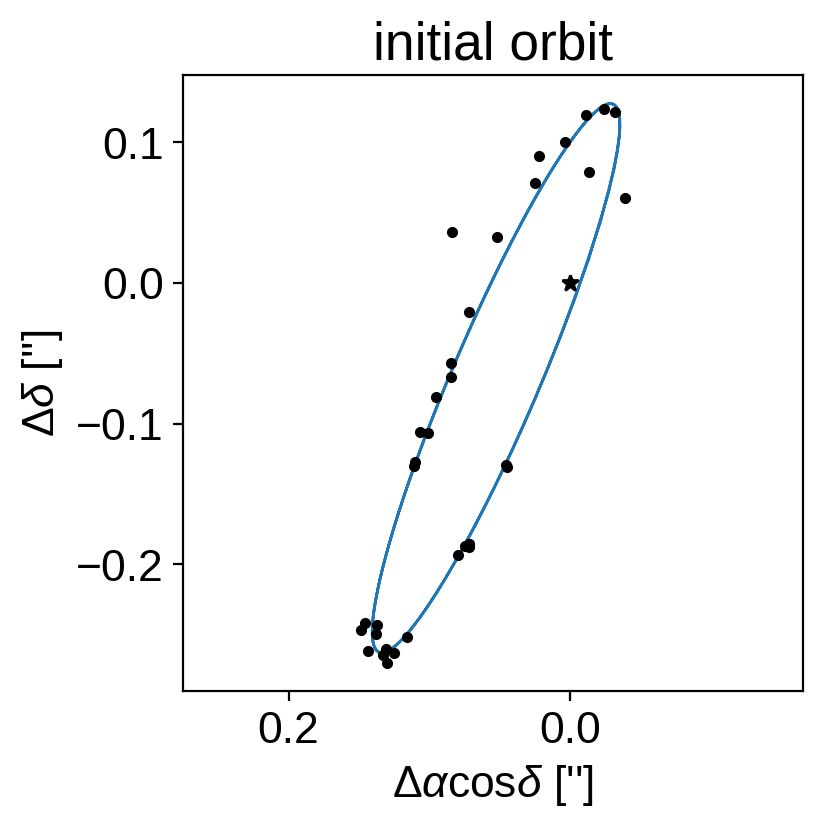

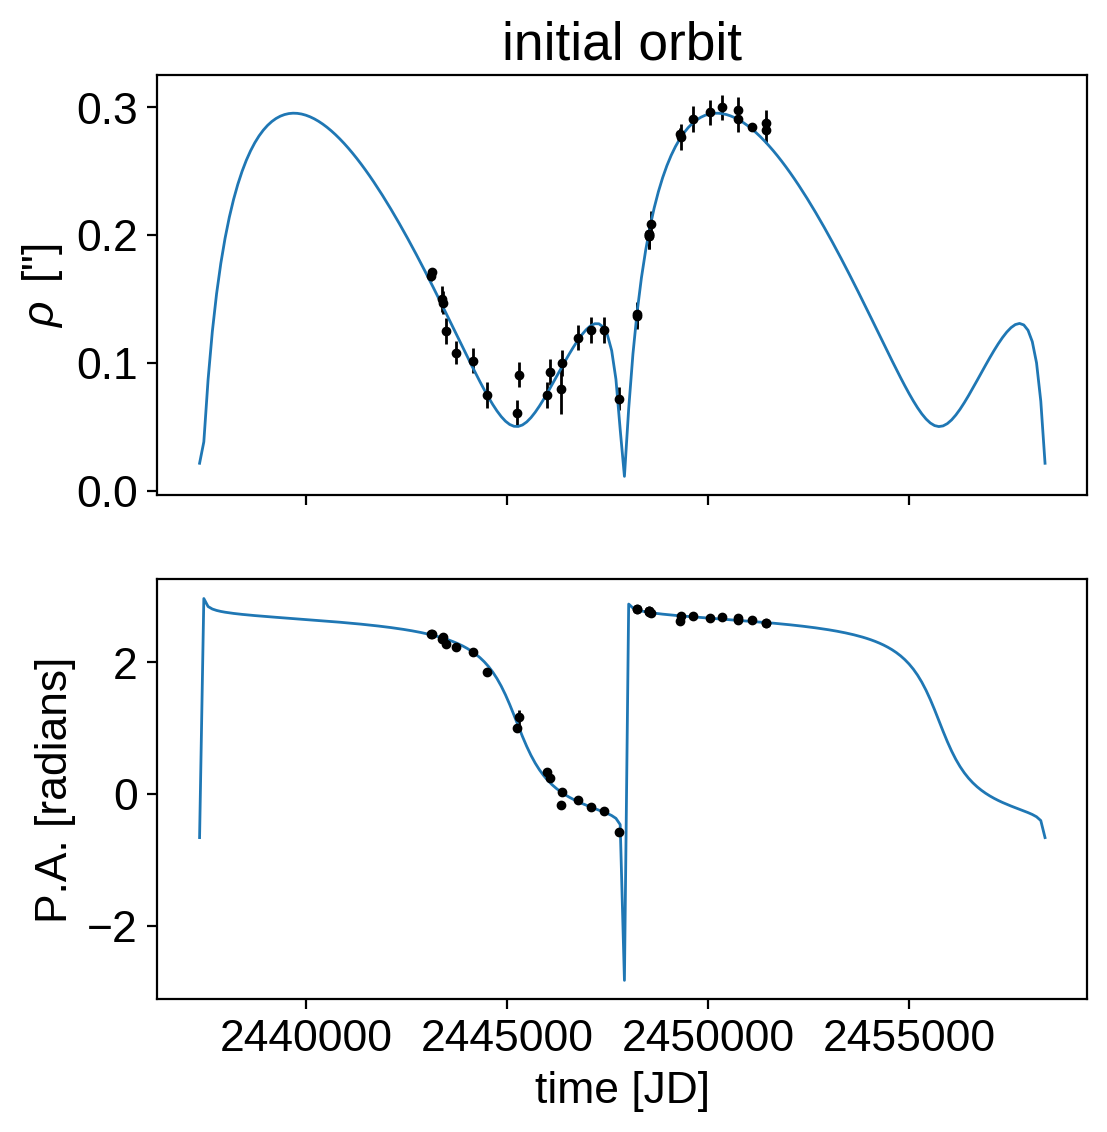

In [7]:
import pymc3 as pm
import theano
import theano.tensor as tt

import exoplanet as xo
from exoplanet.distributions import Angle

from astropy import constants

# conversion constant from au to R_sun
au_to_R_sun = (constants.au / constants.R_sun).value

# Just to get started, let's take a look at the orbit using the best-fit parameters from Pourbaix et al. 1998

# Orbital elements from Pourbaix et al. 1998
# For the relative astrometric fit, we only need the following parameters
a_ang = 0.324  # arcsec
parallax = 1  # arcsec (meaningless choice for now)
a = a_ang * au_to_R_sun / parallax
e = 0.798
i = 96.0 * deg  # [rad]
omega = 251.6 * deg - np.pi  # Pourbaix reports omega_2, but we want omega_1
Omega = 159.6 * deg
P = 28.8 * 365.25  # days

T0 = Time(1989.92, format="decimalyear")
T0.format = "jd"
T0 = T0.value  # [Julian Date]

# instantiate the orbit
orbit = xo.orbits.KeplerianOrbit(
    a=a, t_periastron=T0, period=P, incl=i, ecc=e, omega=omega, Omega=Omega
)

# The position functions take an optional argument parallax to convert from
# physical units back to arcseconds
t = np.linspace(T0 - P, T0 + P, num=200)  # days
rho, theta = theano.function([], orbit.get_relative_angles(t, parallax))()

# Plot the orbit
fig, ax = plt.subplots(nrows=1, figsize=(4, 4))

xs = rho * np.cos(theta)  # X is north
ys = rho * np.sin(theta)  # Y is east
ax.plot(ys, xs, color="C0", lw=1)

# plot the data
xs = rho_data * np.cos(theta_data)  # X is north
ys = rho_data * np.sin(theta_data)  # Y is east
ax.plot(ys, xs, ".k")

ax.set_ylabel(r"$\Delta \delta$ ['']")
ax.set_xlabel(r"$\Delta \alpha \cos \delta$ ['']")
ax.invert_xaxis()
ax.plot(0, 0, "k*")
ax.set_aspect("equal", "datalim")
ax.set_title("initial orbit")

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].errorbar(astro_jds, rho_data, yerr=rho_err, fmt=".k", lw=1, ms=5)
ax[0].plot(t, rho, color="C0", lw=1)
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[0].set_title("initial orbit")

ax[1].errorbar(astro_jds, theta_data, yerr=theta_err, fmt=".k", lw=1, ms=5)
ax[1].plot(t, theta, color="C0", lw=1)
ax[1].set_ylabel(r"P.A. [radians]")
_ = ax[1].set_xlabel("time [JD]")

Now that we have an initial orbit, we can set the model up using PyMC3 to do inference.

In [8]:
yr = 365.25

# for predicted orbits
t_fine = np.linspace(astro_jds.min() - 500, astro_jds.max() + 500, num=1000)


def get_model(parallax=None):
    with pm.Model() as model:

        if parallax is None:
            # Without an actual parallax measurement, we can model the orbit in units of arcseconds
            # by providing a fake_parallax and conversion constant
            plx = 1  # arcsec
        else:
            # Below we will run a version of this model where a measurement of parallax is provided
            # The measurement is in milliarcsec
            m_plx = pm.Bound(pm.Normal, lower=0, upper=100)(
                "m_plx", mu=parallax[0], sd=parallax[1], testval=parallax[0]
            )
            plx = pm.Deterministic("plx", 1e-3 * m_plx)

        a_ang = pm.Uniform("a_ang", 0.1, 1.0, testval=0.324)
        a = pm.Deterministic("a", a_ang / plx)

        # We expect the period to be somewhere in the range of 25 years,
        # so we'll set a broad prior on logP
        logP = pm.Normal(
            "logP", mu=np.log(25 * yr), sd=10.0, testval=np.log(28.8 * yr)
        )
        P = pm.Deterministic("P", tt.exp(logP))

        # For astrometric-only fits, it's generally better to fit in
        # p = (Omega + omega)/2 and m = (Omega - omega)/2 instead of omega and Omega
        # directly
        omega0 = 251.6 * deg - np.pi
        Omega0 = 159.6 * deg
        p = Angle("p", testval=0.5 * (Omega0 + omega0))
        m = Angle("m", testval=0.5 * (Omega0 - omega0))
        omega = pm.Deterministic("omega", p - m)
        Omega = pm.Deterministic("Omega", p + m)

        # For these orbits, it can also be better to fit for a phase angle
        # (relative to a reference time) instead of the time of periasteron
        # passage directly
        phase = Angle("phase", testval=0.0)
        tperi = pm.Deterministic("tperi", T0 + P * phase / (2 * np.pi))

        # Geometric uiform prior on cos(incl)
        cos_incl = pm.Uniform(
            "cos_incl", lower=-1, upper=1, testval=np.cos(96.0 * deg)
        )
        incl = pm.Deterministic("incl", tt.arccos(cos_incl))
        ecc = pm.Uniform("ecc", lower=0.0, upper=1.0, testval=0.798)

        # Set up the orbit
        orbit = xo.orbits.KeplerianOrbit(
            a=a * au_to_R_sun,
            t_periastron=tperi,
            period=P,
            incl=incl,
            ecc=ecc,
            omega=omega,
            Omega=Omega,
        )
        if parallax is not None:
            pm.Deterministic("M_tot", orbit.m_total)

        # Compute the model in rho and theta
        rho_model, theta_model = orbit.get_relative_angles(astro_jds, plx)
        pm.Deterministic("rho_model", rho_model)
        pm.Deterministic("theta_model", theta_model)

        # Add jitter terms to both separation and position angle
        log_rho_s = pm.Normal(
            "log_rho_s", mu=np.log(np.median(rho_err)), sd=5.0
        )
        log_theta_s = pm.Normal(
            "log_theta_s", mu=np.log(np.median(theta_err)), sd=5.0
        )
        rho_tot_err = tt.sqrt(rho_err ** 2 + tt.exp(2 * log_rho_s))
        theta_tot_err = tt.sqrt(theta_err ** 2 + tt.exp(2 * log_theta_s))

        # define the likelihood function, e.g., a Gaussian on both rho and theta
        pm.Normal("rho_obs", mu=rho_model, sd=rho_tot_err, observed=rho_data)

        # We want to be cognizant of the fact that theta wraps so the following is equivalent to
        # pm.Normal("obs_theta", mu=theta_model, observed=theta_data, sd=theta_tot_err)
        # but takes into account the wrapping. Thanks to Rob de Rosa for the tip.
        theta_diff = tt.arctan2(
            tt.sin(theta_model - theta_data), tt.cos(theta_model - theta_data)
        )
        pm.Normal("theta_obs", mu=theta_diff, sd=theta_tot_err, observed=0.0)

        # Set up predicted orbits for later plotting
        rho_dense, theta_dense = orbit.get_relative_angles(t_fine, plx)
        rho_save = pm.Deterministic("rho_save", rho_dense)
        theta_save = pm.Deterministic("theta_save", theta_dense)

        # Optimize to find the initial parameters
        map_soln = model.test_point
        map_soln = xo.optimize(map_soln, vars=[log_rho_s, log_theta_s])
        map_soln = xo.optimize(map_soln, vars=[phase])
        map_soln = xo.optimize(map_soln, vars=[p, m, ecc])
        map_soln = xo.optimize(map_soln, vars=[logP, a_ang, phase])
        map_soln = xo.optimize(map_soln)

    return model, map_soln


model, map_soln = get_model()

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.048555e+02]

1it [00:00, 496.19it/s, logp=1.048555e+02]

2it [00:00, 676.39it/s, logp=1.048555e+02]

3it [00:00, 755.55it/s, logp=1.448865e+02]

4it [00:00, 754.17it/s, logp=1.056457e+02]

5it [00:00, 615.96it/s, logp=1.457994e+02]

6it [00:00, 621.78it/s, logp=1.469999e+02]

7it [00:00, 576.33it/s, logp=1.471434e+02]

8it [00:00, 591.13it/s, logp=1.471440e+02]

9it [00:00, 591.52it/s, logp=1.471440e+02]

10it [00:00, 609.64it/s, logp=1.471440e+02]

11it [00:04,  2.47it/s, logp=1.471440e+02] 


message: Optimization terminated successfully.
logp: 104.85554109304441 -> 147.14399186005338


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.471440e+02]

1it [00:00, 471.16it/s, logp=1.471440e+02]

2it [00:00, 468.61it/s, logp=1.471440e+02]

3it [00:00, 521.49it/s, logp=-1.185831e+04]

4it [00:00, 574.48it/s, logp=1.471671e+02] 

5it [00:00, 537.76it/s, logp=1.472136e+02]

6it [00:00, 579.00it/s, logp=1.473986e+02]

7it [00:00, 612.36it/s, logp=1.481189e+02]

8it [00:00, 648.32it/s, logp=1.507231e+02]

9it [00:00, 667.95it/s, logp=1.565965e+02]

10it [00:00, 661.30it/s, logp=1.634911e+02]

11it [00:00, 670.06it/s, logp=1.666396e+02]

12it [00:00, 674.27it/s, logp=1.675455e+02]

13it [00:00, 690.14it/s, logp=1.676215e+02]

14it [00:00, 688.72it/s, logp=1.676248e+02]

15it [00:00, 682.53it/s, logp=1.676282e+02]

16it [00:00, 688.39it/s, logp=1.676337e+02]

17it [00:00, 698.45it/s, logp=1.676403e+02]

18it [00:00, 702.27it/s, logp=1.676419e+02]

19it [00:00, 711.76it/s, logp=1.676422e+02]

20it [00:00, 712.99it/s, logp=1.676422e+02]

21it [00:00, 683.84it/s, logp=1.676422e+02]

22it [00:00, 677.73it/s, logp=1.676422e+02]

23it [00:00, 25.91it/s, logp=1.676422e+02] 


message: Optimization terminated successfully.
logp: 147.14399186005338 -> 167.64220598197195


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.676422e+02]

1it [00:00, 387.18it/s, logp=1.676422e+02]

2it [00:00, 520.93it/s, logp=1.676422e+02]

3it [00:00, 572.97it/s, logp=-4.521021e+03]

4it [00:00, 614.19it/s, logp=1.682354e+02] 

5it [00:00, 633.81it/s, logp=1.667490e+02]

6it [00:00, 663.64it/s, logp=1.683674e+02]

7it [00:00, 643.61it/s, logp=1.686220e+02]

8it [00:00, 666.95it/s, logp=1.694033e+02]

9it [00:00, 677.39it/s, logp=1.714304e+02]

10it [00:00, 695.34it/s, logp=1.784310e+02]

11it [00:00, 704.43it/s, logp=1.921973e+02]

12it [00:00, 702.93it/s, logp=1.936845e+02]

13it [00:00, 700.66it/s, logp=1.964254e+02]

14it [00:00, 709.77it/s, logp=2.010939e+02]

15it [00:00, 709.46it/s, logp=2.074741e+02]

16it [00:00, 717.50it/s, logp=2.094264e+02]

17it [00:00, 720.93it/s, logp=2.098562e+02]

18it [00:00, 724.95it/s, logp=2.098999e+02]

19it [00:00, 728.77it/s, logp=2.099152e+02]

20it [00:00, 728.37it/s, logp=2.099416e+02]

21it [00:00, 729.80it/s, logp=2.099853e+02]

22it [00:00, 706.29it/s, logp=2.100398e+02]

23it [00:00, 705.28it/s, logp=2.100552e+02]

24it [00:00, 708.31it/s, logp=2.100609e+02]

25it [00:00, 712.37it/s, logp=2.100614e+02]

26it [00:00, 694.74it/s, logp=2.100617e+02]

27it [00:00, 697.65it/s, logp=2.100622e+02]

28it [00:00, 693.67it/s, logp=2.100629e+02]

29it [00:00, 695.40it/s, logp=2.100633e+02]

30it [00:00, 698.60it/s, logp=2.100634e+02]

31it [00:00, 701.99it/s, logp=2.100634e+02]

32it [00:00, 705.23it/s, logp=2.100634e+02]

33it [00:00, 708.54it/s, logp=2.100634e+02]

34it [00:00, 710.63it/s, logp=2.100634e+02]

35it [00:00, 39.03it/s, logp=2.100634e+02] 


message: Optimization terminated successfully.
logp: 167.64220598197198 -> 210.06340668297898


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.100634e+02]

1it [00:00, 436.50it/s, logp=2.100634e+02]

2it [00:00, 620.00it/s, logp=2.100634e+02]

3it [00:00, 660.90it/s, logp=-4.378171e+03]

4it [00:00, 710.66it/s, logp=2.102114e+02] 

5it [00:00, 705.42it/s, logp=2.103607e+02]

6it [00:00, 731.59it/s, logp=2.104883e+02]

7it [00:00, 746.60it/s, logp=2.105011e+02]

8it [00:00, 761.42it/s, logp=2.105011e+02]

9it [00:00, 773.62it/s, logp=2.105014e+02]

10it [00:00, 776.95it/s, logp=2.105014e+02]

11it [00:00, 771.63it/s, logp=2.105014e+02]

12it [00:01,  9.11it/s, logp=2.105014e+02] 


message: Optimization terminated successfully.
logp: 210.06340668297898 -> 210.5013698914948


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.105014e+02]

1it [00:00, 358.24it/s, logp=2.105014e+02]

2it [00:00, 513.03it/s, logp=2.105014e+02]

3it [00:00, 554.63it/s, logp=-4.041226e+03]

4it [00:00, 595.42it/s, logp=2.124628e+02] 

5it [00:00, 614.82it/s, logp=1.648448e+02]

6it [00:00, 639.88it/s, logp=2.125361e+02]

7it [00:00, 646.64it/s, logp=2.126469e+02]

8it [00:00, 658.55it/s, logp=2.128268e+02]

9it [00:00, 664.88it/s, logp=2.130889e+02]

10it [00:00, 665.54it/s, logp=2.132127e+02]

11it [00:00, 670.18it/s, logp=2.131910e+02]

12it [00:00, 682.07it/s, logp=2.132712e+02]

13it [00:00, 682.83it/s, logp=2.133790e+02]

14it [00:00, 685.01it/s, logp=2.135772e+02]

15it [00:00, 687.96it/s, logp=2.139432e+02]

16it [00:00, 681.90it/s, logp=2.145105e+02]

17it [00:00, 683.61it/s, logp=2.146599e+02]

18it [00:00, 638.21it/s, logp=2.148474e+02]

19it [00:00, 636.77it/s, logp=2.149170e+02]

20it [00:00, 640.67it/s, logp=2.149377e+02]

21it [00:00, 643.33it/s, logp=2.149628e+02]

22it [00:00, 635.61it/s, logp=2.149864e+02]

23it [00:00, 638.68it/s, logp=2.150041e+02]

24it [00:00, 641.45it/s, logp=2.150108e+02]

25it [00:00, 637.62it/s, logp=2.150182e+02]

26it [00:00, 641.59it/s, logp=2.150205e+02]

27it [00:00, 644.05it/s, logp=2.150210e+02]

28it [00:00, 645.09it/s, logp=2.150212e+02]

29it [00:00, 646.95it/s, logp=2.150212e+02]

30it [00:00, 647.91it/s, logp=2.150212e+02]

31it [00:00, 650.04it/s, logp=2.150212e+02]

32it [00:00, 647.98it/s, logp=2.150212e+02]

33it [00:00, 650.67it/s, logp=2.150212e+02]

34it [00:00, 653.08it/s, logp=2.150212e+02]

35it [00:00, 654.99it/s, logp=2.150212e+02]

36it [00:00, 39.86it/s, logp=2.150212e+02] 


message: Optimization terminated successfully.
logp: 210.50136989149482 -> 215.021177422118


Now that we have a maximum a posteriori estimate of the parameters, let's take a look at the results to make sure that they seem reasonable.

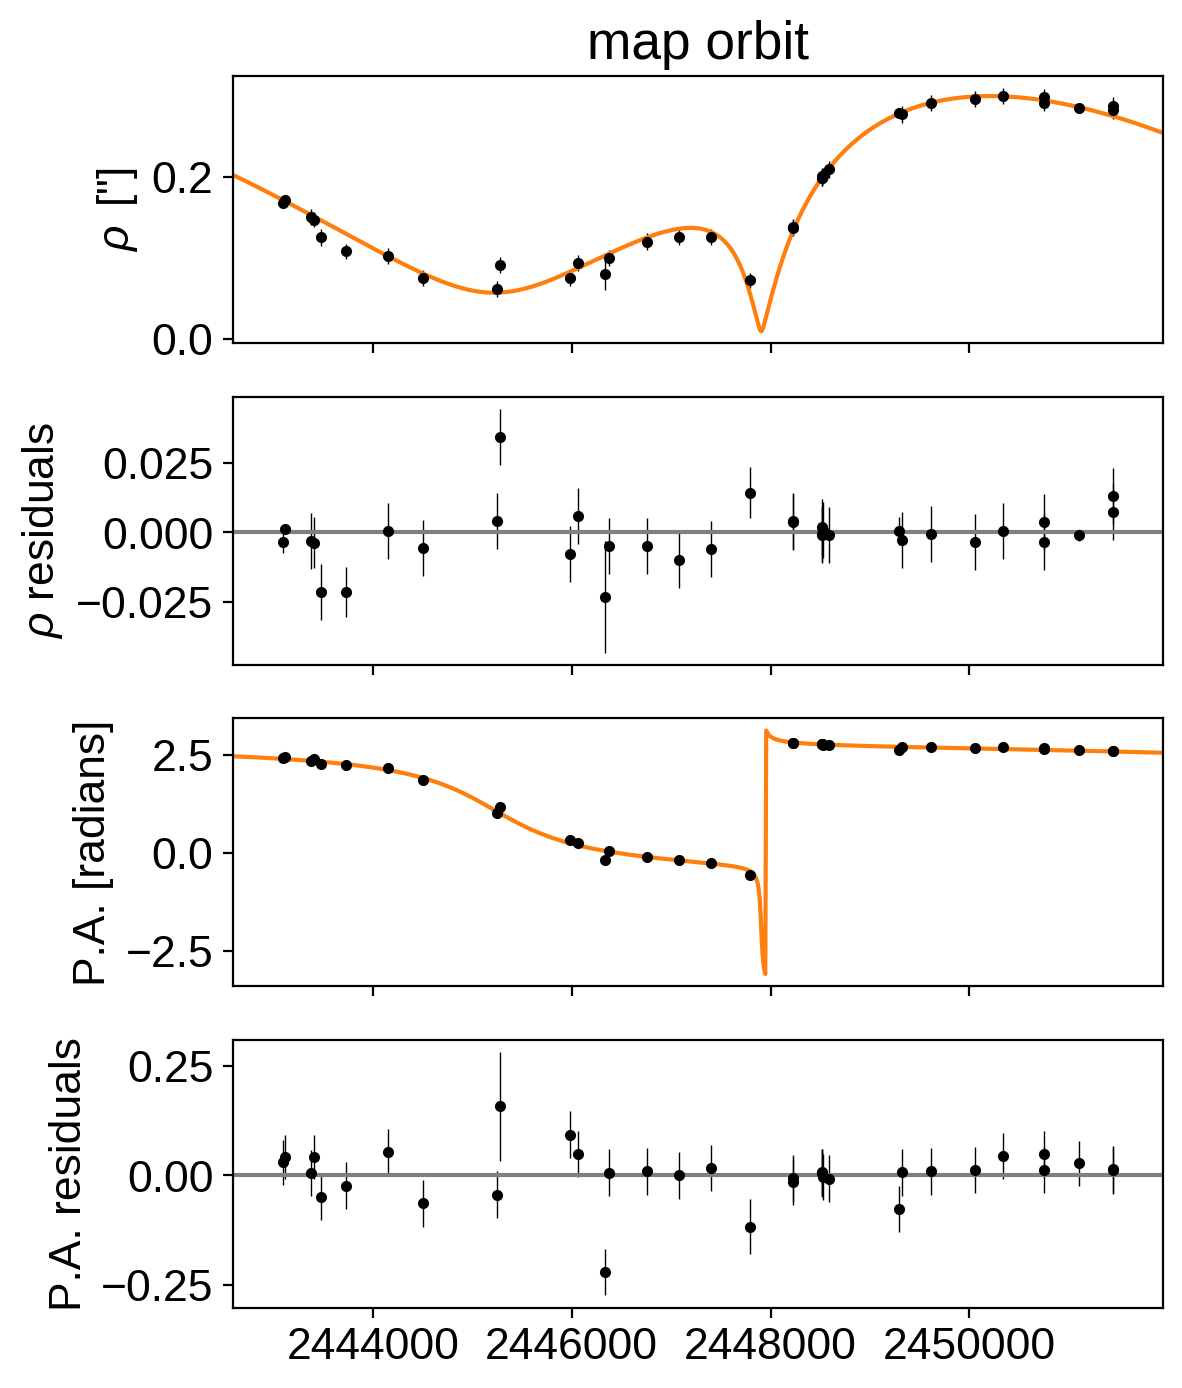

In [9]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(6, 8))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"$\rho$ residuals")
ax[2].set_ylabel(r"P.A. [radians]")
ax[3].set_ylabel(r"P.A. residuals")

tot_rho_err = np.sqrt(rho_err ** 2 + np.exp(2 * map_soln["log_rho_s"]))
tot_theta_err = np.sqrt(theta_err ** 2 + np.exp(2 * map_soln["log_theta_s"]))

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
ax[0].plot(t_fine, map_soln["rho_save"], "C1")

ax[1].axhline(0.0, color="0.5")
ax[1].errorbar(
    astro_jds, rho_data - map_soln["rho_model"], yerr=tot_rho_err, **ekw
)


ax[2].plot(t_fine, map_soln["theta_save"], "C1")
ax[2].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)

ax[3].axhline(0.0, color="0.5")
ax[3].errorbar(
    astro_jds, theta_data - map_soln["theta_model"], yerr=tot_theta_err, **ekw
)

ax[3].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("map orbit")

Now let's sample the posterior.

In [10]:
np.random.seed(1234)
with model:
    trace = pm.sample(
        tune=5000,
        draws=4000,
        start=map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9, adaptation_window=201),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang]


Sampling 2 chains, 0 divergences:   0%|          | 0/18000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 7/18000 [00:00<06:07, 48.99draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/18000 [00:00<09:30, 31.52draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/18000 [00:00<12:38, 23.72draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/18000 [00:00<14:49, 20.22draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/18000 [00:00<16:25, 18.24draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/18000 [00:00<17:33, 17.07draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/18000 [00:00<18:17, 16.38draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 22/18000 [00:01<16:51, 17.77draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 24/18000 [00:01<18:00, 16.63draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 26/18000 [00:01<18:56, 15.81draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 28/18000 [00:01<20:02, 14.95draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 30/18000 [00:01<19:53, 15.06draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 32/18000 [00:01<19:53, 15.05draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 35/18000 [00:01<17:51, 16.77draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 37/18000 [00:02<18:26, 16.23draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 39/18000 [00:02<18:45, 15.96draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 41/18000 [00:02<19:08, 15.64draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 44/18000 [00:02<17:13, 17.37draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 46/18000 [00:02<17:54, 16.71draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 48/18000 [00:02<18:26, 16.22draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 50/18000 [00:02<18:51, 15.86draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 52/18000 [00:02<19:08, 15.63draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 54/18000 [00:03<19:26, 15.39draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 56/18000 [00:03<20:57, 14.26draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 58/18000 [00:03<20:50, 14.35draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 60/18000 [00:03<20:35, 14.52draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 62/18000 [00:03<20:24, 14.65draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 64/18000 [00:03<20:06, 14.86draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 66/18000 [00:03<20:03, 14.91draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 69/18000 [00:04<18:02, 16.57draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 71/18000 [00:04<17:40, 16.91draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 73/18000 [00:04<18:31, 16.13draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 75/18000 [00:04<18:59, 15.73draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 77/18000 [00:04<19:25, 15.38draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 79/18000 [00:04<19:35, 15.24draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 81/18000 [00:04<19:42, 15.16draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 84/18000 [00:04<17:43, 16.84draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 86/18000 [00:05<18:49, 15.85draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 89/18000 [00:05<18:28, 16.16draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 91/18000 [00:05<18:49, 15.85draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 94/18000 [00:05<18:20, 16.27draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 98/18000 [00:05<15:10, 19.67draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 101/18000 [00:05<16:07, 18.50draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 104/18000 [00:06<15:21, 19.41draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 107/18000 [00:06<14:19, 20.82draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 111/18000 [00:06<14:41, 20.29draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 114/18000 [00:06<14:37, 20.38draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 117/18000 [00:06<17:59, 16.57draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 119/18000 [00:06<18:27, 16.14draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 121/18000 [00:07<18:47, 15.86draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 123/18000 [00:07<19:04, 15.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 126/18000 [00:07<17:14, 17.28draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 129/18000 [00:07<15:37, 19.06draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 134/18000 [00:07<13:06, 22.71draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 138/18000 [00:07<12:31, 23.76draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 141/18000 [00:07<12:53, 23.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 147/18000 [00:07<10:54, 27.27draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 151/18000 [00:08<11:15, 26.44draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 154/18000 [00:08<11:45, 25.29draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 158/18000 [00:08<10:35, 28.07draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 162/18000 [00:08<12:46, 23.26draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 165/18000 [00:08<13:31, 21.98draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 169/18000 [00:08<12:56, 22.97draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 172/18000 [00:09<15:03, 19.72draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 175/18000 [00:09<13:40, 21.72draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 178/18000 [00:09<15:54, 18.67draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 181/18000 [00:09<15:35, 19.05draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 184/18000 [00:09<18:41, 15.89draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 186/18000 [00:09<18:56, 15.67draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 189/18000 [00:10<17:12, 17.26draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 191/18000 [00:10<17:48, 16.67draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 193/18000 [00:10<18:10, 16.32draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 197/18000 [00:10<16:42, 17.75draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 199/18000 [00:10<18:10, 16.33draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 202/18000 [00:10<17:49, 16.64draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 206/18000 [00:10<16:08, 18.37draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 209/18000 [00:11<14:42, 20.16draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 212/18000 [00:11<13:41, 21.66draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 215/18000 [00:11<13:12, 22.43draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 218/18000 [00:11<14:11, 20.87draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 222/18000 [00:11<12:12, 24.28draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 225/18000 [00:11<14:10, 20.91draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 228/18000 [00:11<15:13, 19.45draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 231/18000 [00:12<17:34, 16.85draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 233/18000 [00:12<18:10, 16.29draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 237/18000 [00:12<17:06, 17.31draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 239/18000 [00:12<17:44, 16.69draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 241/18000 [00:12<17:19, 17.08draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 244/18000 [00:12<15:22, 19.24draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 247/18000 [00:13<14:50, 19.93draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 250/18000 [00:13<14:17, 20.71draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 253/18000 [00:13<16:23, 18.04draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 256/18000 [00:13<14:49, 19.94draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 259/18000 [00:13<16:12, 18.25draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 263/18000 [00:13<15:06, 19.57draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 266/18000 [00:14<15:08, 19.52draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 269/18000 [00:14<16:25, 17.99draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 271/18000 [00:14<17:17, 17.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 273/18000 [00:14<17:49, 16.58draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 276/18000 [00:14<16:18, 18.11draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 278/18000 [00:14<17:07, 17.25draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 280/18000 [00:14<17:44, 16.65draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 283/18000 [00:15<16:24, 18.00draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 287/18000 [00:15<15:15, 19.35draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 291/18000 [00:15<13:01, 22.65draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 294/18000 [00:15<13:20, 22.11draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 297/18000 [00:15<14:05, 20.94draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 300/18000 [00:15<13:46, 21.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 303/18000 [00:15<13:04, 22.55draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 309/18000 [00:15<10:39, 27.66draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 314/18000 [00:16<10:26, 28.25draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 318/18000 [00:16<10:38, 27.71draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 322/18000 [00:16<10:07, 29.12draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 326/18000 [00:16<11:25, 25.78draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 329/18000 [00:16<14:46, 19.93draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 332/18000 [00:16<15:25, 19.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 335/18000 [00:17<17:14, 17.08draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 338/18000 [00:17<16:35, 17.75draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 340/18000 [00:17<17:38, 16.68draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 343/18000 [00:17<16:35, 17.74draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 345/18000 [00:17<16:08, 18.23draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 348/18000 [00:17<14:33, 20.20draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 351/18000 [00:17<14:03, 20.93draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 354/18000 [00:18<16:28, 17.84draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 356/18000 [00:18<16:11, 18.16draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 358/18000 [00:18<18:03, 16.28draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 360/18000 [00:18<18:24, 15.97draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 363/18000 [00:18<16:48, 17.49draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 365/18000 [00:18<17:35, 16.71draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 368/18000 [00:18<16:14, 18.09draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 371/18000 [00:19<16:35, 17.72draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 373/18000 [00:19<17:15, 17.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 377/18000 [00:19<14:27, 20.32draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 380/18000 [00:19<13:08, 22.34draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 383/18000 [00:19<13:07, 22.37draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 386/18000 [00:19<15:14, 19.27draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 390/18000 [00:19<13:18, 22.06draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 393/18000 [00:20<13:01, 22.52draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 398/18000 [00:20<10:52, 26.96draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 404/18000 [00:20<09:07, 32.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 411/18000 [00:20<07:57, 36.86draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 417/18000 [00:20<07:07, 41.18draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 424/18000 [00:20<06:14, 46.93draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 432/18000 [00:20<05:27, 53.58draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 447/18000 [00:20<04:25, 66.08draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 461/18000 [00:20<03:43, 78.47draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 472/18000 [00:21<03:54, 74.75draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 484/18000 [00:21<03:29, 83.41draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 496/18000 [00:21<03:13, 90.50draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 507/18000 [00:21<03:13, 90.63draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 518/18000 [00:21<03:04, 94.79draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 531/18000 [00:21<02:51, 101.92draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 542/18000 [00:21<02:47, 104.12draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 553/18000 [00:21<03:14, 89.72draws/s] 

Sampling 2 chains, 0 divergences:   3%|▎         | 563/18000 [00:22<03:14, 89.65draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 574/18000 [00:22<03:03, 94.85draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 584/18000 [00:22<03:05, 93.70draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 596/18000 [00:22<02:55, 98.93draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 609/18000 [00:22<02:46, 104.20draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 620/18000 [00:22<03:05, 93.85draws/s] 

Sampling 2 chains, 0 divergences:   4%|▎         | 630/18000 [00:22<03:24, 85.13draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 639/18000 [00:22<03:36, 80.28draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 648/18000 [00:22<03:46, 76.69draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 656/18000 [00:23<03:46, 76.51draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 665/18000 [00:23<03:38, 79.17draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 679/18000 [00:23<03:11, 90.37draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 689/18000 [00:23<03:17, 87.46draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 700/18000 [00:23<03:05, 93.09draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 710/18000 [00:23<03:02, 94.85draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 726/18000 [00:23<02:40, 107.44draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 747/18000 [00:23<02:18, 124.53draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 765/18000 [00:23<02:07, 135.07draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 785/18000 [00:24<01:55, 149.64draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 802/18000 [00:24<01:59, 144.04draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 818/18000 [00:24<02:05, 137.21draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 835/18000 [00:24<01:58, 145.26draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 851/18000 [00:24<01:58, 144.21draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 866/18000 [00:24<02:04, 137.49draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 881/18000 [00:24<02:06, 135.03draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 895/18000 [00:24<02:06, 135.41draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 912/18000 [00:24<01:59, 143.15draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 933/18000 [00:25<01:48, 156.67draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 950/18000 [00:25<01:49, 155.74draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 969/18000 [00:25<01:43, 163.80draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 987/18000 [00:25<01:42, 166.50draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1004/18000 [00:25<01:46, 159.25draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1021/18000 [00:25<01:46, 159.27draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1038/18000 [00:25<01:51, 151.56draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1054/18000 [00:25<01:54, 148.23draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1069/18000 [00:25<01:59, 142.03draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1084/18000 [00:26<02:06, 133.34draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1103/18000 [00:26<01:57, 144.05draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1118/18000 [00:26<02:07, 132.28draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1132/18000 [00:26<02:06, 133.79draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1147/18000 [00:26<02:06, 133.09draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1161/18000 [00:26<02:10, 128.71draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1175/18000 [00:26<02:08, 130.88draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1196/18000 [00:26<01:55, 145.87draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1214/18000 [00:26<01:49, 153.35draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1230/18000 [00:27<01:57, 142.71draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1246/18000 [00:27<01:53, 147.32draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1263/18000 [00:27<01:51, 150.67draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1279/18000 [00:27<01:50, 151.33draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1295/18000 [00:27<01:55, 144.33draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1310/18000 [00:27<02:04, 133.66draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1327/18000 [00:27<01:58, 140.50draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1348/18000 [00:27<01:47, 155.02draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1365/18000 [00:27<01:44, 158.86draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1382/18000 [00:28<02:00, 138.19draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1397/18000 [00:28<02:04, 133.53draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1414/18000 [00:28<01:58, 140.24draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1431/18000 [00:28<01:56, 142.73draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1446/18000 [00:28<02:07, 129.51draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1460/18000 [00:28<02:05, 131.63draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1480/18000 [00:28<01:53, 145.30draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1500/18000 [00:28<01:45, 156.52draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1517/18000 [00:29<01:45, 156.46draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1534/18000 [00:29<01:43, 159.70draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1551/18000 [00:29<01:41, 161.47draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1570/18000 [00:29<01:39, 164.88draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1587/18000 [00:29<01:43, 158.88draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1604/18000 [00:29<01:51, 147.03draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1623/18000 [00:29<01:45, 154.56draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1639/18000 [00:29<01:48, 150.38draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1657/18000 [00:29<01:43, 157.18draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1678/18000 [00:30<01:36, 169.25draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1699/18000 [00:30<01:31, 179.05draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1721/18000 [00:30<01:26, 188.99draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1741/18000 [00:30<01:26, 188.36draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1761/18000 [00:30<01:29, 181.49draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1780/18000 [00:30<01:37, 165.93draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1798/18000 [00:30<01:51, 145.16draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1814/18000 [00:30<01:49, 148.18draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1830/18000 [00:30<01:51, 145.61draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1845/18000 [00:31<01:57, 137.09draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1865/18000 [00:31<01:47, 150.79draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1882/18000 [00:31<01:43, 155.49draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1899/18000 [00:31<01:41, 158.41draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1916/18000 [00:31<01:47, 148.97draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1933/18000 [00:31<01:48, 148.16draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1949/18000 [00:31<01:52, 143.21draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1966/18000 [00:31<01:47, 148.71draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1982/18000 [00:31<01:48, 147.26draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1997/18000 [00:32<01:50, 144.62draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 2018/18000 [00:32<01:40, 158.71draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2035/18000 [00:32<01:43, 153.74draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2054/18000 [00:32<01:39, 160.58draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2071/18000 [00:32<01:41, 157.49draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2091/18000 [00:32<01:35, 166.10draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2108/18000 [00:32<01:36, 165.32draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2125/18000 [00:32<01:35, 166.11draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2142/18000 [00:32<01:38, 161.41draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2159/18000 [00:33<01:37, 161.76draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2179/18000 [00:33<01:33, 168.94draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2202/18000 [00:33<01:26, 181.75draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2224/18000 [00:33<01:22, 190.53draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2244/18000 [00:33<01:24, 186.22draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2263/18000 [00:33<01:35, 165.16draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2281/18000 [00:33<01:33, 168.63draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2300/18000 [00:33<01:31, 171.32draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2320/18000 [00:33<01:28, 176.34draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2338/18000 [00:34<01:30, 173.51draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2356/18000 [00:34<01:30, 173.19draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2374/18000 [00:34<01:33, 166.44draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2391/18000 [00:34<01:34, 165.85draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2408/18000 [00:34<01:34, 165.79draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2425/18000 [00:34<01:39, 156.78draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2441/18000 [00:34<01:40, 155.31draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2462/18000 [00:34<01:32, 168.11draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2480/18000 [00:34<01:36, 161.59draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2497/18000 [00:35<01:41, 153.27draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2514/18000 [00:35<01:39, 155.96draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2532/18000 [00:35<01:36, 159.65draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2549/18000 [00:35<01:37, 158.63draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2565/18000 [00:35<01:40, 152.90draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2581/18000 [00:35<01:52, 137.50draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2597/18000 [00:35<01:48, 141.57draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2619/18000 [00:35<01:38, 156.09draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2637/18000 [00:35<01:35, 161.54draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2657/18000 [00:36<01:29, 170.87draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2675/18000 [00:36<01:30, 169.05draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2693/18000 [00:36<01:32, 164.84draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2710/18000 [00:36<01:33, 163.63draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2727/18000 [00:36<01:34, 160.78draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2744/18000 [00:36<01:41, 150.23draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2761/18000 [00:36<01:39, 152.72draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2777/18000 [00:36<01:43, 147.10draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2793/18000 [00:36<01:44, 145.77draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2809/18000 [00:37<01:42, 148.71draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2826/18000 [00:37<01:39, 153.01draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2846/18000 [00:37<01:32, 163.61draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2865/18000 [00:37<01:30, 167.18draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2882/18000 [00:37<01:42, 147.80draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2898/18000 [00:37<01:40, 150.10draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2915/18000 [00:37<01:37, 155.01draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2935/18000 [00:37<01:31, 164.44draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2953/18000 [00:37<01:29, 168.59draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2971/18000 [00:38<01:38, 151.90draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2989/18000 [00:38<01:36, 156.33draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3006/18000 [00:38<01:39, 151.45draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3023/18000 [00:38<01:37, 153.89draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3041/18000 [00:38<01:34, 158.82draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3058/18000 [00:38<01:34, 157.34draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3074/18000 [00:38<01:37, 152.72draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3091/18000 [00:38<01:37, 153.68draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3107/18000 [00:38<01:38, 151.81draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3123/18000 [00:39<01:38, 151.61draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3139/18000 [00:39<01:37, 152.42draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3157/18000 [00:39<01:33, 159.45draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3179/18000 [00:39<01:26, 171.72draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3197/18000 [00:39<01:31, 161.75draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3214/18000 [00:39<01:31, 161.62draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3231/18000 [00:39<01:40, 146.88draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3247/18000 [00:39<01:38, 149.29draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3263/18000 [00:39<01:40, 146.26draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3279/18000 [00:40<01:38, 148.73draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3299/18000 [00:40<01:31, 160.52draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3316/18000 [00:40<01:30, 162.39draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3333/18000 [00:40<01:31, 160.37draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3350/18000 [00:40<01:39, 147.36draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3366/18000 [00:40<01:40, 146.25draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3381/18000 [00:40<01:47, 135.42draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3395/18000 [00:40<01:52, 130.06draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3409/18000 [00:40<01:50, 131.74draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3426/18000 [00:41<01:46, 136.57draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3442/18000 [00:41<01:43, 140.48draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3462/18000 [00:41<01:35, 152.18draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3480/18000 [00:41<01:31, 158.34draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3497/18000 [00:41<01:37, 149.28draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3516/18000 [00:41<01:31, 158.34draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3533/18000 [00:41<01:31, 158.76draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3551/18000 [00:41<01:28, 163.71draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3568/18000 [00:41<01:30, 159.95draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3585/18000 [00:42<01:36, 149.96draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3601/18000 [00:42<01:43, 139.60draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3616/18000 [00:42<01:42, 140.34draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3631/18000 [00:42<01:45, 136.44draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3646/18000 [00:42<01:42, 140.24draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3661/18000 [00:42<01:44, 137.24draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3680/18000 [00:42<01:36, 147.74draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3697/18000 [00:42<01:33, 152.28draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3716/18000 [00:42<01:29, 159.66draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3734/18000 [00:43<01:26, 164.19draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3751/18000 [00:43<01:28, 161.39draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3768/18000 [00:43<01:35, 148.80draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3784/18000 [00:43<01:41, 139.74draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3799/18000 [00:43<01:40, 140.98draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3815/18000 [00:43<01:37, 145.88draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3834/18000 [00:43<01:30, 156.40draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3851/18000 [00:43<01:30, 156.99draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3870/18000 [00:43<01:26, 163.26draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3887/18000 [00:44<01:26, 162.74draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3904/18000 [00:44<01:32, 152.55draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3920/18000 [00:44<01:39, 141.92draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3936/18000 [00:44<01:38, 143.49draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3956/18000 [00:44<01:29, 156.70draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3973/18000 [00:44<01:33, 149.69draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3991/18000 [00:44<01:29, 157.25draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4008/18000 [00:44<01:32, 150.86draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4024/18000 [00:44<01:33, 149.56draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4040/18000 [00:45<01:33, 150.02draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4056/18000 [00:45<01:33, 149.80draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4072/18000 [00:45<01:33, 149.59draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4094/18000 [00:45<01:24, 164.81draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4112/18000 [00:45<01:23, 166.83draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4130/18000 [00:45<01:23, 165.74draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4150/18000 [00:45<01:20, 172.54draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4168/18000 [00:45<01:25, 161.33draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4186/18000 [00:45<01:23, 165.86draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4203/18000 [00:46<01:22, 166.71draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4220/18000 [00:46<01:24, 163.91draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4237/18000 [00:46<01:24, 163.34draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4254/18000 [00:46<01:30, 151.17draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4270/18000 [00:46<01:31, 149.72draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4286/18000 [00:46<01:31, 149.49draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4303/18000 [00:46<01:28, 154.26draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4320/18000 [00:46<01:27, 156.34draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4337/18000 [00:46<01:26, 157.84draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4353/18000 [00:47<01:30, 151.38draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4369/18000 [00:47<01:29, 151.74draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4385/18000 [00:47<01:38, 138.41draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4401/18000 [00:47<01:35, 142.04draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4418/18000 [00:47<01:31, 148.68draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4436/18000 [00:47<01:28, 154.04draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4453/18000 [00:47<01:26, 157.00draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4469/18000 [00:47<01:28, 153.55draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4489/18000 [00:47<01:22, 164.68draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4509/18000 [00:48<01:19, 170.75draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4527/18000 [00:48<01:20, 168.18draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4545/18000 [00:48<01:22, 163.65draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4562/18000 [00:48<01:30, 147.82draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4578/18000 [00:48<01:32, 144.68draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4593/18000 [00:48<01:36, 138.51draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4608/18000 [00:48<01:35, 140.60draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4625/18000 [00:48<01:31, 146.58draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4644/18000 [00:48<01:26, 154.28draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4660/18000 [00:49<01:27, 153.04draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4676/18000 [00:49<01:33, 142.60draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4695/18000 [00:49<01:27, 152.88draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4711/18000 [00:49<01:29, 147.96draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4731/18000 [00:49<01:23, 158.31draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4750/18000 [00:49<01:19, 166.18draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4768/18000 [00:49<01:23, 158.17draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4785/18000 [00:49<01:23, 158.25draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4802/18000 [00:49<01:26, 152.64draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4822/18000 [00:50<01:20, 162.92draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4842/18000 [00:50<01:18, 167.39draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4860/18000 [00:50<01:19, 164.97draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4877/18000 [00:50<01:21, 161.57draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4895/18000 [00:50<01:19, 164.96draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4912/18000 [00:50<01:23, 155.89draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4928/18000 [00:50<01:25, 153.33draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4944/18000 [00:50<01:26, 150.37draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4960/18000 [00:50<01:30, 144.54draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4975/18000 [00:51<01:32, 140.94draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4990/18000 [00:51<01:34, 137.83draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5006/18000 [00:51<01:30, 143.46draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5021/18000 [00:51<01:31, 141.51draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5036/18000 [00:51<01:30, 142.89draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5053/18000 [00:51<01:27, 147.66draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5071/18000 [00:51<01:23, 154.77draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5087/18000 [00:51<01:33, 138.11draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5102/18000 [00:51<01:35, 134.52draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5116/18000 [00:52<01:44, 123.52draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5130/18000 [00:52<01:41, 126.87draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5143/18000 [00:52<01:40, 127.63draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5158/18000 [00:52<01:37, 132.07draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5175/18000 [00:52<01:32, 138.46draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5190/18000 [00:52<01:31, 139.73draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5205/18000 [00:52<01:32, 138.78draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5221/18000 [00:52<01:30, 140.99draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5240/18000 [00:52<01:24, 150.61draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5257/18000 [00:53<01:24, 151.02draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5273/18000 [00:53<01:27, 145.76draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5288/18000 [00:53<01:30, 141.17draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5303/18000 [00:53<01:33, 135.59draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5319/18000 [00:53<01:30, 140.65draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5338/18000 [00:53<01:24, 149.44draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5354/18000 [00:53<01:25, 147.68draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5370/18000 [00:53<01:25, 147.33draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5385/18000 [00:53<01:26, 145.45draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5400/18000 [00:54<01:25, 146.66draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5416/18000 [00:54<01:24, 148.50draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5439/18000 [00:54<01:15, 165.85draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5460/18000 [00:54<01:12, 173.32draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5478/18000 [00:54<01:13, 171.42draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5496/18000 [00:54<01:16, 163.58draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5513/18000 [00:54<01:15, 164.72draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5530/18000 [00:54<01:20, 155.65draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5546/18000 [00:54<01:26, 143.98draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5561/18000 [00:55<01:31, 136.51draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5576/18000 [00:55<01:29, 139.25draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5596/18000 [00:55<01:21, 151.84draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5615/18000 [00:55<01:16, 161.56draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5635/18000 [00:55<01:12, 170.95draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5655/18000 [00:55<01:10, 175.82draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5673/18000 [00:55<01:16, 161.24draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5692/18000 [00:55<01:13, 168.23draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5711/18000 [00:55<01:12, 170.36draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5729/18000 [00:56<01:13, 167.96draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5747/18000 [00:56<01:18, 155.49draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5765/18000 [00:56<01:16, 160.63draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5782/18000 [00:56<01:15, 162.12draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5799/18000 [00:56<01:15, 161.37draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5819/18000 [00:56<01:11, 169.20draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5837/18000 [00:56<01:13, 166.06draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5854/18000 [00:56<01:13, 166.08draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5871/18000 [00:56<01:17, 157.23draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5887/18000 [00:57<01:21, 148.81draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5903/18000 [00:57<01:21, 148.96draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5919/18000 [00:57<01:24, 143.63draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5935/18000 [00:57<01:23, 145.33draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5950/18000 [00:57<01:22, 145.74draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5965/18000 [00:57<01:25, 140.94draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5980/18000 [00:57<01:29, 134.85draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5995/18000 [00:57<01:27, 137.61draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6009/18000 [00:57<01:28, 135.42draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6023/18000 [00:58<01:30, 131.67draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6037/18000 [00:58<01:30, 132.20draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6051/18000 [00:58<01:37, 122.69draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6067/18000 [00:58<01:33, 127.91draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6083/18000 [00:58<01:28, 134.42draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6097/18000 [00:58<01:31, 130.38draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6111/18000 [00:58<01:33, 126.64draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6124/18000 [00:58<01:33, 126.44draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6137/18000 [00:58<01:34, 125.01draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6151/18000 [00:59<01:31, 129.10draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6169/18000 [00:59<01:24, 139.79draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6184/18000 [00:59<01:23, 142.15draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6199/18000 [00:59<01:22, 143.48draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6214/18000 [00:59<01:26, 135.64draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6228/18000 [00:59<01:26, 136.13draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6245/18000 [00:59<01:22, 141.91draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6260/18000 [00:59<01:25, 137.09draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6274/18000 [00:59<01:30, 129.90draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6288/18000 [01:00<01:29, 131.15draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6302/18000 [01:00<01:32, 126.94draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6316/18000 [01:00<01:31, 127.62draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6331/18000 [01:00<01:27, 133.42draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6348/18000 [01:00<01:23, 139.01draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6364/18000 [01:00<01:21, 142.18draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6379/18000 [01:00<01:24, 138.11draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6393/18000 [01:00<01:27, 132.04draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6410/18000 [01:00<01:22, 141.02draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6425/18000 [01:01<01:28, 131.13draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6440/18000 [01:01<01:25, 134.75draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6454/18000 [01:01<01:34, 121.87draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6467/18000 [01:01<01:33, 123.54draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6480/18000 [01:01<01:34, 121.53draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6493/18000 [01:01<01:34, 121.77draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6507/18000 [01:01<01:30, 126.54draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6523/18000 [01:01<01:28, 129.43draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6537/18000 [01:01<01:28, 129.65draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6551/18000 [01:02<01:28, 128.80draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6567/18000 [01:02<01:24, 135.79draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6581/18000 [01:02<01:26, 132.31draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6595/18000 [01:02<01:25, 133.57draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6609/18000 [01:02<01:29, 127.91draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6623/18000 [01:02<01:26, 131.15draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6637/18000 [01:02<01:31, 124.29draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6652/18000 [01:02<01:30, 125.60draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6665/18000 [01:02<01:30, 125.04draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6679/18000 [01:03<01:29, 127.19draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6696/18000 [01:03<01:23, 135.17draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6712/18000 [01:03<01:20, 139.79draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6729/18000 [01:03<01:17, 145.04draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6745/18000 [01:03<01:16, 146.45draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6761/18000 [01:03<01:15, 149.75draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6777/18000 [01:03<01:18, 142.88draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6792/18000 [01:03<01:22, 136.25draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6806/18000 [01:03<01:27, 127.93draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6820/18000 [01:04<01:27, 128.11draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6833/18000 [01:04<01:26, 128.63draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6848/18000 [01:04<01:24, 132.52draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6862/18000 [01:04<01:23, 133.47draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6877/18000 [01:04<01:20, 137.36draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6892/18000 [01:04<01:19, 138.87draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6906/18000 [01:04<01:21, 136.36draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6920/18000 [01:04<01:24, 131.08draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6938/18000 [01:04<01:18, 141.16draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6954/18000 [01:05<01:16, 145.07draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6970/18000 [01:05<01:15, 146.16draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6986/18000 [01:05<01:13, 149.56draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7002/18000 [01:05<01:16, 143.76draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7017/18000 [01:05<01:21, 134.81draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7031/18000 [01:05<01:24, 130.01draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7049/18000 [01:05<01:17, 140.84draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7067/18000 [01:05<01:13, 149.15draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7083/18000 [01:05<01:12, 151.36draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7100/18000 [01:06<01:11, 153.18draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7116/18000 [01:06<01:12, 150.92draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7132/18000 [01:06<01:14, 146.25draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7147/18000 [01:06<01:18, 137.77draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7161/18000 [01:06<01:22, 131.66draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7177/18000 [01:06<01:18, 138.33draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7198/18000 [01:06<01:10, 153.16draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7220/18000 [01:06<01:04, 166.89draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7238/18000 [01:06<01:03, 170.61draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7257/18000 [01:06<01:02, 171.88draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7276/18000 [01:07<01:01, 175.65draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7294/18000 [01:07<01:01, 173.52draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7312/18000 [01:07<01:08, 156.16draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7329/18000 [01:07<01:15, 140.86draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7344/18000 [01:07<01:15, 141.77draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7359/18000 [01:07<01:15, 141.04draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7374/18000 [01:07<01:16, 139.68draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7391/18000 [01:07<01:12, 146.38draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7407/18000 [01:08<01:12, 146.71draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7422/18000 [01:08<01:12, 145.45draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7438/18000 [01:08<01:11, 147.70draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7455/18000 [01:08<01:09, 151.04draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7472/18000 [01:08<01:07, 155.67draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7488/18000 [01:08<01:11, 146.41draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7503/18000 [01:08<01:11, 146.76draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7518/18000 [01:08<01:12, 145.50draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7534/18000 [01:08<01:10, 149.06draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7552/18000 [01:08<01:06, 156.31draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7570/18000 [01:09<01:04, 161.95draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7587/18000 [01:09<01:03, 163.60draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7605/18000 [01:09<01:02, 167.43draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7624/18000 [01:09<01:01, 168.74draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7641/18000 [01:09<01:03, 163.09draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7660/18000 [01:09<01:01, 168.42draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7678/18000 [01:09<01:00, 170.00draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7696/18000 [01:09<01:00, 171.09draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7714/18000 [01:09<01:02, 163.73draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7732/18000 [01:10<01:01, 165.72draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7750/18000 [01:10<01:01, 165.37draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7767/18000 [01:10<01:06, 153.11draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7783/18000 [01:10<01:06, 153.99draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7799/18000 [01:10<01:07, 150.31draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7815/18000 [01:10<01:13, 137.91draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7830/18000 [01:10<01:15, 135.25draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7846/18000 [01:10<01:12, 139.65draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7862/18000 [01:10<01:11, 142.77draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7878/18000 [01:11<01:10, 142.61draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7894/18000 [01:11<01:09, 145.27draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7913/18000 [01:11<01:05, 154.34draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7932/18000 [01:11<01:01, 162.69draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7949/18000 [01:11<01:03, 159.49draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7966/18000 [01:11<01:04, 154.52draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7982/18000 [01:11<01:04, 154.93draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7998/18000 [01:11<01:12, 138.50draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8013/18000 [01:11<01:14, 133.84draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8027/18000 [01:12<01:15, 131.51draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8041/18000 [01:12<01:18, 127.23draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8056/18000 [01:12<01:14, 133.01draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8070/18000 [01:12<01:14, 132.82draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8085/18000 [01:12<01:13, 134.05draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8103/18000 [01:12<01:08, 145.17draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8118/18000 [01:12<01:10, 139.90draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8133/18000 [01:12<01:13, 133.72draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8148/18000 [01:12<01:11, 137.49draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8164/18000 [01:13<01:09, 140.64draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8180/18000 [01:13<01:08, 143.63draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8195/18000 [01:13<01:08, 142.26draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8211/18000 [01:13<01:07, 144.24draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8232/18000 [01:13<01:01, 158.41draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8249/18000 [01:13<01:00, 159.99draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8266/18000 [01:13<01:00, 160.37draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8284/18000 [01:13<00:58, 165.29draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8301/18000 [01:13<00:59, 164.28draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8318/18000 [01:14<00:59, 163.42draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8335/18000 [01:14<00:59, 163.13draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8352/18000 [01:14<01:00, 158.27draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8368/18000 [01:14<01:01, 157.08draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8384/18000 [01:14<01:01, 155.64draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8400/18000 [01:14<01:03, 151.19draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8416/18000 [01:14<01:04, 148.22draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8433/18000 [01:14<01:03, 150.49draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8449/18000 [01:14<01:05, 145.61draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8466/18000 [01:15<01:02, 151.63draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8484/18000 [01:15<01:00, 158.05draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8502/18000 [01:15<00:57, 163.76draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8519/18000 [01:15<01:00, 155.93draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8535/18000 [01:15<01:04, 145.69draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8550/18000 [01:15<01:08, 137.87draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8565/18000 [01:15<01:07, 139.28draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8581/18000 [01:15<01:05, 142.90draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8598/18000 [01:15<01:04, 146.07draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8613/18000 [01:16<01:08, 136.69draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8628/18000 [01:16<01:08, 137.74draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8643/18000 [01:16<01:07, 138.76draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8660/18000 [01:16<01:03, 146.53draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8675/18000 [01:16<01:11, 129.54draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8689/18000 [01:16<01:15, 122.96draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8705/18000 [01:16<01:11, 130.28draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8721/18000 [01:16<01:07, 136.94draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8736/18000 [01:16<01:06, 139.15draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8752/18000 [01:17<01:04, 142.95draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8767/18000 [01:17<01:04, 143.07draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8782/18000 [01:17<01:06, 138.67draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8797/18000 [01:17<01:08, 134.70draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8811/18000 [01:17<01:12, 127.58draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8824/18000 [01:17<01:15, 121.63draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8837/18000 [01:17<01:13, 123.93draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8850/18000 [01:17<01:13, 124.61draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8865/18000 [01:17<01:10, 129.97draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8879/18000 [01:18<01:09, 131.60draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8898/18000 [01:18<01:03, 143.33draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8916/18000 [01:18<01:00, 150.99draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8932/18000 [01:18<01:00, 148.79draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8948/18000 [01:18<01:02, 144.78draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8963/18000 [01:18<01:02, 144.94draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8980/18000 [01:18<00:59, 151.41draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8997/18000 [01:18<00:58, 154.69draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9013/18000 [01:18<00:58, 154.64draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9030/18000 [01:18<00:56, 157.65draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9046/18000 [01:19<00:59, 150.86draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9062/18000 [01:19<01:05, 137.02draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9077/18000 [01:19<01:09, 128.80draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9091/18000 [01:19<01:08, 129.98draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9105/18000 [01:19<01:08, 129.68draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9119/18000 [01:19<01:08, 128.83draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9132/18000 [01:19<01:08, 129.18draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9145/18000 [01:19<01:11, 124.13draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9159/18000 [01:20<01:09, 126.59draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9174/18000 [01:20<01:07, 131.36draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9190/18000 [01:20<01:04, 136.99draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9206/18000 [01:20<01:02, 140.75draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9223/18000 [01:20<01:01, 143.43draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9240/18000 [01:20<00:59, 148.15draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9256/18000 [01:20<00:59, 146.37draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9271/18000 [01:20<01:00, 143.51draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9286/18000 [01:20<01:01, 142.39draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9303/18000 [01:20<00:58, 149.37draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9323/18000 [01:21<00:54, 160.06draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9342/18000 [01:21<00:51, 167.99draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9363/18000 [01:21<00:48, 178.00draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9383/18000 [01:21<00:47, 181.98draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9402/18000 [01:21<00:47, 182.10draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9421/18000 [01:21<00:48, 176.78draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9439/18000 [01:21<00:50, 168.45draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9458/18000 [01:21<00:49, 172.47draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9477/18000 [01:21<00:48, 174.25draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9498/18000 [01:22<00:47, 180.57draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9517/18000 [01:22<00:50, 167.94draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9535/18000 [01:22<00:53, 158.97draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9552/18000 [01:22<00:57, 147.66draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9568/18000 [01:22<00:57, 146.30draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9585/18000 [01:22<00:55, 151.20draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9601/18000 [01:22<00:55, 151.06draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9621/18000 [01:22<00:52, 159.68draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9638/18000 [01:22<00:52, 159.56draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9655/18000 [01:23<00:55, 151.42draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9671/18000 [01:23<00:55, 150.54draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9687/18000 [01:23<00:59, 138.84draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9702/18000 [01:23<00:58, 141.48draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9717/18000 [01:23<00:59, 139.29draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9732/18000 [01:23<00:58, 141.02draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9750/18000 [01:23<00:55, 148.69draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9766/18000 [01:23<00:56, 144.73draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9781/18000 [01:23<00:56, 146.14draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9798/18000 [01:24<00:54, 149.98draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9814/18000 [01:24<00:54, 149.66draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9830/18000 [01:24<00:53, 151.53draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9846/18000 [01:24<00:57, 142.40draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9861/18000 [01:24<00:58, 140.04draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9876/18000 [01:24<01:03, 128.78draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9893/18000 [01:24<00:59, 136.03draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9914/18000 [01:24<00:53, 149.75draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9930/18000 [01:24<00:52, 152.42draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9946/18000 [01:25<00:55, 146.24draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9963/18000 [01:25<00:53, 150.08draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9979/18000 [01:25<00:54, 148.04draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 9995/18000 [01:25<00:55, 143.00draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10010/18000 [01:25<00:58, 136.25draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10024/18000 [01:25<00:59, 133.03draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10038/18000 [01:25<01:00, 130.84draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10052/18000 [01:25<01:00, 130.46draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10066/18000 [01:25<00:59, 133.15draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10080/18000 [01:26<01:01, 129.01draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10095/18000 [01:26<00:59, 133.61draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10111/18000 [01:26<00:56, 139.94draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10128/18000 [01:26<00:54, 145.49draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10145/18000 [01:26<00:51, 151.10draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10161/18000 [01:26<00:53, 147.17draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10176/18000 [01:26<00:53, 146.14draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10191/18000 [01:26<00:53, 146.26draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10207/18000 [01:26<00:52, 147.19draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10224/18000 [01:27<00:51, 151.48draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10240/18000 [01:27<00:53, 145.00draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10255/18000 [01:27<00:54, 143.39draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10270/18000 [01:27<00:55, 140.14draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10285/18000 [01:27<00:54, 142.58draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10300/18000 [01:27<00:53, 143.46draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10315/18000 [01:27<00:53, 144.46draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10332/18000 [01:27<00:51, 148.99draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10347/18000 [01:27<00:52, 146.11draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10362/18000 [01:28<00:52, 144.45draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10378/18000 [01:28<00:51, 148.01draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10393/18000 [01:28<00:52, 146.09draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10408/18000 [01:28<00:52, 145.03draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10423/18000 [01:28<00:54, 139.54draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10438/18000 [01:28<00:55, 137.48draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10452/18000 [01:28<00:56, 133.47draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10466/18000 [01:28<00:57, 130.20draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10480/18000 [01:28<00:56, 132.73draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10495/18000 [01:29<00:55, 136.17draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10510/18000 [01:29<00:55, 134.88draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10526/18000 [01:29<00:54, 137.40draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10543/18000 [01:29<00:51, 144.74draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10562/18000 [01:29<00:48, 153.55draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10578/18000 [01:29<00:47, 155.16draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10595/18000 [01:29<00:47, 157.54draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10611/18000 [01:29<00:50, 145.36draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10627/18000 [01:29<00:50, 146.94draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10643/18000 [01:29<00:49, 148.88draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10659/18000 [01:30<00:50, 145.13draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10677/18000 [01:30<00:47, 152.73draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10696/18000 [01:30<00:45, 160.12draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10713/18000 [01:30<00:47, 153.96draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10729/18000 [01:30<00:47, 152.72draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10745/18000 [01:30<00:48, 150.39draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10762/18000 [01:30<00:46, 154.76draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10778/18000 [01:30<00:47, 152.65draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10794/18000 [01:30<00:48, 147.48draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10809/18000 [01:31<00:48, 148.11draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10824/18000 [01:31<00:50, 142.41draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10840/18000 [01:31<00:48, 146.63draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10855/18000 [01:31<00:49, 144.66draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10872/18000 [01:31<00:47, 148.57draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10887/18000 [01:31<00:47, 148.84draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10902/18000 [01:31<00:48, 147.30draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10917/18000 [01:31<00:48, 146.96draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10932/18000 [01:31<00:52, 135.21draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10946/18000 [01:32<00:53, 132.94draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10961/18000 [01:32<00:52, 135.03draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10976/18000 [01:32<00:50, 137.91draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10990/18000 [01:32<00:50, 138.00draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11004/18000 [01:32<00:50, 137.28draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11019/18000 [01:32<00:50, 138.93draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11033/18000 [01:32<00:51, 135.67draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11049/18000 [01:32<00:49, 140.47draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11064/18000 [01:32<00:48, 142.91draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11081/18000 [01:32<00:46, 148.81draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11096/18000 [01:33<00:47, 145.67draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11112/18000 [01:33<00:46, 148.23draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11128/18000 [01:33<00:45, 150.78draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11144/18000 [01:33<00:47, 144.19draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11161/18000 [01:33<00:45, 148.73draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11177/18000 [01:33<00:45, 151.20draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11193/18000 [01:33<00:44, 152.64draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11209/18000 [01:33<00:44, 153.80draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11227/18000 [01:33<00:42, 157.97draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11243/18000 [01:34<00:44, 151.09draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11259/18000 [01:34<00:46, 146.30draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11274/18000 [01:34<00:47, 143.04draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11291/18000 [01:34<00:45, 146.19draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11308/18000 [01:34<00:45, 148.52draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11323/18000 [01:34<00:46, 142.25draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11341/18000 [01:34<00:44, 149.41draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11358/18000 [01:34<00:43, 153.52draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11374/18000 [01:34<00:44, 148.40draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11390/18000 [01:35<00:43, 151.69draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11406/18000 [01:35<00:42, 153.64draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11424/18000 [01:35<00:41, 159.09draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11441/18000 [01:35<00:41, 159.96draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▎   | 11458/18000 [01:35<00:40, 159.81draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11475/18000 [01:35<00:43, 151.23draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11491/18000 [01:35<00:46, 140.98draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11506/18000 [01:35<00:45, 141.39draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11521/18000 [01:35<00:45, 143.79draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11537/18000 [01:36<00:44, 146.67draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11552/18000 [01:36<00:44, 144.63draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11568/18000 [01:36<00:44, 145.32draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11587/18000 [01:36<00:41, 154.17draws/s]

Sampling 2 chains, 0 divergences:  64%|██████▍   | 11603/18000 [01:36<00:41, 152.38draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11619/18000 [01:36<00:44, 142.33draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11635/18000 [01:36<00:43, 145.19draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11650/18000 [01:36<00:44, 143.06draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11665/18000 [01:36<00:45, 140.36draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11682/18000 [01:37<00:43, 145.68draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▍   | 11699/18000 [01:37<00:42, 149.97draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11715/18000 [01:37<00:42, 146.60draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11730/18000 [01:37<00:42, 146.17draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11745/18000 [01:37<00:43, 143.03draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11760/18000 [01:37<00:43, 143.13draws/s]

Sampling 2 chains, 0 divergences:  65%|██████▌   | 11776/18000 [01:37<00:43, 143.91draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11791/18000 [01:37<00:43, 142.99draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11807/18000 [01:37<00:42, 145.05draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11822/18000 [01:37<00:43, 143.03draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11837/18000 [01:38<00:43, 143.06draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11852/18000 [01:38<00:43, 140.00draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11867/18000 [01:38<00:43, 140.08draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11883/18000 [01:38<00:42, 144.73draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11898/18000 [01:38<00:42, 143.06draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▌   | 11914/18000 [01:38<00:42, 143.61draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11930/18000 [01:38<00:40, 148.12draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11945/18000 [01:38<00:41, 144.24draws/s]

Sampling 2 chains, 0 divergences:  66%|██████▋   | 11960/18000 [01:38<00:42, 140.73draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11976/18000 [01:39<00:41, 144.01draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 11992/18000 [01:39<00:41, 145.23draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12007/18000 [01:39<00:41, 145.89draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12022/18000 [01:39<00:41, 143.24draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12039/18000 [01:39<00:40, 147.74draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12054/18000 [01:39<00:41, 142.16draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12070/18000 [01:39<00:42, 140.94draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12085/18000 [01:39<00:41, 142.96draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12101/18000 [01:39<00:40, 144.65draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12117/18000 [01:40<00:39, 147.63draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12132/18000 [01:40<00:42, 139.04draws/s]

Sampling 2 chains, 0 divergences:  67%|██████▋   | 12149/18000 [01:40<00:39, 146.30draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12165/18000 [01:40<00:40, 144.89draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12182/18000 [01:40<00:38, 151.17draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12198/18000 [01:40<00:39, 145.82draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12215/18000 [01:40<00:38, 150.00draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12231/18000 [01:40<00:37, 152.51draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12247/18000 [01:40<00:38, 149.12draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12263/18000 [01:41<00:40, 140.93draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12278/18000 [01:41<00:41, 136.57draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12295/18000 [01:41<00:39, 144.07draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12311/18000 [01:41<00:38, 146.03draws/s]

Sampling 2 chains, 0 divergences:  68%|██████▊   | 12328/18000 [01:41<00:37, 149.84draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12344/18000 [01:41<00:38, 147.27draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12359/18000 [01:41<00:38, 147.91draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▊   | 12374/18000 [01:41<00:39, 142.58draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12389/18000 [01:41<00:39, 143.53draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12404/18000 [01:42<00:39, 140.68draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12420/18000 [01:42<00:38, 145.81draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12437/18000 [01:42<00:36, 150.49draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12453/18000 [01:42<00:36, 150.13draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12469/18000 [01:42<00:37, 148.91draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12484/18000 [01:42<00:37, 149.00draws/s]

Sampling 2 chains, 0 divergences:  69%|██████▉   | 12499/18000 [01:42<00:38, 144.63draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12515/18000 [01:42<00:37, 145.90draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12531/18000 [01:42<00:36, 149.48draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12546/18000 [01:42<00:37, 146.44draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12562/18000 [01:43<00:36, 148.68draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12578/18000 [01:43<00:36, 146.82draws/s]

Sampling 2 chains, 0 divergences:  70%|██████▉   | 12593/18000 [01:43<00:37, 145.15draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12608/18000 [01:43<00:36, 146.20draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12625/18000 [01:43<00:35, 149.35draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12641/18000 [01:43<00:35, 151.25draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12657/18000 [01:43<00:34, 152.92draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12673/18000 [01:43<00:35, 150.68draws/s]

Sampling 2 chains, 0 divergences:  70%|███████   | 12689/18000 [01:43<00:35, 149.64draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12705/18000 [01:44<00:34, 151.73draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12721/18000 [01:44<00:37, 141.80draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12736/18000 [01:44<00:36, 143.61draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12753/18000 [01:44<00:35, 149.38draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12769/18000 [01:44<00:34, 150.67draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12785/18000 [01:44<00:34, 150.97draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12801/18000 [01:44<00:34, 149.90draws/s]

Sampling 2 chains, 0 divergences:  71%|███████   | 12817/18000 [01:44<00:34, 150.69draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12833/18000 [01:44<00:34, 150.30draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12849/18000 [01:44<00:34, 150.10draws/s]

Sampling 2 chains, 0 divergences:  71%|███████▏  | 12865/18000 [01:45<00:35, 143.78draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12880/18000 [01:45<00:36, 141.63draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12897/18000 [01:45<00:34, 147.89draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12913/18000 [01:45<00:34, 148.12draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12930/18000 [01:45<00:33, 152.45draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12946/18000 [01:45<00:33, 148.96draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12961/18000 [01:45<00:34, 146.25draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12976/18000 [01:45<00:35, 141.44draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 12993/18000 [01:45<00:33, 148.07draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13009/18000 [01:46<00:33, 147.25draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13025/18000 [01:46<00:33, 149.15draws/s]

Sampling 2 chains, 0 divergences:  72%|███████▏  | 13040/18000 [01:46<00:33, 148.17draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13057/18000 [01:46<00:32, 152.97draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13074/18000 [01:46<00:31, 157.66draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13090/18000 [01:46<00:31, 156.76draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13106/18000 [01:46<00:32, 152.40draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13122/18000 [01:46<00:31, 154.38draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13138/18000 [01:46<00:31, 152.13draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13154/18000 [01:47<00:32, 150.64draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13170/18000 [01:47<00:32, 150.14draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13186/18000 [01:47<00:34, 139.25draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13201/18000 [01:47<00:34, 140.42draws/s]

Sampling 2 chains, 0 divergences:  73%|███████▎  | 13216/18000 [01:47<00:34, 139.51draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13232/18000 [01:47<00:32, 144.80draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13247/18000 [01:47<00:32, 146.26draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▎  | 13262/18000 [01:47<00:34, 135.85draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13278/18000 [01:47<00:33, 141.43draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13293/18000 [01:48<00:32, 143.28draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13308/18000 [01:48<00:34, 136.36draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13322/18000 [01:48<00:34, 137.34draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13337/18000 [01:48<00:33, 138.87draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13352/18000 [01:48<00:32, 141.22draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13368/18000 [01:48<00:31, 145.44draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13383/18000 [01:48<00:32, 142.54draws/s]

Sampling 2 chains, 0 divergences:  74%|███████▍  | 13398/18000 [01:48<00:32, 140.74draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13413/18000 [01:48<00:32, 142.20draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13428/18000 [01:48<00:32, 141.80draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13443/18000 [01:49<00:31, 143.41draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13461/18000 [01:49<00:30, 148.37draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13476/18000 [01:49<00:31, 141.71draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▍  | 13492/18000 [01:49<00:31, 144.36draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13507/18000 [01:49<00:31, 143.01draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13524/18000 [01:49<00:30, 148.96draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13540/18000 [01:49<00:30, 147.65draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13555/18000 [01:49<00:31, 141.93draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13573/18000 [01:49<00:29, 150.18draws/s]

Sampling 2 chains, 0 divergences:  75%|███████▌  | 13589/18000 [01:50<00:29, 147.52draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13605/18000 [01:50<00:29, 147.31draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13620/18000 [01:50<00:30, 143.83draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13635/18000 [01:50<00:30, 144.28draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13650/18000 [01:50<00:30, 144.37draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13665/18000 [01:50<00:30, 142.48draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13684/18000 [01:50<00:28, 151.09draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13700/18000 [01:50<00:28, 150.65draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▌  | 13716/18000 [01:50<00:28, 151.88draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13733/18000 [01:51<00:27, 154.26draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13749/18000 [01:51<00:27, 155.80draws/s]

Sampling 2 chains, 0 divergences:  76%|███████▋  | 13765/18000 [01:51<00:27, 155.49draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13781/18000 [01:51<00:29, 143.79draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13798/18000 [01:51<00:28, 149.25draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13814/18000 [01:51<00:29, 140.59draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13829/18000 [01:51<00:29, 142.40draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13844/18000 [01:51<00:29, 140.75draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13859/18000 [01:51<00:29, 141.28draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13874/18000 [01:52<00:29, 141.41draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13890/18000 [01:52<00:28, 144.00draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13905/18000 [01:52<00:29, 137.69draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13920/18000 [01:52<00:29, 139.42draws/s]

Sampling 2 chains, 0 divergences:  77%|███████▋  | 13935/18000 [01:52<00:29, 139.70draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13950/18000 [01:52<00:29, 138.25draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13966/18000 [01:52<00:28, 141.79draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13981/18000 [01:52<00:28, 140.72draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 13996/18000 [01:52<00:28, 142.10draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14012/18000 [01:52<00:28, 141.29draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14030/18000 [01:53<00:26, 150.73draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14046/18000 [01:53<00:25, 153.22draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14062/18000 [01:53<00:27, 145.02draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14077/18000 [01:53<00:27, 144.99draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14094/18000 [01:53<00:25, 151.37draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14110/18000 [01:53<00:27, 143.51draws/s]

Sampling 2 chains, 0 divergences:  78%|███████▊  | 14125/18000 [01:53<00:27, 139.79draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14140/18000 [01:53<00:27, 139.95draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14156/18000 [01:53<00:27, 141.85draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▊  | 14171/18000 [01:54<00:26, 143.91draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14186/18000 [01:54<00:26, 144.11draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14201/18000 [01:54<00:26, 141.80draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14216/18000 [01:54<00:26, 143.53draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14231/18000 [01:54<00:26, 141.50draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14247/18000 [01:54<00:25, 144.57draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14263/18000 [01:54<00:25, 143.73draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14279/18000 [01:54<00:25, 145.64draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14294/18000 [01:54<00:26, 139.34draws/s]

Sampling 2 chains, 0 divergences:  79%|███████▉  | 14309/18000 [01:55<00:25, 142.30draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14327/18000 [01:55<00:25, 145.55draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14342/18000 [01:55<00:25, 140.81draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14358/18000 [01:55<00:25, 144.77draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14375/18000 [01:55<00:24, 148.56draws/s]

Sampling 2 chains, 0 divergences:  80%|███████▉  | 14391/18000 [01:55<00:24, 147.82draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14406/18000 [01:55<00:24, 146.51draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14421/18000 [01:55<00:24, 146.80draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14437/18000 [01:55<00:24, 147.14draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14454/18000 [01:56<00:23, 151.63draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14470/18000 [01:56<00:23, 152.73draws/s]

Sampling 2 chains, 0 divergences:  80%|████████  | 14486/18000 [01:56<00:23, 151.81draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14503/18000 [01:56<00:22, 156.83draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14519/18000 [01:56<00:22, 151.44draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14535/18000 [01:56<00:23, 150.15draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14551/18000 [01:56<00:23, 147.31draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14568/18000 [01:56<00:22, 152.23draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14585/18000 [01:56<00:21, 156.20draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14601/18000 [01:56<00:22, 154.01draws/s]

Sampling 2 chains, 0 divergences:  81%|████████  | 14617/18000 [01:57<00:22, 152.93draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14633/18000 [01:57<00:22, 149.34draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14648/18000 [01:57<00:22, 148.16draws/s]

Sampling 2 chains, 0 divergences:  81%|████████▏ | 14664/18000 [01:57<00:22, 148.66draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14679/18000 [01:57<00:23, 141.38draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14696/18000 [01:57<00:22, 146.39draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14712/18000 [01:57<00:22, 147.75draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14728/18000 [01:57<00:21, 149.74draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14744/18000 [01:57<00:22, 145.61draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14759/18000 [01:58<00:23, 137.89draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14774/18000 [01:58<00:22, 140.30draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14791/18000 [01:58<00:21, 147.89draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14807/18000 [01:58<00:21, 150.49draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14823/18000 [01:58<00:22, 139.44draws/s]

Sampling 2 chains, 0 divergences:  82%|████████▏ | 14838/18000 [01:58<00:22, 141.27draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14853/18000 [01:58<00:21, 143.44draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14868/18000 [01:58<00:21, 144.12draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14883/18000 [01:58<00:22, 141.08draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14898/18000 [01:59<00:21, 142.24draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14915/18000 [01:59<00:21, 146.85draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14930/18000 [01:59<00:21, 140.81draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14945/18000 [01:59<00:22, 135.89draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14959/18000 [01:59<00:22, 136.26draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14975/18000 [01:59<00:21, 141.51draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 14990/18000 [01:59<00:21, 141.99draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 15006/18000 [01:59<00:20, 146.62draws/s]

Sampling 2 chains, 0 divergences:  83%|████████▎ | 15023/18000 [01:59<00:19, 150.90draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15039/18000 [02:00<00:19, 149.71draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15055/18000 [02:00<00:19, 147.54draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▎ | 15072/18000 [02:00<00:19, 152.89draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15088/18000 [02:00<00:19, 147.60draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15103/18000 [02:00<00:19, 145.07draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15119/18000 [02:00<00:19, 147.87draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15134/18000 [02:00<00:19, 145.55draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15149/18000 [02:00<00:19, 143.17draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15164/18000 [02:00<00:19, 144.72draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15179/18000 [02:00<00:19, 142.14draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15194/18000 [02:01<00:19, 140.30draws/s]

Sampling 2 chains, 0 divergences:  84%|████████▍ | 15210/18000 [02:01<00:19, 145.32draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15225/18000 [02:01<00:19, 143.77draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15241/18000 [02:01<00:18, 147.73draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15257/18000 [02:01<00:18, 150.22draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15273/18000 [02:01<00:18, 145.23draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▍ | 15288/18000 [02:01<00:19, 140.73draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15303/18000 [02:01<00:19, 138.19draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15317/18000 [02:01<00:20, 133.29draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15333/18000 [02:02<00:19, 139.04draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15350/18000 [02:02<00:18, 146.87draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15365/18000 [02:02<00:17, 147.39draws/s]

Sampling 2 chains, 0 divergences:  85%|████████▌ | 15382/18000 [02:02<00:17, 152.01draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15398/18000 [02:02<00:17, 152.62draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15414/18000 [02:02<00:17, 151.56draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15430/18000 [02:02<00:17, 147.49draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15447/18000 [02:02<00:16, 153.58draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15464/18000 [02:02<00:16, 157.67draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15480/18000 [02:03<00:16, 151.30draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15496/18000 [02:03<00:16, 152.39draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▌ | 15513/18000 [02:03<00:15, 156.31draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15529/18000 [02:03<00:16, 150.36draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15545/18000 [02:03<00:16, 149.08draws/s]

Sampling 2 chains, 0 divergences:  86%|████████▋ | 15560/18000 [02:03<00:16, 146.30draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15576/18000 [02:03<00:16, 149.44draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15593/18000 [02:03<00:15, 154.53draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15609/18000 [02:03<00:15, 153.22draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15625/18000 [02:03<00:15, 149.14draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15640/18000 [02:04<00:16, 146.40draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15655/18000 [02:04<00:16, 146.04draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15673/18000 [02:04<00:15, 152.47draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15689/18000 [02:04<00:15, 153.72draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15705/18000 [02:04<00:14, 153.78draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15721/18000 [02:04<00:14, 151.95draws/s]

Sampling 2 chains, 0 divergences:  87%|████████▋ | 15737/18000 [02:04<00:15, 147.34draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15755/18000 [02:04<00:14, 154.64draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15771/18000 [02:04<00:14, 150.25draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15787/18000 [02:05<00:14, 149.23draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15805/18000 [02:05<00:14, 153.85draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15821/18000 [02:05<00:14, 147.26draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15840/18000 [02:05<00:13, 156.67draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15856/18000 [02:05<00:14, 152.84draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15872/18000 [02:05<00:14, 142.23draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15887/18000 [02:05<00:15, 137.37draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15901/18000 [02:05<00:15, 132.03draws/s]

Sampling 2 chains, 0 divergences:  88%|████████▊ | 15916/18000 [02:05<00:15, 136.70draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15932/18000 [02:06<00:14, 141.69draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15948/18000 [02:06<00:14, 145.21draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▊ | 15963/18000 [02:06<00:14, 138.89draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 15978/18000 [02:06<00:14, 139.81draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 15995/18000 [02:06<00:13, 145.25draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16010/18000 [02:06<00:13, 143.02draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16026/18000 [02:06<00:13, 145.61draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16041/18000 [02:06<00:13, 145.35draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16057/18000 [02:06<00:13, 148.29draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16074/18000 [02:07<00:12, 152.45draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16090/18000 [02:07<00:12, 149.64draws/s]

Sampling 2 chains, 0 divergences:  89%|████████▉ | 16106/18000 [02:07<00:12, 146.09draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16124/18000 [02:07<00:12, 151.25draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16140/18000 [02:07<00:12, 148.44draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16155/18000 [02:07<00:12, 144.84draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16170/18000 [02:07<00:12, 144.17draws/s]

Sampling 2 chains, 0 divergences:  90%|████████▉ | 16185/18000 [02:07<00:12, 145.38draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16203/18000 [02:07<00:11, 151.88draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16219/18000 [02:07<00:11, 151.28draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16235/18000 [02:08<00:11, 147.37draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16250/18000 [02:08<00:12, 143.05draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16265/18000 [02:08<00:11, 144.85draws/s]

Sampling 2 chains, 0 divergences:  90%|█████████ | 16280/18000 [02:08<00:12, 142.99draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16295/18000 [02:08<00:12, 139.59draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16310/18000 [02:08<00:12, 138.60draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16327/18000 [02:08<00:11, 145.78draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16344/18000 [02:08<00:10, 150.72draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16360/18000 [02:08<00:10, 150.65draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16376/18000 [02:09<00:10, 149.51draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16392/18000 [02:09<00:10, 147.97draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16407/18000 [02:09<00:10, 148.24draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████ | 16422/18000 [02:09<00:10, 144.77draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16437/18000 [02:09<00:10, 145.82draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16452/18000 [02:09<00:11, 140.33draws/s]

Sampling 2 chains, 0 divergences:  91%|█████████▏| 16467/18000 [02:09<00:10, 140.98draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16482/18000 [02:09<00:10, 141.04draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16497/18000 [02:09<00:10, 142.02draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16514/18000 [02:10<00:09, 149.31draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16530/18000 [02:10<00:09, 148.48draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16547/18000 [02:10<00:09, 153.60draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16563/18000 [02:10<00:09, 152.47draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16579/18000 [02:10<00:09, 151.36draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16595/18000 [02:10<00:09, 153.63draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16612/18000 [02:10<00:08, 154.38draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16628/18000 [02:10<00:08, 155.24draws/s]

Sampling 2 chains, 0 divergences:  92%|█████████▏| 16645/18000 [02:10<00:08, 155.65draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16661/18000 [02:10<00:09, 146.63draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16677/18000 [02:11<00:08, 147.07draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16692/18000 [02:11<00:08, 147.81draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16709/18000 [02:11<00:08, 151.92draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16726/18000 [02:11<00:08, 153.80draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16743/18000 [02:11<00:08, 156.90draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16759/18000 [02:11<00:08, 153.76draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16775/18000 [02:11<00:08, 149.75draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16791/18000 [02:11<00:08, 140.83draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16808/18000 [02:11<00:08, 147.63draws/s]

Sampling 2 chains, 0 divergences:  93%|█████████▎| 16824/18000 [02:12<00:07, 147.48draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16840/18000 [02:12<00:07, 146.91draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16858/18000 [02:12<00:07, 154.14draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▎| 16874/18000 [02:12<00:07, 146.26draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16890/18000 [02:12<00:07, 150.02draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16906/18000 [02:12<00:07, 145.76draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16922/18000 [02:12<00:07, 146.81draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16937/18000 [02:12<00:07, 143.35draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16952/18000 [02:12<00:07, 133.99draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16966/18000 [02:13<00:09, 108.40draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16978/18000 [02:13<00:10, 98.36draws/s] 

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16989/18000 [02:13<00:11, 88.36draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 16999/18000 [02:13<00:11, 84.11draws/s]

Sampling 2 chains, 0 divergences:  94%|█████████▍| 17008/18000 [02:13<00:11, 82.95draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17017/18000 [02:13<00:12, 78.09draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17026/18000 [02:13<00:13, 73.63draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17036/18000 [02:14<00:12, 79.07draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17045/18000 [02:14<00:13, 72.95draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17053/18000 [02:14<00:12, 74.06draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17061/18000 [02:14<00:12, 75.74draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17069/18000 [02:14<00:12, 76.03draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17077/18000 [02:14<00:13, 70.78draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17085/18000 [02:14<00:13, 69.71draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▍| 17096/18000 [02:14<00:11, 77.15draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17105/18000 [02:15<00:11, 76.82draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17113/18000 [02:15<00:11, 75.06draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17121/18000 [02:15<00:12, 70.72draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17129/18000 [02:15<00:12, 71.49draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17138/18000 [02:15<00:11, 74.23draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17147/18000 [02:15<00:11, 76.03draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17156/18000 [02:15<00:10, 76.99draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17164/18000 [02:15<00:11, 73.86draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17172/18000 [02:15<00:11, 72.97draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17180/18000 [02:16<00:11, 72.82draws/s]

Sampling 2 chains, 0 divergences:  95%|█████████▌| 17188/18000 [02:16<00:10, 74.48draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17198/18000 [02:16<00:10, 78.76draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17206/18000 [02:16<00:10, 73.74draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17215/18000 [02:16<00:10, 75.52draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17225/18000 [02:16<00:09, 81.29draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17234/18000 [02:16<00:09, 77.27draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17243/18000 [02:16<00:09, 78.52draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17251/18000 [02:16<00:10, 72.00draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17259/18000 [02:17<00:10, 68.34draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17268/18000 [02:17<00:10, 72.57draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17276/18000 [02:17<00:09, 73.47draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17284/18000 [02:17<00:09, 74.34draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17292/18000 [02:17<00:10, 68.34draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17300/18000 [02:17<00:10, 68.68draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17308/18000 [02:17<00:09, 71.52draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▌| 17318/18000 [02:17<00:08, 76.70draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17327/18000 [02:17<00:08, 79.41draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17336/18000 [02:18<00:08, 79.11draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17346/18000 [02:18<00:08, 81.34draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17355/18000 [02:18<00:08, 77.26draws/s]

Sampling 2 chains, 0 divergences:  96%|█████████▋| 17364/18000 [02:18<00:08, 77.32draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17372/18000 [02:18<00:08, 77.81draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17380/18000 [02:18<00:08, 72.35draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17390/18000 [02:18<00:07, 77.00draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17398/18000 [02:18<00:07, 75.80draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17408/18000 [02:19<00:07, 81.28draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17418/18000 [02:19<00:06, 84.28draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17427/18000 [02:19<00:07, 81.73draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17436/18000 [02:19<00:06, 82.02draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17445/18000 [02:19<00:07, 78.96draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17454/18000 [02:19<00:06, 80.36draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17463/18000 [02:19<00:06, 81.88draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17472/18000 [02:19<00:06, 79.13draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17480/18000 [02:19<00:06, 78.03draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17488/18000 [02:20<00:06, 77.66draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17496/18000 [02:20<00:06, 74.41draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17506/18000 [02:20<00:06, 79.69draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17515/18000 [02:20<00:06, 78.83draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17523/18000 [02:20<00:06, 75.15draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17532/18000 [02:20<00:05, 78.68draws/s]

Sampling 2 chains, 0 divergences:  97%|█████████▋| 17541/18000 [02:20<00:05, 80.13draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17550/18000 [02:20<00:05, 80.01draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17559/18000 [02:20<00:05, 79.61draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17569/18000 [02:21<00:05, 83.64draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17578/18000 [02:21<00:05, 77.23draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17586/18000 [02:21<00:05, 73.56draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17595/18000 [02:21<00:05, 76.77draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17603/18000 [02:21<00:05, 73.60draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17611/18000 [02:21<00:05, 71.62draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17619/18000 [02:21<00:05, 73.53draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17627/18000 [02:21<00:04, 75.04draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17636/18000 [02:21<00:04, 78.27draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17646/18000 [02:22<00:04, 82.28draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17656/18000 [02:22<00:04, 85.98draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17665/18000 [02:22<00:03, 84.74draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17674/18000 [02:22<00:03, 82.53draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17683/18000 [02:22<00:03, 84.28draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17693/18000 [02:22<00:03, 87.85draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17702/18000 [02:22<00:03, 85.83draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17711/18000 [02:22<00:03, 79.88draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17720/18000 [02:22<00:03, 76.50draws/s]

Sampling 2 chains, 0 divergences:  98%|█████████▊| 17730/18000 [02:23<00:03, 81.14draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17739/18000 [02:23<00:03, 75.26draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17747/18000 [02:23<00:03, 69.95draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17756/18000 [02:23<00:03, 72.42draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17764/18000 [02:23<00:03, 70.04draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▊| 17772/18000 [02:23<00:03, 71.59draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17780/18000 [02:23<00:03, 71.32draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17788/18000 [02:23<00:03, 66.06draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17795/18000 [02:24<00:03, 66.31draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17804/18000 [02:24<00:02, 69.79draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17813/18000 [02:24<00:02, 72.44draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17821/18000 [02:24<00:02, 70.11draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17831/18000 [02:24<00:02, 75.82draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17840/18000 [02:24<00:02, 77.80draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17848/18000 [02:24<00:01, 77.46draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17856/18000 [02:24<00:02, 71.70draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17864/18000 [02:24<00:02, 67.90draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17872/18000 [02:25<00:01, 69.02draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17881/18000 [02:25<00:01, 71.89draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17889/18000 [02:25<00:01, 74.03draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17897/18000 [02:25<00:01, 74.99draws/s]

Sampling 2 chains, 0 divergences:  99%|█████████▉| 17906/18000 [02:25<00:01, 78.15draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17916/18000 [02:25<00:01, 81.92draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17925/18000 [02:25<00:00, 76.17draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17933/18000 [02:25<00:00, 75.50draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17942/18000 [02:25<00:00, 79.19draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17951/18000 [02:26<00:00, 79.63draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17960/18000 [02:26<00:00, 76.56draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17969/18000 [02:26<00:00, 79.24draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17978/18000 [02:26<00:00, 76.27draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17986/18000 [02:26<00:00, 70.69draws/s]

Sampling 2 chains, 0 divergences: 100%|█████████▉| 17995/18000 [02:26<00:00, 74.83draws/s]

Sampling 2 chains, 0 divergences: 100%|██████████| 18000/18000 [02:26<00:00, 122.68draws/s]

The number of effective samples is smaller than 25% for some parameters.


First we can check the convergence for some of the key parameters.

In [11]:
pm.summary(
    trace, varnames=["P", "tperi", "a_ang", "omega", "Omega", "incl", "ecc"]
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,10379.989,120.269,10189.566,10630.311,2.604,1.848,2133.0,2118.0,2591.0,2460.0,1.0
tperi,2447861.107,19.609,2447825.734,2447899.241,0.271,0.192,5218.0,5218.0,5225.0,5049.0,1.0
a_ang,0.317,0.008,0.304,0.332,0.000,0.000,4887.0,4878.0,4914.0,5094.0,1.0
omega,1.235,0.013,1.209,1.260,0.000,0.000,4559.0,4559.0,4582.0,4345.0,1.0
Omega,2.787,0.012,2.764,2.808,0.000,0.000,5881.0,5881.0,5897.0,5811.0,1.0
incl,1.692,0.006,1.681,1.703,0.000,0.000,4764.0,4764.0,4761.0,4324.0,1.0
ecc,0.775,0.012,0.754,0.797,0.000,0.000,4312.0,4295.0,4360.0,4465.0,1.0


That looks pretty good.
Now here's a corner plot showing the covariances between parameters.

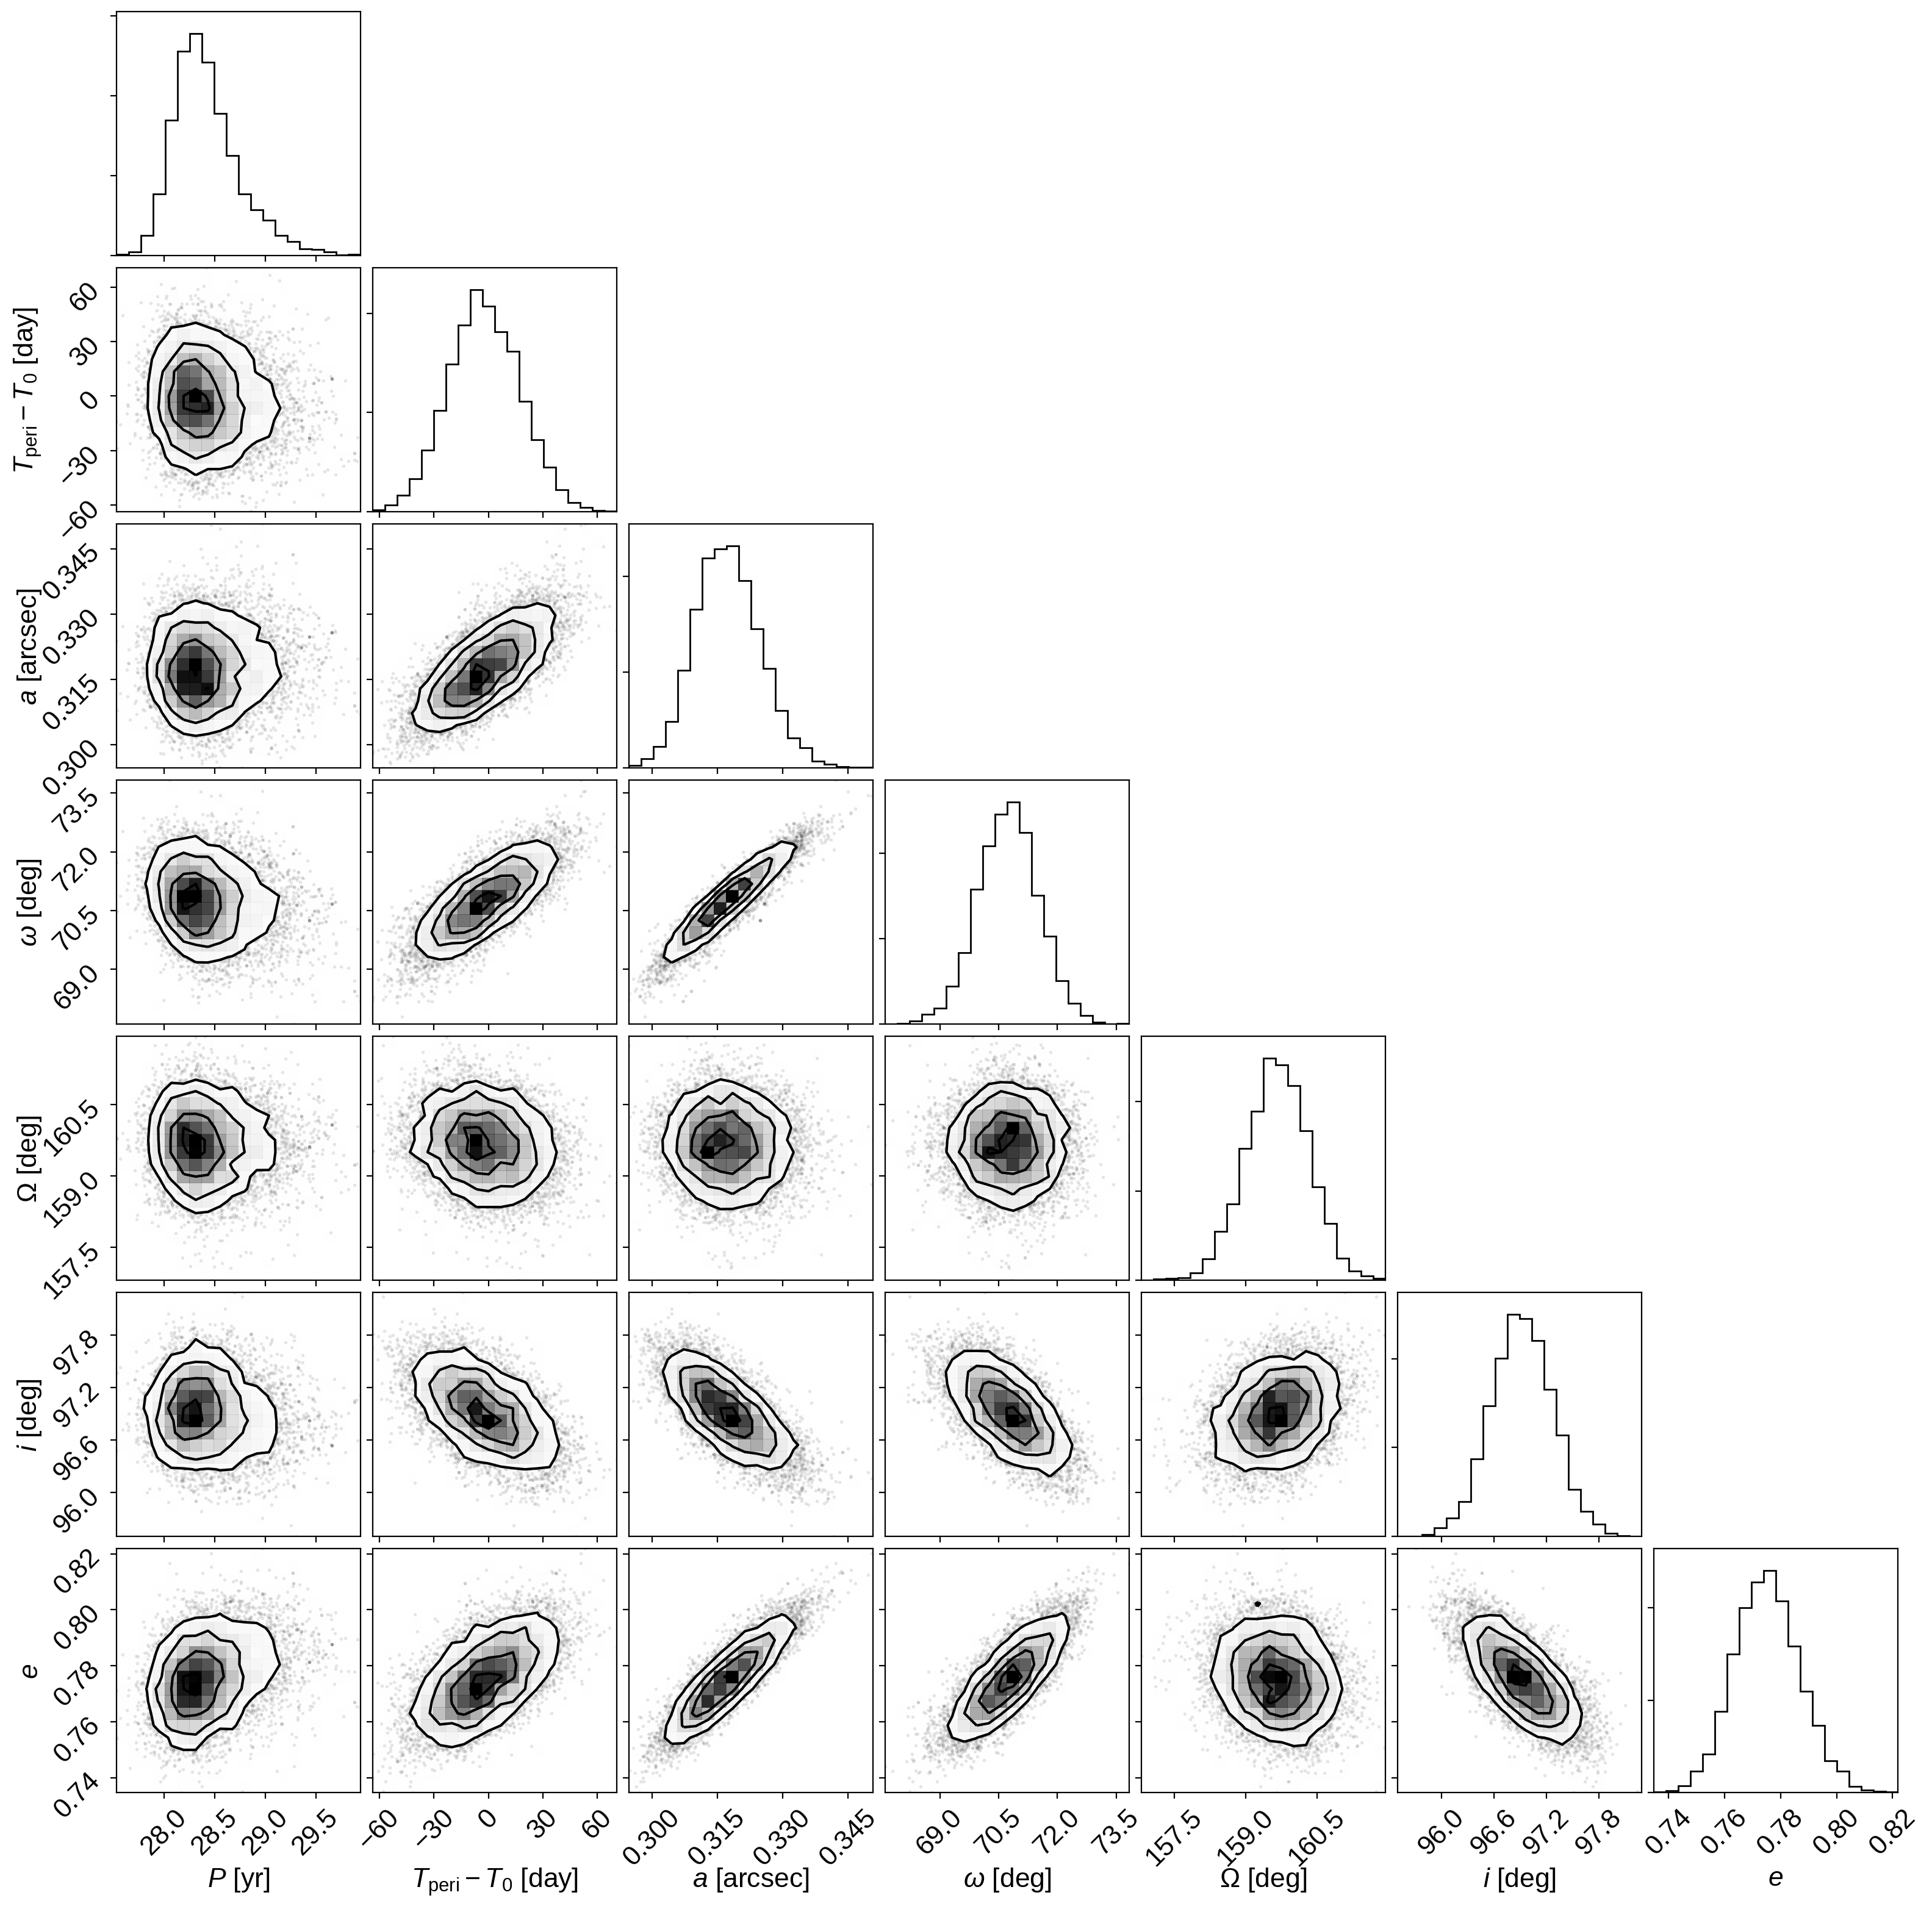

In [12]:
import corner

samples = pm.trace_to_dataframe(trace, varnames=["ecc"])
samples["$P$ [yr]"] = trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = trace["tperi"] - T0
samples["$a$ [arcsec]"] = trace["a_ang"]
samples["$\omega$ [deg]"] = (trace["omega"] / deg) % 360
samples["$\Omega$ [deg]"] = (trace["Omega"] / deg) % 360
samples["$i$ [deg]"] = (trace["incl"] / deg) % 360
samples["$e$"] = samples["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

Finally, we can plot the posterior constraints on $\rho$ and $\theta$.
This figure is much like the one for the MAP solution above, but this time the orange is a contour (not a line) showing the 68% credible region for the model.

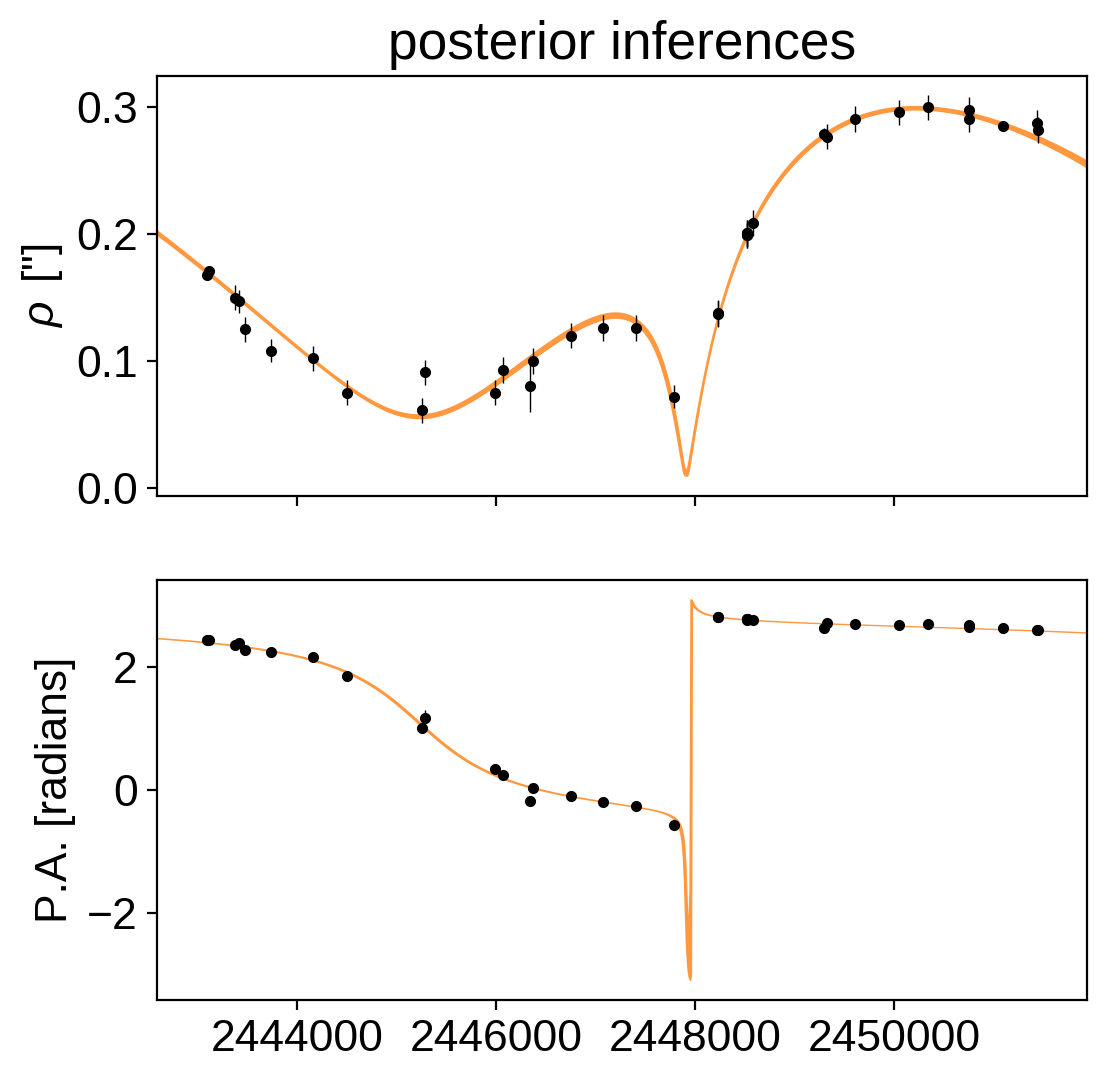

In [13]:
ekw = dict(fmt=".k", lw=0.5)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax[0].set_ylabel(r'$\rho\,$ ["]')
ax[1].set_ylabel(r"P.A. [radians]")

tot_rho_err = np.sqrt(
    rho_err ** 2 + np.exp(2 * np.median(trace["log_rho_s"], axis=0))
)
tot_theta_err = np.sqrt(
    theta_err ** 2 + np.exp(2 * np.median(trace["log_theta_s"], axis=0))
)

ax[0].errorbar(astro_jds, rho_data, yerr=tot_rho_err, **ekw)
q = np.percentile(trace["rho_save"], [16, 84], axis=0)
ax[0].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[1].errorbar(astro_jds, theta_data, yerr=tot_theta_err, **ekw)
q = np.percentile(trace["theta_save"], [16, 84], axis=0)
ax[1].fill_between(t_fine, q[0], q[1], color="C1", alpha=0.8, lw=0)

ax[-1].set_xlim(t_fine[0], t_fine[-1])
_ = ax[0].set_title("posterior inferences")

As we can see from the narrow range of orbits (the orange swath appears like a thin line), the orbit is actually highly constrained by the astrometry.
We also see two outlier epochs in the vicinity of 2445000 - 2447000, since adjacent epochs seem to be right on the orbit.
It's likely the uncertainties were not estimated correctly for these, and the simlplistic jitter model we implemented isn't sophisticated to apply more weight to only these discrepant points.

## Including parallax

While this is encouraging that we fit an astrometric orbit, a simple astrometric fit to just $\rho$ and $\theta$ isn't actually that physically satisfying, since many of the orbital parameters simply have to do with the orientation relative to us ($i$, $\omega$, and $\Omega$). The only truely intrinsic parameters are $P$ and $e$. To learn more about some of the physical parameters, such as the total mass of the system, we'd like to incorporate distance information to put a physical scale to the problem.

The *Gaia* DR2 parallax is $\varpi = 24.05 \pm 0.45$ mas.

We can use exactly the same model as above with only an added parallax constraint:

In [14]:
plx_model, plx_map_soln = get_model(parallax=[24.05, 0.45])

optimizing logp for variables: [log_theta_s, log_rho_s]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.076402e+02]

1it [00:00, 519.61it/s, logp=1.076402e+02]

2it [00:00, 709.40it/s, logp=1.076402e+02]

3it [00:00, 690.76it/s, logp=1.476711e+02]

4it [00:00, 709.04it/s, logp=1.084303e+02]

5it [00:00, 729.19it/s, logp=1.485840e+02]

6it [00:00, 747.31it/s, logp=1.497845e+02]

7it [00:00, 777.36it/s, logp=1.499280e+02]

8it [00:00, 757.97it/s, logp=1.499286e+02]

9it [00:00, 761.22it/s, logp=1.499286e+02]

10it [00:00, 769.95it/s, logp=1.499286e+02]

11it [00:02,  4.84it/s, logp=1.499286e+02] 


message: Optimization terminated successfully.
logp: 107.64015029566296 -> 149.92860106267193


optimizing logp for variables: [phase]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.499286e+02]

1it [00:00, 621.75it/s, logp=1.499286e+02]

2it [00:00, 774.79it/s, logp=1.499286e+02]

3it [00:00, 806.60it/s, logp=-1.185553e+04]

4it [00:00, 758.84it/s, logp=1.499517e+02] 

5it [00:00, 728.35it/s, logp=1.499982e+02]

6it [00:00, 652.62it/s, logp=1.501832e+02]

7it [00:00, 687.40it/s, logp=1.509035e+02]

8it [00:00, 666.34it/s, logp=1.535077e+02]

9it [00:00, 676.49it/s, logp=1.593811e+02]

10it [00:00, 682.86it/s, logp=1.662757e+02]

11it [00:00, 698.99it/s, logp=1.694242e+02]

12it [00:00, 699.23it/s, logp=1.703302e+02]

13it [00:00, 711.11it/s, logp=1.704061e+02]

14it [00:00, 717.11it/s, logp=1.704094e+02]

15it [00:00, 727.05it/s, logp=1.704128e+02]

16it [00:00, 727.66it/s, logp=1.704184e+02]

17it [00:00, 735.21it/s, logp=1.704249e+02]

18it [00:00, 738.53it/s, logp=1.704265e+02]

19it [00:00, 746.11it/s, logp=1.704268e+02]

20it [00:00, 749.51it/s, logp=1.704268e+02]

21it [00:00, 755.54it/s, logp=1.704268e+02]

22it [00:00, 756.87it/s, logp=1.704268e+02]

23it [00:00, 23.80it/s, logp=1.704268e+02] 


message: Optimization terminated successfully.
logp: 149.92860106267193 -> 170.4268151845905


optimizing logp for variables: [ecc, m, p]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=1.704268e+02]

1it [00:00, 392.43it/s, logp=1.704268e+02]

2it [00:00, 553.30it/s, logp=1.704268e+02]

3it [00:00, 620.12it/s, logp=-4.518236e+03]

4it [00:00, 658.99it/s, logp=1.710200e+02] 

5it [00:00, 645.10it/s, logp=1.695336e+02]

6it [00:00, 681.96it/s, logp=1.711520e+02]

7it [00:00, 679.87it/s, logp=1.714066e+02]

8it [00:00, 701.83it/s, logp=1.721879e+02]

9it [00:00, 716.70it/s, logp=1.742150e+02]

10it [00:00, 729.84it/s, logp=1.812157e+02]

11it [00:00, 735.51it/s, logp=1.949820e+02]

12it [00:00, 745.08it/s, logp=1.964691e+02]

13it [00:00, 748.85it/s, logp=1.992100e+02]

14it [00:00, 756.90it/s, logp=2.038785e+02]

15it [00:00, 755.86it/s, logp=2.102587e+02]

16it [00:00, 759.29it/s, logp=2.122110e+02]

17it [00:00, 759.52it/s, logp=2.126408e+02]

18it [00:00, 760.93it/s, logp=2.126846e+02]

19it [00:00, 766.23it/s, logp=2.126998e+02]

20it [00:00, 732.99it/s, logp=2.127263e+02]

21it [00:00, 737.64it/s, logp=2.127699e+02]

22it [00:00, 731.41it/s, logp=2.128244e+02]

23it [00:00, 736.43it/s, logp=2.128398e+02]

24it [00:00, 740.41it/s, logp=2.128456e+02]

25it [00:00, 742.19it/s, logp=2.128460e+02]

26it [00:00, 738.67it/s, logp=2.128463e+02]

27it [00:00, 737.71it/s, logp=2.128468e+02]

28it [00:00, 736.66it/s, logp=2.128475e+02]

29it [00:00, 739.40it/s, logp=2.128479e+02]

30it [00:00, 742.37it/s, logp=2.128480e+02]

31it [00:00, 743.04it/s, logp=2.128480e+02]

32it [00:00, 743.37it/s, logp=2.128480e+02]

33it [00:00, 746.03it/s, logp=2.128480e+02]

34it [00:00, 747.30it/s, logp=2.128480e+02]

35it [00:00, 35.00it/s, logp=2.128480e+02] 


message: Optimization terminated successfully.
logp: 170.42681518459054 -> 212.8480158855976


optimizing logp for variables: [phase, a_ang, logP]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.128480e+02]

1it [00:00, 442.20it/s, logp=2.128480e+02]

2it [00:00, 570.89it/s, logp=2.128480e+02]

3it [00:00, 615.21it/s, logp=-4.375386e+03]

4it [00:00, 666.98it/s, logp=2.129960e+02] 

5it [00:00, 681.56it/s, logp=2.131453e+02]

6it [00:00, 703.07it/s, logp=2.132729e+02]

7it [00:00, 715.42it/s, logp=2.132857e+02]

8it [00:00, 728.18it/s, logp=2.132857e+02]

9it [00:00, 749.59it/s, logp=2.132860e+02]

10it [00:00, 761.77it/s, logp=2.132860e+02]

11it [00:00, 765.05it/s, logp=2.132860e+02]

12it [00:00, 12.27it/s, logp=2.132860e+02] 


message: Optimization terminated successfully.
logp: 212.8480158855976 -> 213.28597909410882


optimizing logp for variables: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]
0it [00:00, ?it/s]

0it [00:00, ?it/s, logp=2.132860e+02]

1it [00:00, 394.68it/s, logp=2.132860e+02]

2it [00:00, 530.82it/s, logp=2.132860e+02]

3it [00:00, 535.06it/s, logp=-4.038433e+03]

4it [00:00, 579.78it/s, logp=2.152474e+02] 

5it [00:00, 554.36it/s, logp=1.676432e+02]

6it [00:00, 581.17it/s, logp=2.153207e+02]

7it [00:00, 584.62it/s, logp=2.154316e+02]

8it [00:00, 593.85it/s, logp=2.156115e+02]

9it [00:00, 598.16it/s, logp=2.158705e+02]

10it [00:00, 579.69it/s, logp=2.160160e+02]

11it [00:00, 589.52it/s, logp=2.158620e+02]

12it [00:00, 600.85it/s, logp=2.160652e+02]

13it [00:00, 603.66it/s, logp=2.160890e+02]

14it [00:00, 601.74it/s, logp=2.161353e+02]

15it [00:00, 607.03it/s, logp=2.162848e+02]

16it [00:00, 607.88it/s, logp=2.166196e+02]

17it [00:00, 609.49it/s, logp=2.171740e+02]

18it [00:00, 611.82it/s, logp=2.175761e+02]

19it [00:00, 614.35it/s, logp=2.174845e+02]

20it [00:00, 620.83it/s, logp=2.176565e+02]

21it [00:00, 624.63it/s, logp=2.177043e+02]

22it [00:00, 625.27it/s, logp=2.177335e+02]

23it [00:00, 629.20it/s, logp=2.177622e+02]

24it [00:00, 629.65it/s, logp=2.177547e+02]

25it [00:00, 631.16it/s, logp=2.177767e+02]

26it [00:00, 629.95it/s, logp=2.177873e+02]

27it [00:00, 631.03it/s, logp=2.177936e+02]

28it [00:00, 633.41it/s, logp=2.178014e+02]

29it [00:00, 634.04it/s, logp=2.178034e+02]

30it [00:00, 635.72it/s, logp=2.178054e+02]

31it [00:00, 613.28it/s, logp=2.178058e+02]

32it [00:00, 615.21it/s, logp=2.178059e+02]

33it [00:00, 618.00it/s, logp=2.178059e+02]

34it [00:00, 619.86it/s, logp=2.178059e+02]

35it [00:00, 613.61it/s, logp=2.178059e+02]

36it [00:00, 614.51it/s, logp=2.178059e+02]

37it [00:00, 614.40it/s, logp=2.178059e+02]

38it [00:00, 616.96it/s, logp=2.178059e+02]

39it [00:00, 618.83it/s, logp=2.178059e+02]

40it [00:00, 621.56it/s, logp=2.178059e+02]

41it [00:00, 625.76it/s, logp=2.178059e+02]

42it [00:00, 628.43it/s, logp=2.178059e+02]

43it [00:00, 630.37it/s, logp=2.178059e+02]

44it [00:00, 633.31it/s, logp=2.178059e+02]

45it [00:00, 635.18it/s, logp=2.178059e+02]

46it [00:00, 637.96it/s, logp=2.178059e+02]

47it [00:00, 640.76it/s, logp=2.178059e+02]

48it [00:00, 642.70it/s, logp=2.178059e+02]

49it [00:00, 645.41it/s, logp=2.178059e+02]

50it [00:00, 646.80it/s, logp=2.178059e+02]

51it [00:00, 649.70it/s, logp=2.178059e+02]

52it [00:00, 652.22it/s, logp=2.178059e+02]

53it [00:00, 653.97it/s, logp=2.178059e+02]

54it [00:00, 656.62it/s, logp=2.178059e+02]

55it [00:00, 659.25it/s, logp=2.178059e+02]

56it [00:00, 661.01it/s, logp=2.178059e+02]

57it [00:00, 663.57it/s, logp=2.178059e+02]

58it [00:00, 663.93it/s, logp=2.178059e+02]

59it [00:00, 665.93it/s, logp=2.178059e+02]

60it [00:00, 666.66it/s, logp=2.178059e+02]

61it [00:00, 668.39it/s, logp=2.178059e+02]

62it [00:00, 670.11it/s, logp=2.178059e+02]

63it [00:00, 671.98it/s, logp=2.178059e+02]

64it [00:00, 667.78it/s, logp=2.178059e+02]

65it [00:00, 668.10it/s, logp=2.178059e+02]

66it [00:00, 661.53it/s, logp=2.178059e+02]

67it [00:00, 668.15it/s, logp=2.178059e+02]

67it [00:00, 668.15it/s, logp=2.178059e+02]

68it [00:00, 668.15it/s, logp=2.178059e+02]

69it [00:00, 668.15it/s, logp=2.178059e+02]

70it [00:00, 668.15it/s, logp=2.178059e+02]

71it [00:00, 668.15it/s, logp=2.178059e+02]

72it [00:00, 668.15it/s, logp=2.178059e+02]

73it [00:00, 668.15it/s, logp=2.178059e+02]

74it [00:00, 668.15it/s, logp=2.178059e+02]

75it [00:00, 668.15it/s, logp=2.178059e+02]

76it [00:00, 668.15it/s, logp=2.178059e+02]

77it [00:00, 668.15it/s, logp=2.178059e+02]

78it [00:00, 668.15it/s, logp=2.178059e+02]

79it [00:00, 668.15it/s, logp=2.178059e+02]

80it [00:00, 668.15it/s, logp=2.178059e+02]

81it [00:00, 668.15it/s, logp=2.178059e+02]

82it [00:00, 668.15it/s, logp=2.178059e+02]

83it [00:00, 668.15it/s, logp=2.178059e+02]

84it [00:00, 668.15it/s, logp=2.178059e+02]

85it [00:00, 668.15it/s, logp=2.178059e+02]

86it [00:00, 668.15it/s, logp=2.178059e+02]

87it [00:00, 668.15it/s, logp=2.178059e+02]

88it [00:00, 668.15it/s, logp=2.178059e+02]

89it [00:00, 668.15it/s, logp=2.178059e+02]

90it [00:00, 668.15it/s, logp=2.178059e+02]

91it [00:00, 668.15it/s, logp=2.178059e+02]

92it [00:00, 668.15it/s, logp=2.178059e+02]

93it [00:00, 668.15it/s, logp=2.178059e+02]

94it [00:00, 668.15it/s, logp=2.178059e+02]

95it [00:00, 668.15it/s, logp=2.178059e+02]

96it [00:00, 668.15it/s, logp=2.178059e+02]

97it [00:00, 668.15it/s, logp=2.178059e+02]

98it [00:00, 668.15it/s, logp=2.178059e+02]

99it [00:00, 668.15it/s, logp=2.178059e+02]

100it [00:00, 668.15it/s, logp=2.178059e+02]

101it [00:00, 668.15it/s, logp=2.178059e+02]

102it [00:00, 668.15it/s, logp=2.178059e+02]

103it [00:00, 668.15it/s, logp=2.178059e+02]

104it [00:00, 668.15it/s, logp=2.178059e+02]

105it [00:00, 668.15it/s, logp=2.178059e+02]

106it [00:00, 668.15it/s, logp=2.178059e+02]

107it [00:00, 668.15it/s, logp=2.178059e+02]

108it [00:00, 668.15it/s, logp=2.178059e+02]

109it [00:00, 668.15it/s, logp=2.178059e+02]

110it [00:00, 668.15it/s, logp=2.178059e+02]

111it [00:00, 668.15it/s, logp=2.178059e+02]

112it [00:00, 668.15it/s, logp=2.178059e+02]

113it [00:00, 668.15it/s, logp=2.178059e+02]

114it [00:00, 668.15it/s, logp=2.178059e+02]

115it [00:00, 668.15it/s, logp=2.178059e+02]

116it [00:00, 668.15it/s, logp=2.178059e+02]

117it [00:00, 668.15it/s, logp=2.178059e+02]

118it [00:00, 668.15it/s, logp=2.178059e+02]

119it [00:00, 668.15it/s, logp=2.178059e+02]

120it [00:00, 668.15it/s, logp=2.178059e+02]

121it [00:00, 668.15it/s, logp=2.178059e+02]

122it [00:00, 668.15it/s, logp=2.178059e+02]

123it [00:00, 668.15it/s, logp=2.178059e+02]

124it [00:00, 668.15it/s, logp=2.178059e+02]

125it [00:00, 668.15it/s, logp=2.178059e+02]

126it [00:00, 668.15it/s, logp=2.178059e+02]

127it [00:00, 668.15it/s, logp=2.178059e+02]

128it [00:00, 668.15it/s, logp=2.178059e+02]

129it [00:00, 668.15it/s, logp=2.178059e+02]

130it [00:00, 668.15it/s, logp=2.178059e+02]

131it [00:00, 668.15it/s, logp=2.178059e+02]

132it [00:00, 668.15it/s, logp=2.178059e+02]

133it [00:00, 668.15it/s, logp=2.178059e+02]

134it [00:00, 668.15it/s, logp=2.178059e+02]

135it [00:00, 668.15it/s, logp=2.178059e+02]

136it [00:00, 668.15it/s, logp=2.178059e+02]

137it [00:00, 674.01it/s, logp=2.178059e+02]

137it [00:00, 674.01it/s, logp=2.178059e+02]

138it [00:00, 674.01it/s, logp=2.178059e+02]

139it [00:00, 674.01it/s, logp=2.178059e+02]

140it [00:00, 674.01it/s, logp=2.178059e+02]

141it [00:00, 674.01it/s, logp=2.178059e+02]

142it [00:00, 674.01it/s, logp=2.178059e+02]

143it [00:01, 88.54it/s, logp=2.178059e+02] 


message: Desired error not necessarily achieved due to precision loss.
logp: 213.28597909410882 -> 217.80586833503563


In [15]:
np.random.seed(5432)
with plx_model:
    plx_trace = pm.sample(
        tune=5000,
        draws=4000,
        start=plx_map_soln,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9, start=plx_map_soln),
    )

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [log_theta_s, log_rho_s, ecc, cos_incl, phase, m, p, logP, a_ang, m_plx]


Sampling 2 chains, 0 divergences:   0%|          | 0/18000 [00:00<?, ?draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 7/18000 [00:00<06:37, 45.30draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 9/18000 [00:00<11:02, 27.14draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 11/18000 [00:00<14:06, 21.24draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 13/18000 [00:00<16:13, 18.48draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 15/18000 [00:00<17:52, 16.77draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 17/18000 [00:00<18:55, 15.84draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 19/18000 [00:01<19:28, 15.39draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 21/18000 [00:01<20:00, 14.97draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 23/18000 [00:01<20:14, 14.81draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 25/18000 [00:01<20:21, 14.71draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 27/18000 [00:01<20:34, 14.56draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 29/18000 [00:01<20:40, 14.49draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 32/18000 [00:01<19:24, 15.43draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 34/18000 [00:02<20:17, 14.75draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 36/18000 [00:02<20:47, 14.40draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 38/18000 [00:02<21:11, 14.13draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 42/18000 [00:02<18:12, 16.44draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 44/18000 [00:02<19:19, 15.48draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 46/18000 [00:02<20:03, 14.91draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 48/18000 [00:02<20:34, 14.55draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 51/18000 [00:03<17:53, 16.72draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 54/18000 [00:03<16:48, 17.80draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 57/18000 [00:03<16:37, 18.00draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 60/18000 [00:03<16:00, 18.69draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 62/18000 [00:03<17:39, 16.93draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 64/18000 [00:03<19:11, 15.57draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 66/18000 [00:03<19:48, 15.09draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 68/18000 [00:04<20:13, 14.78draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 70/18000 [00:04<20:42, 14.43draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 73/18000 [00:04<18:46, 15.92draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 75/18000 [00:04<19:38, 15.21draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 77/18000 [00:04<20:20, 14.68draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 79/18000 [00:04<20:25, 14.62draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 81/18000 [00:04<20:37, 14.47draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 83/18000 [00:05<20:46, 14.37draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 85/18000 [00:05<20:50, 14.32draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 88/18000 [00:05<19:40, 15.18draws/s]

Sampling 2 chains, 0 divergences:   0%|          | 90/18000 [00:05<20:05, 14.85draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 92/18000 [00:05<20:23, 14.64draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 94/18000 [00:05<20:34, 14.51draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 97/18000 [00:05<18:52, 15.81draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 100/18000 [00:06<18:47, 15.88draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 102/18000 [00:06<19:34, 15.24draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 104/18000 [00:06<20:04, 14.86draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 106/18000 [00:06<20:23, 14.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 108/18000 [00:06<21:06, 14.12draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 111/18000 [00:06<19:06, 15.60draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 113/18000 [00:06<19:45, 15.08draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 116/18000 [00:07<20:05, 14.83draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 119/18000 [00:07<18:34, 16.04draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 121/18000 [00:07<19:24, 15.35draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 123/18000 [00:07<19:55, 14.96draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 125/18000 [00:07<20:14, 14.72draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 127/18000 [00:07<20:22, 14.62draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 129/18000 [00:08<21:46, 13.67draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 131/18000 [00:08<21:28, 13.87draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 133/18000 [00:08<21:29, 13.86draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 136/18000 [00:08<19:28, 15.29draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 138/18000 [00:08<18:16, 16.30draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 140/18000 [00:08<19:10, 15.52draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 142/18000 [00:08<19:28, 15.29draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 144/18000 [00:09<19:59, 14.89draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 146/18000 [00:09<21:14, 14.01draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 149/18000 [00:09<19:16, 15.44draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 151/18000 [00:09<19:54, 14.94draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 154/18000 [00:09<18:29, 16.09draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 156/18000 [00:09<17:49, 16.69draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 158/18000 [00:09<18:53, 15.74draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 161/18000 [00:10<17:35, 16.91draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 163/18000 [00:10<18:32, 16.03draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 169/18000 [00:10<15:08, 19.63draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 172/18000 [00:10<15:02, 19.75draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 175/18000 [00:10<15:24, 19.28draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 178/18000 [00:10<17:39, 16.83draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 182/18000 [00:11<15:17, 19.41draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 185/18000 [00:11<15:25, 19.24draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 188/18000 [00:11<16:57, 17.50draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 190/18000 [00:11<16:42, 17.77draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 192/18000 [00:11<16:16, 18.23draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 194/18000 [00:11<17:35, 16.86draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 196/18000 [00:11<18:22, 16.15draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 198/18000 [00:12<19:03, 15.56draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 200/18000 [00:12<19:23, 15.30draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 202/18000 [00:12<19:50, 14.95draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 205/18000 [00:12<18:02, 16.44draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 208/18000 [00:12<15:49, 18.74draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 211/18000 [00:12<14:09, 20.94draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 214/18000 [00:12<13:03, 22.71draws/s]

Sampling 2 chains, 0 divergences:   1%|          | 218/18000 [00:12<11:30, 25.77draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 225/18000 [00:12<09:26, 31.40draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 238/18000 [00:13<07:24, 39.94draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 249/18000 [00:13<06:00, 49.20draws/s]

Sampling 2 chains, 0 divergences:   1%|▏         | 261/18000 [00:13<04:59, 59.22draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 271/18000 [00:13<04:25, 66.73draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 281/18000 [00:13<03:59, 74.03draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 294/18000 [00:13<03:32, 83.42draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 313/18000 [00:13<02:58, 99.17draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 333/18000 [00:13<02:31, 116.50draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 348/18000 [00:13<02:27, 119.72draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 369/18000 [00:14<02:10, 135.15draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 385/18000 [00:14<02:09, 135.62draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 402/18000 [00:14<02:02, 143.18draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 421/18000 [00:14<01:55, 151.80draws/s]

Sampling 2 chains, 0 divergences:   2%|▏         | 438/18000 [00:14<01:52, 155.92draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 455/18000 [00:14<01:52, 155.92draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 473/18000 [00:14<01:49, 159.45draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 494/18000 [00:14<01:41, 171.72draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 516/18000 [00:14<01:36, 181.08draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 535/18000 [00:14<01:35, 182.22draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 554/18000 [00:15<01:35, 182.70draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 573/18000 [00:15<01:36, 179.66draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 592/18000 [00:15<01:42, 169.74draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 610/18000 [00:15<01:42, 169.25draws/s]

Sampling 2 chains, 0 divergences:   3%|▎         | 629/18000 [00:15<01:39, 174.21draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 648/18000 [00:15<01:37, 178.41draws/s]

Sampling 2 chains, 0 divergences:   4%|▎         | 666/18000 [00:15<01:37, 178.53draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 684/18000 [00:15<01:44, 165.24draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 701/18000 [00:16<01:56, 148.01draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 717/18000 [00:16<01:56, 148.45draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 735/18000 [00:16<01:51, 154.59draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 751/18000 [00:16<01:51, 155.27draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 767/18000 [00:16<01:51, 154.20draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 783/18000 [00:16<02:11, 130.86draws/s]

Sampling 2 chains, 0 divergences:   4%|▍         | 797/18000 [00:16<02:13, 128.77draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 811/18000 [00:16<02:21, 121.29draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 825/18000 [00:16<02:17, 125.26draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 844/18000 [00:17<02:03, 138.61draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 859/18000 [00:17<02:04, 137.91draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 874/18000 [00:17<02:07, 133.94draws/s]

Sampling 2 chains, 0 divergences:   5%|▍         | 888/18000 [00:17<02:14, 127.07draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 902/18000 [00:17<02:15, 126.45draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 916/18000 [00:17<02:14, 126.85draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 931/18000 [00:17<02:10, 130.46draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 945/18000 [00:17<02:08, 132.52draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 962/18000 [00:17<02:01, 140.46draws/s]

Sampling 2 chains, 0 divergences:   5%|▌         | 978/18000 [00:18<02:01, 139.94draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 993/18000 [00:18<02:09, 131.46draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1007/18000 [00:18<02:09, 130.78draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1021/18000 [00:18<02:09, 131.60draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1035/18000 [00:18<02:10, 129.87draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1049/18000 [00:18<02:19, 121.40draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1064/18000 [00:18<02:13, 126.68draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1077/18000 [00:18<02:15, 124.95draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1096/18000 [00:18<02:02, 137.64draws/s]

Sampling 2 chains, 0 divergences:   6%|▌         | 1112/18000 [00:19<02:01, 138.50draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1128/18000 [00:19<01:58, 142.95draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1144/18000 [00:19<01:56, 144.71draws/s]

Sampling 2 chains, 0 divergences:   6%|▋         | 1159/18000 [00:19<01:56, 145.11draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1174/18000 [00:19<01:57, 143.63draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1189/18000 [00:19<02:06, 133.20draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1203/18000 [00:19<02:12, 126.57draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1218/18000 [00:19<02:08, 131.04draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1236/18000 [00:19<01:58, 141.31draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1255/18000 [00:20<01:51, 149.99draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1273/18000 [00:20<01:46, 157.24draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1290/18000 [00:20<01:50, 151.42draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1306/18000 [00:20<01:51, 149.06draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1322/18000 [00:20<01:52, 148.28draws/s]

Sampling 2 chains, 0 divergences:   7%|▋         | 1339/18000 [00:20<01:50, 150.52draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1355/18000 [00:20<01:57, 141.53draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1370/18000 [00:20<02:03, 134.79draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1384/18000 [00:20<02:10, 126.90draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1399/18000 [00:21<02:05, 132.31draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1417/18000 [00:21<01:56, 142.63draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1432/18000 [00:21<01:55, 143.15draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1447/18000 [00:21<01:54, 144.43draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1463/18000 [00:21<01:51, 148.43draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1479/18000 [00:21<01:56, 141.60draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1494/18000 [00:21<02:15, 121.97draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1507/18000 [00:21<02:19, 118.28draws/s]

Sampling 2 chains, 0 divergences:   8%|▊         | 1520/18000 [00:22<02:16, 121.02draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1533/18000 [00:22<02:19, 117.76draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1548/18000 [00:22<02:11, 124.95draws/s]

Sampling 2 chains, 0 divergences:   9%|▊         | 1565/18000 [00:22<02:02, 134.11draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1583/18000 [00:22<01:55, 142.09draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1598/18000 [00:22<01:54, 142.91draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1613/18000 [00:22<01:55, 142.34draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1628/18000 [00:22<01:57, 139.36draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1643/18000 [00:22<01:59, 136.62draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1657/18000 [00:23<02:06, 129.53draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1671/18000 [00:23<02:11, 123.71draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1687/18000 [00:23<02:04, 130.66draws/s]

Sampling 2 chains, 0 divergences:   9%|▉         | 1701/18000 [00:23<02:05, 130.38draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1715/18000 [00:23<02:02, 132.61draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1729/18000 [00:23<02:02, 132.64draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1743/18000 [00:23<02:02, 132.32draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1757/18000 [00:23<02:08, 126.78draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1770/18000 [00:23<02:19, 116.60draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1784/18000 [00:24<02:12, 122.70draws/s]

Sampling 2 chains, 0 divergences:  10%|▉         | 1797/18000 [00:24<02:18, 116.70draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1809/18000 [00:24<02:21, 114.19draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1823/18000 [00:24<02:14, 120.02draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1838/18000 [00:24<02:08, 125.93draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1851/18000 [00:24<02:07, 126.66draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1865/18000 [00:24<02:04, 129.54draws/s]

Sampling 2 chains, 0 divergences:  10%|█         | 1879/18000 [00:24<02:13, 120.98draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1892/18000 [00:24<02:19, 115.86draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1904/18000 [00:25<02:21, 113.68draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1919/18000 [00:25<02:11, 121.93draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1935/18000 [00:25<02:03, 129.84draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1949/18000 [00:25<02:01, 132.43draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1963/18000 [00:25<02:00, 133.34draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1977/18000 [00:25<02:01, 131.62draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 1991/18000 [00:25<02:01, 131.87draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 2005/18000 [00:25<02:00, 133.01draws/s]

Sampling 2 chains, 0 divergences:  11%|█         | 2021/18000 [00:25<01:54, 139.12draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2038/18000 [00:25<01:52, 141.90draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2053/18000 [00:26<01:53, 140.64draws/s]

Sampling 2 chains, 0 divergences:  11%|█▏        | 2069/18000 [00:26<01:51, 143.12draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2087/18000 [00:26<01:45, 150.79draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2103/18000 [00:26<01:54, 138.40draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2118/18000 [00:26<01:56, 136.67draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2132/18000 [00:26<02:05, 126.81draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2145/18000 [00:26<02:07, 124.47draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2159/18000 [00:26<02:03, 128.14draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2172/18000 [00:26<02:04, 127.46draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2187/18000 [00:27<01:58, 133.21draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2201/18000 [00:27<02:07, 124.07draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2214/18000 [00:27<02:10, 121.08draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2228/18000 [00:27<02:07, 124.03draws/s]

Sampling 2 chains, 0 divergences:  12%|█▏        | 2242/18000 [00:27<02:04, 126.62draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2257/18000 [00:27<01:58, 132.73draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2271/18000 [00:27<02:08, 122.03draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2284/18000 [00:27<02:09, 121.52draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2299/18000 [00:28<02:05, 124.81draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2314/18000 [00:28<02:02, 127.93draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2330/18000 [00:28<01:55, 135.44draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2344/18000 [00:28<01:59, 131.49draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2358/18000 [00:28<01:57, 133.36draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2372/18000 [00:28<02:00, 129.19draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2386/18000 [00:28<01:59, 130.17draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2400/18000 [00:28<02:05, 123.89draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2413/18000 [00:28<02:10, 119.52draws/s]

Sampling 2 chains, 0 divergences:  13%|█▎        | 2426/18000 [00:29<02:09, 119.82draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2439/18000 [00:29<02:08, 121.38draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2453/18000 [00:29<02:03, 125.71draws/s]

Sampling 2 chains, 0 divergences:  14%|█▎        | 2468/18000 [00:29<01:59, 129.92draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2483/18000 [00:29<01:54, 135.12draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2497/18000 [00:29<02:04, 124.23draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2511/18000 [00:29<02:03, 125.58draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2524/18000 [00:29<02:04, 124.61draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2537/18000 [00:29<02:11, 117.93draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2549/18000 [00:29<02:11, 117.89draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2562/18000 [00:30<02:09, 119.20draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2578/18000 [00:30<02:00, 128.24draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2592/18000 [00:30<01:58, 130.36draws/s]

Sampling 2 chains, 0 divergences:  14%|█▍        | 2607/18000 [00:30<01:55, 133.25draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2621/18000 [00:30<02:04, 124.02draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2637/18000 [00:30<01:57, 131.29draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2651/18000 [00:30<02:03, 124.10draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2664/18000 [00:30<02:02, 125.29draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2678/18000 [00:30<02:02, 125.34draws/s]

Sampling 2 chains, 0 divergences:  15%|█▍        | 2691/18000 [00:31<02:02, 125.42draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2704/18000 [00:31<02:07, 119.96draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2718/18000 [00:31<02:05, 121.69draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2731/18000 [00:31<02:10, 116.93draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2745/18000 [00:31<02:06, 120.12draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2759/18000 [00:31<02:02, 124.32draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2774/18000 [00:31<01:59, 127.90draws/s]

Sampling 2 chains, 0 divergences:  15%|█▌        | 2787/18000 [00:31<01:59, 126.78draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2800/18000 [00:31<02:07, 119.36draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2816/18000 [00:32<02:01, 124.69draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2829/18000 [00:32<02:15, 111.85draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2842/18000 [00:32<02:10, 116.05draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2856/18000 [00:32<02:04, 121.89draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2869/18000 [00:32<02:13, 113.14draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2881/18000 [00:32<02:18, 109.15draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2893/18000 [00:32<02:15, 111.28draws/s]

Sampling 2 chains, 0 divergences:  16%|█▌        | 2909/18000 [00:32<02:04, 121.61draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2926/18000 [00:33<01:55, 130.78draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2943/18000 [00:33<01:47, 139.97draws/s]

Sampling 2 chains, 0 divergences:  16%|█▋        | 2961/18000 [00:33<01:42, 147.44draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2981/18000 [00:33<01:35, 156.95draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 2998/18000 [00:33<01:35, 157.34draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3015/18000 [00:33<01:38, 152.19draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3031/18000 [00:33<01:40, 148.62draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3048/18000 [00:33<01:38, 151.88draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3065/18000 [00:33<01:35, 156.70draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3081/18000 [00:33<01:35, 155.82draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3098/18000 [00:34<01:34, 158.35draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3114/18000 [00:34<01:34, 158.02draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3130/18000 [00:34<01:44, 142.53draws/s]

Sampling 2 chains, 0 divergences:  17%|█▋        | 3145/18000 [00:34<01:48, 137.34draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3160/18000 [00:34<01:46, 139.13draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3175/18000 [00:34<01:52, 132.35draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3189/18000 [00:34<01:51, 132.54draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3204/18000 [00:34<01:47, 137.21draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3218/18000 [00:34<01:48, 136.60draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3236/18000 [00:35<01:42, 143.67draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3251/18000 [00:35<01:43, 142.31draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3266/18000 [00:35<01:44, 141.48draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3283/18000 [00:35<01:41, 145.58draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3298/18000 [00:35<01:45, 139.34draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3313/18000 [00:35<01:48, 135.80draws/s]

Sampling 2 chains, 0 divergences:  18%|█▊        | 3330/18000 [00:35<01:43, 141.95draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3346/18000 [00:35<01:41, 144.30draws/s]

Sampling 2 chains, 0 divergences:  19%|█▊        | 3362/18000 [00:35<01:39, 147.64draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3378/18000 [00:36<01:38, 148.42draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3393/18000 [00:36<01:45, 137.93draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3407/18000 [00:36<01:49, 132.74draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3424/18000 [00:36<01:45, 138.74draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3441/18000 [00:36<01:40, 144.78draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3456/18000 [00:36<01:42, 141.89draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3471/18000 [00:36<01:45, 138.06draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3485/18000 [00:36<01:45, 137.66draws/s]

Sampling 2 chains, 0 divergences:  19%|█▉        | 3499/18000 [00:36<01:50, 130.71draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3513/18000 [00:37<01:55, 125.81draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3526/18000 [00:37<01:57, 123.30draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3539/18000 [00:37<01:55, 124.94draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3552/18000 [00:37<01:55, 125.26draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3568/18000 [00:37<01:50, 130.98draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3582/18000 [00:37<01:51, 129.04draws/s]

Sampling 2 chains, 0 divergences:  20%|█▉        | 3596/18000 [00:37<01:49, 131.74draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3611/18000 [00:37<01:46, 135.42draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3627/18000 [00:37<01:41, 141.49draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3645/18000 [00:38<01:35, 150.11draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3661/18000 [00:38<01:38, 145.55draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3676/18000 [00:38<01:48, 131.55draws/s]

Sampling 2 chains, 0 divergences:  20%|██        | 3690/18000 [00:38<01:50, 129.61draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3704/18000 [00:38<01:48, 131.92draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3720/18000 [00:38<01:44, 136.65draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3734/18000 [00:38<01:49, 129.82draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3748/18000 [00:38<01:49, 129.76draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3762/18000 [00:38<01:57, 121.39draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3775/18000 [00:39<02:02, 116.01draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3787/18000 [00:39<02:02, 116.04draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3799/18000 [00:39<02:07, 111.02draws/s]

Sampling 2 chains, 0 divergences:  21%|██        | 3814/18000 [00:39<02:00, 117.35draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3830/18000 [00:39<01:51, 126.56draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3846/18000 [00:39<01:44, 134.90draws/s]

Sampling 2 chains, 0 divergences:  21%|██▏       | 3861/18000 [00:39<01:42, 138.15draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3876/18000 [00:39<01:42, 138.32draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3891/18000 [00:39<01:43, 136.10draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3905/18000 [00:40<01:52, 125.25draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3919/18000 [00:40<01:49, 129.17draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3933/18000 [00:40<01:46, 131.58draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3950/18000 [00:40<01:41, 138.12draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3965/18000 [00:40<01:41, 138.17draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3979/18000 [00:40<01:41, 138.67draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 3994/18000 [00:40<01:39, 140.73draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4009/18000 [00:40<01:39, 140.17draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4024/18000 [00:40<01:43, 135.32draws/s]

Sampling 2 chains, 0 divergences:  22%|██▏       | 4038/18000 [00:41<01:42, 136.39draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4054/18000 [00:41<01:41, 137.65draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4069/18000 [00:41<01:40, 138.65draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4083/18000 [00:41<01:42, 135.76draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4100/18000 [00:41<01:39, 139.38draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4117/18000 [00:41<01:34, 146.31draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4132/18000 [00:41<01:46, 129.81draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4146/18000 [00:41<01:51, 124.73draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4159/18000 [00:41<01:50, 125.14draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4173/18000 [00:42<01:48, 127.65draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4186/18000 [00:42<01:48, 127.60draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4202/18000 [00:42<01:41, 135.38draws/s]

Sampling 2 chains, 0 divergences:  23%|██▎       | 4216/18000 [00:42<01:46, 129.85draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4231/18000 [00:42<01:42, 133.76draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4245/18000 [00:42<01:50, 124.48draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4258/18000 [00:42<01:55, 119.24draws/s]

Sampling 2 chains, 0 divergences:  24%|██▎       | 4271/18000 [00:42<01:55, 118.59draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4287/18000 [00:42<01:48, 126.58draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4305/18000 [00:43<01:39, 138.16draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4323/18000 [00:43<01:33, 146.99draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4339/18000 [00:43<01:36, 142.05draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4354/18000 [00:43<01:41, 135.07draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4368/18000 [00:43<01:46, 128.35draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4382/18000 [00:43<01:44, 130.44draws/s]

Sampling 2 chains, 0 divergences:  24%|██▍       | 4398/18000 [00:43<01:38, 137.90draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4413/18000 [00:43<01:36, 140.82draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4428/18000 [00:43<01:38, 137.57draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4443/18000 [00:44<01:38, 138.30draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4459/18000 [00:44<01:34, 143.97draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4474/18000 [00:44<01:44, 128.97draws/s]

Sampling 2 chains, 0 divergences:  25%|██▍       | 4488/18000 [00:44<01:50, 122.67draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4501/18000 [00:44<01:50, 121.86draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4514/18000 [00:44<01:50, 122.12draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4527/18000 [00:44<01:56, 115.98draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4542/18000 [00:44<01:49, 122.63draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4557/18000 [00:44<01:44, 128.71draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4573/18000 [00:45<01:40, 133.75draws/s]

Sampling 2 chains, 0 divergences:  25%|██▌       | 4589/18000 [00:45<01:35, 140.26draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4606/18000 [00:45<01:31, 146.80draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4622/18000 [00:45<01:29, 149.97draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4638/18000 [00:45<01:28, 150.95draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4654/18000 [00:45<01:27, 152.55draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4670/18000 [00:45<01:28, 150.86draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4686/18000 [00:45<01:35, 139.69draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4701/18000 [00:45<01:38, 134.89draws/s]

Sampling 2 chains, 0 divergences:  26%|██▌       | 4715/18000 [00:46<01:40, 132.79draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4732/18000 [00:46<01:34, 140.41draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4749/18000 [00:46<01:31, 145.26draws/s]

Sampling 2 chains, 0 divergences:  26%|██▋       | 4766/18000 [00:46<01:27, 151.08draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4782/18000 [00:46<01:26, 152.24draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4798/18000 [00:46<01:39, 132.74draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4812/18000 [00:46<01:44, 126.70draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4826/18000 [00:46<01:49, 120.49draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4839/18000 [00:47<01:47, 121.92draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4855/18000 [00:47<01:40, 130.73draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4870/18000 [00:47<01:38, 133.53draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4884/18000 [00:47<01:44, 125.02draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4897/18000 [00:47<01:50, 118.35draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4914/18000 [00:47<01:41, 128.31draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4928/18000 [00:47<01:40, 130.50draws/s]

Sampling 2 chains, 0 divergences:  27%|██▋       | 4945/18000 [00:47<01:35, 137.40draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4960/18000 [00:47<01:37, 133.11draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4974/18000 [00:48<01:39, 130.99draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 4988/18000 [00:48<01:39, 131.26draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5004/18000 [00:48<01:36, 134.05draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5018/18000 [00:48<01:38, 131.25draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5033/18000 [00:48<01:36, 134.68draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5051/18000 [00:48<01:29, 144.75draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5070/18000 [00:48<01:23, 155.56draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5089/18000 [00:48<01:18, 164.12draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5109/18000 [00:48<01:15, 171.70draws/s]

Sampling 2 chains, 0 divergences:  28%|██▊       | 5128/18000 [00:48<01:14, 172.59draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5146/18000 [00:49<01:21, 156.88draws/s]

Sampling 2 chains, 0 divergences:  29%|██▊       | 5163/18000 [00:49<01:23, 153.54draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5179/18000 [00:49<01:26, 148.00draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5196/18000 [00:49<01:23, 153.68draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5212/18000 [00:49<01:24, 150.89draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5229/18000 [00:49<01:23, 152.80draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5245/18000 [00:49<01:26, 147.54draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5260/18000 [00:49<01:36, 132.61draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5274/18000 [00:50<01:35, 133.82draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5289/18000 [00:50<01:33, 135.27draws/s]

Sampling 2 chains, 0 divergences:  29%|██▉       | 5307/18000 [00:50<01:28, 143.50draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5323/18000 [00:50<01:25, 147.80draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5339/18000 [00:50<01:27, 144.31draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5354/18000 [00:50<01:27, 143.83draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5369/18000 [00:50<01:28, 143.16draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5384/18000 [00:50<01:29, 140.31draws/s]

Sampling 2 chains, 0 divergences:  30%|██▉       | 5399/18000 [00:50<01:32, 135.58draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5416/18000 [00:51<01:27, 143.63draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5431/18000 [00:51<01:28, 142.43draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5446/18000 [00:51<01:35, 131.03draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5462/18000 [00:51<01:32, 135.85draws/s]

Sampling 2 chains, 0 divergences:  30%|███       | 5477/18000 [00:51<01:30, 138.30draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5492/18000 [00:51<01:29, 139.43draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5509/18000 [00:51<01:25, 146.76draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5526/18000 [00:51<01:23, 149.91draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5542/18000 [00:51<01:25, 146.22draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5557/18000 [00:52<01:29, 138.28draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5572/18000 [00:52<01:34, 131.60draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5587/18000 [00:52<01:34, 131.41draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5601/18000 [00:52<01:35, 129.49draws/s]

Sampling 2 chains, 0 divergences:  31%|███       | 5615/18000 [00:52<01:38, 125.51draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5628/18000 [00:52<01:39, 124.42draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5642/18000 [00:52<01:37, 127.12draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5655/18000 [00:52<01:36, 127.73draws/s]

Sampling 2 chains, 0 divergences:  31%|███▏      | 5668/18000 [00:52<01:37, 126.78draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5683/18000 [00:53<01:33, 131.15draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5697/18000 [00:53<01:32, 132.38draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5711/18000 [00:53<01:37, 125.42draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5724/18000 [00:53<01:41, 120.87draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5738/18000 [00:53<01:37, 125.74draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5753/18000 [00:53<01:33, 131.01draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5771/18000 [00:53<01:26, 141.05draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5788/18000 [00:53<01:22, 147.95draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5804/18000 [00:53<01:27, 140.00draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5819/18000 [00:54<01:30, 134.37draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5833/18000 [00:54<01:33, 130.50draws/s]

Sampling 2 chains, 0 divergences:  32%|███▏      | 5849/18000 [00:54<01:28, 136.67draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5866/18000 [00:54<01:23, 145.15draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5884/18000 [00:54<01:18, 153.47draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5900/18000 [00:54<01:18, 153.45draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5918/18000 [00:54<01:15, 160.41draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5935/18000 [00:54<01:16, 157.44draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5951/18000 [00:54<01:17, 156.27draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5969/18000 [00:54<01:14, 161.07draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 5986/18000 [00:55<01:14, 162.12draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6003/18000 [00:55<01:16, 157.07draws/s]

Sampling 2 chains, 0 divergences:  33%|███▎      | 6021/18000 [00:55<01:14, 161.04draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6038/18000 [00:55<01:21, 147.03draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6054/18000 [00:55<01:20, 149.15draws/s]

Sampling 2 chains, 0 divergences:  34%|███▎      | 6070/18000 [00:55<01:21, 145.76draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6085/18000 [00:55<01:27, 135.58draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6099/18000 [00:55<01:28, 133.78draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6113/18000 [00:56<01:32, 128.83draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6127/18000 [00:56<01:30, 130.54draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6141/18000 [00:56<01:30, 130.56draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6156/18000 [00:56<01:27, 135.70draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6173/18000 [00:56<01:22, 143.35draws/s]

Sampling 2 chains, 0 divergences:  34%|███▍      | 6193/18000 [00:56<01:15, 155.84draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6214/18000 [00:56<01:11, 165.28draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6232/18000 [00:56<01:17, 151.57draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6248/18000 [00:56<01:20, 146.44draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6264/18000 [00:56<01:19, 148.24draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6281/18000 [00:57<01:17, 151.16draws/s]

Sampling 2 chains, 0 divergences:  35%|███▍      | 6297/18000 [00:57<01:17, 150.76draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6313/18000 [00:57<01:17, 151.57draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6329/18000 [00:57<01:17, 150.56draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6345/18000 [00:57<01:21, 143.74draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6360/18000 [00:57<01:31, 126.97draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6374/18000 [00:57<01:33, 124.81draws/s]

Sampling 2 chains, 0 divergences:  35%|███▌      | 6388/18000 [00:57<01:32, 125.44draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6401/18000 [00:58<01:32, 125.52draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6415/18000 [00:58<01:30, 128.19draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6429/18000 [00:58<01:31, 127.05draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6442/18000 [00:58<01:32, 124.37draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6457/18000 [00:58<01:30, 128.23draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6472/18000 [00:58<01:27, 132.16draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6489/18000 [00:58<01:22, 140.21draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6504/18000 [00:58<01:24, 135.32draws/s]

Sampling 2 chains, 0 divergences:  36%|███▌      | 6518/18000 [00:58<01:28, 129.91draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6532/18000 [00:59<01:31, 124.99draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6547/18000 [00:59<01:27, 131.23draws/s]

Sampling 2 chains, 0 divergences:  36%|███▋      | 6564/18000 [00:59<01:22, 138.39draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6580/18000 [00:59<01:20, 141.14draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6596/18000 [00:59<01:18, 145.31draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6614/18000 [00:59<01:14, 152.65draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6632/18000 [00:59<01:11, 158.63draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6649/18000 [00:59<01:10, 161.46draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6666/18000 [00:59<01:10, 160.96draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6683/18000 [00:59<01:09, 161.90draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6700/18000 [01:00<01:15, 149.70draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6716/18000 [01:00<01:14, 151.90draws/s]

Sampling 2 chains, 0 divergences:  37%|███▋      | 6735/18000 [01:00<01:10, 159.74draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6752/18000 [01:00<01:11, 156.82draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6768/18000 [01:00<01:11, 157.40draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6785/18000 [01:00<01:10, 158.78draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6801/18000 [01:00<01:11, 156.00draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6817/18000 [01:00<01:18, 142.25draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6832/18000 [01:00<01:23, 134.04draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6846/18000 [01:01<01:29, 124.55draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6859/18000 [01:01<01:30, 122.71draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6872/18000 [01:01<01:30, 123.09draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6886/18000 [01:01<01:28, 125.58draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6902/18000 [01:01<01:22, 134.01draws/s]

Sampling 2 chains, 0 divergences:  38%|███▊      | 6916/18000 [01:01<01:27, 126.98draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6932/18000 [01:01<01:22, 133.58draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6948/18000 [01:01<01:18, 140.16draws/s]

Sampling 2 chains, 0 divergences:  39%|███▊      | 6967/18000 [01:01<01:12, 151.21draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 6983/18000 [01:02<01:11, 153.66draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7001/18000 [01:02<01:08, 160.16draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7018/18000 [01:02<01:12, 150.94draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7034/18000 [01:02<01:14, 147.19draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7049/18000 [01:02<01:22, 132.86draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7063/18000 [01:02<01:26, 126.25draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7076/18000 [01:02<01:26, 126.55draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7089/18000 [01:02<01:26, 126.31draws/s]

Sampling 2 chains, 0 divergences:  39%|███▉      | 7103/18000 [01:02<01:24, 128.24draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7119/18000 [01:03<01:21, 132.95draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7135/18000 [01:03<01:19, 137.21draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7151/18000 [01:03<01:17, 140.75draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7166/18000 [01:03<01:16, 141.34draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7181/18000 [01:03<01:19, 135.75draws/s]

Sampling 2 chains, 0 divergences:  40%|███▉      | 7195/18000 [01:03<01:24, 127.55draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7208/18000 [01:03<01:25, 126.64draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7224/18000 [01:03<01:22, 130.40draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7238/18000 [01:04<01:23, 128.59draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7251/18000 [01:04<01:25, 125.41draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7266/18000 [01:04<01:21, 131.61draws/s]

Sampling 2 chains, 0 divergences:  40%|████      | 7280/18000 [01:04<01:23, 129.05draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7294/18000 [01:04<01:25, 124.78draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7308/18000 [01:04<01:25, 125.74draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7321/18000 [01:04<01:29, 119.46draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7334/18000 [01:04<01:29, 118.60draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7346/18000 [01:04<01:31, 115.80draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7358/18000 [01:05<01:32, 115.18draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7371/18000 [01:05<01:30, 117.47draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7383/18000 [01:05<01:31, 116.23draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7395/18000 [01:05<01:30, 116.86draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7411/18000 [01:05<01:23, 126.62draws/s]

Sampling 2 chains, 0 divergences:  41%|████      | 7424/18000 [01:05<01:23, 127.13draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7439/18000 [01:05<01:19, 132.22draws/s]

Sampling 2 chains, 0 divergences:  41%|████▏     | 7456/18000 [01:05<01:14, 141.03draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7471/18000 [01:05<01:16, 137.97draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7486/18000 [01:05<01:17, 135.29draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7505/18000 [01:06<01:11, 146.61draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7522/18000 [01:06<01:08, 152.68draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7538/18000 [01:06<01:08, 152.36draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7554/18000 [01:06<01:11, 146.31draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7569/18000 [01:06<01:12, 143.38draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7584/18000 [01:06<01:15, 137.31draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7598/18000 [01:06<01:16, 135.18draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7612/18000 [01:06<01:18, 132.87draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7628/18000 [01:06<01:14, 139.64draws/s]

Sampling 2 chains, 0 divergences:  42%|████▏     | 7643/18000 [01:07<01:16, 135.62draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7661/18000 [01:07<01:12, 143.56draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7681/18000 [01:07<01:06, 155.88draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7698/18000 [01:07<01:06, 155.70draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7714/18000 [01:07<01:07, 153.46draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7730/18000 [01:07<01:09, 148.05draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7746/18000 [01:07<01:09, 148.22draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7763/18000 [01:07<01:06, 153.63draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7781/18000 [01:07<01:04, 157.92draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7797/18000 [01:08<01:06, 153.21draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7813/18000 [01:08<01:10, 143.70draws/s]

Sampling 2 chains, 0 divergences:  43%|████▎     | 7828/18000 [01:08<01:11, 141.69draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7843/18000 [01:08<01:16, 132.02draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7857/18000 [01:08<01:21, 124.89draws/s]

Sampling 2 chains, 0 divergences:  44%|████▎     | 7870/18000 [01:08<01:27, 116.05draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7882/18000 [01:08<01:29, 113.00draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7896/18000 [01:08<01:26, 117.41draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7914/18000 [01:08<01:17, 130.19draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7935/18000 [01:09<01:08, 146.22draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7955/18000 [01:09<01:03, 157.82draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7972/18000 [01:09<01:03, 158.61draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 7989/18000 [01:09<01:04, 154.76draws/s]

Sampling 2 chains, 0 divergences:  44%|████▍     | 8006/18000 [01:09<01:04, 155.68draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8022/18000 [01:09<01:04, 155.77draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8038/18000 [01:09<01:04, 153.77draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8055/18000 [01:09<01:03, 156.76draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8071/18000 [01:09<01:07, 147.37draws/s]

Sampling 2 chains, 0 divergences:  45%|████▍     | 8086/18000 [01:10<01:13, 134.20draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8100/18000 [01:10<01:18, 126.38draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8116/18000 [01:10<01:14, 133.44draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8130/18000 [01:10<01:16, 129.06draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8145/18000 [01:10<01:13, 133.70draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8159/18000 [01:10<01:12, 134.83draws/s]

Sampling 2 chains, 0 divergences:  45%|████▌     | 8175/18000 [01:10<01:09, 141.43draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8190/18000 [01:10<01:08, 143.83draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8208/18000 [01:10<01:03, 153.04draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8225/18000 [01:11<01:02, 155.20draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8241/18000 [01:11<01:02, 155.68draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8257/18000 [01:11<01:02, 155.92draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8275/18000 [01:11<01:00, 161.49draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8295/18000 [01:11<00:56, 170.44draws/s]

Sampling 2 chains, 0 divergences:  46%|████▌     | 8313/18000 [01:11<01:04, 150.02draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8329/18000 [01:11<01:11, 135.66draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8344/18000 [01:11<01:12, 132.36draws/s]

Sampling 2 chains, 0 divergences:  46%|████▋     | 8358/18000 [01:11<01:13, 130.44draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8372/18000 [01:12<01:16, 125.19draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8385/18000 [01:12<01:20, 119.73draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8398/18000 [01:12<01:23, 115.48draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8412/18000 [01:12<01:19, 120.70draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8425/18000 [01:12<01:18, 122.30draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8440/18000 [01:12<01:14, 127.76draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8457/18000 [01:12<01:10, 136.09draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8472/18000 [01:12<01:08, 139.77draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8487/18000 [01:12<01:06, 142.35draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8502/18000 [01:13<01:06, 143.41draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8517/18000 [01:13<01:06, 143.12draws/s]

Sampling 2 chains, 0 divergences:  47%|████▋     | 8533/18000 [01:13<01:04, 146.98draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8550/18000 [01:13<01:02, 152.06draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8568/18000 [01:13<00:59, 158.02draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8584/18000 [01:13<01:01, 154.09draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8600/18000 [01:13<01:08, 137.85draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8615/18000 [01:13<01:08, 136.77draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8629/18000 [01:13<01:15, 124.72draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8642/18000 [01:14<01:19, 117.69draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8655/18000 [01:14<01:17, 120.44draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8668/18000 [01:14<01:17, 120.61draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8681/18000 [01:14<01:20, 115.62draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8693/18000 [01:14<01:21, 113.62draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8705/18000 [01:14<01:22, 113.00draws/s]

Sampling 2 chains, 0 divergences:  48%|████▊     | 8717/18000 [01:14<01:24, 109.40draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8732/18000 [01:14<01:19, 116.71draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8744/18000 [01:14<01:19, 116.12draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8756/18000 [01:15<01:19, 116.56draws/s]

Sampling 2 chains, 0 divergences:  49%|████▊     | 8768/18000 [01:15<01:22, 111.67draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8780/18000 [01:15<01:26, 106.50draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8793/18000 [01:15<01:21, 112.34draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8805/18000 [01:15<01:22, 111.14draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8818/18000 [01:15<01:21, 113.34draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8830/18000 [01:15<01:21, 112.43draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8842/18000 [01:15<01:20, 113.42draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8855/18000 [01:15<01:17, 117.55draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8869/18000 [01:16<01:14, 122.30draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8885/18000 [01:16<01:10, 129.57draws/s]

Sampling 2 chains, 0 divergences:  49%|████▉     | 8902/18000 [01:16<01:05, 137.93draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8917/18000 [01:16<01:08, 133.20draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8932/18000 [01:16<01:08, 131.90draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8946/18000 [01:16<01:08, 132.95draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8960/18000 [01:16<01:11, 127.16draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8973/18000 [01:16<01:13, 123.47draws/s]

Sampling 2 chains, 0 divergences:  50%|████▉     | 8990/18000 [01:16<01:07, 132.64draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9004/18000 [01:17<01:07, 133.16draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9021/18000 [01:17<01:03, 140.77draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9036/18000 [01:17<01:03, 142.12draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9052/18000 [01:17<01:02, 143.46draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9067/18000 [01:17<01:02, 143.15draws/s]

Sampling 2 chains, 0 divergences:  50%|█████     | 9084/18000 [01:17<01:00, 146.96draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9102/18000 [01:17<00:59, 149.59draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9118/18000 [01:17<00:58, 151.22draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9134/18000 [01:17<01:00, 145.60draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9150/18000 [01:18<00:59, 148.34draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9165/18000 [01:18<00:59, 148.35draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9180/18000 [01:18<01:02, 141.55draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9195/18000 [01:18<01:03, 138.40draws/s]

Sampling 2 chains, 0 divergences:  51%|█████     | 9210/18000 [01:18<01:03, 138.26draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9226/18000 [01:18<01:00, 144.01draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9244/18000 [01:18<00:57, 152.47draws/s]

Sampling 2 chains, 0 divergences:  51%|█████▏    | 9261/18000 [01:18<00:56, 155.29draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9279/18000 [01:18<00:54, 161.35draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9296/18000 [01:18<00:54, 160.87draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9313/18000 [01:19<00:53, 161.88draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9330/18000 [01:19<00:57, 150.59draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9346/18000 [01:19<01:02, 137.98draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9361/18000 [01:19<01:05, 130.93draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9375/18000 [01:19<01:09, 124.60draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9393/18000 [01:19<01:02, 136.97draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9411/18000 [01:19<00:58, 146.71draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9429/18000 [01:19<00:55, 155.06draws/s]

Sampling 2 chains, 0 divergences:  52%|█████▏    | 9448/18000 [01:20<00:52, 162.64draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9465/18000 [01:20<00:52, 162.84draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9482/18000 [01:20<00:55, 154.58draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9498/18000 [01:20<00:57, 146.69draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9513/18000 [01:20<01:00, 139.19draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9528/18000 [01:20<01:02, 136.57draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9542/18000 [01:20<01:02, 136.09draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9558/18000 [01:20<01:00, 139.99draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9574/18000 [01:20<00:58, 143.80draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9590/18000 [01:21<00:58, 144.79draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9605/18000 [01:21<00:58, 142.75draws/s]

Sampling 2 chains, 0 divergences:  53%|█████▎    | 9620/18000 [01:21<00:58, 142.86draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9635/18000 [01:21<00:58, 142.45draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9650/18000 [01:21<01:00, 138.28draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▎    | 9664/18000 [01:21<01:05, 127.83draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9677/18000 [01:21<01:15, 110.55draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9692/18000 [01:21<01:10, 118.68draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9706/18000 [01:21<01:07, 123.36draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9719/18000 [01:22<01:06, 124.38draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9734/18000 [01:22<01:04, 129.13draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9749/18000 [01:22<01:03, 130.51draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9763/18000 [01:22<01:02, 132.79draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9777/18000 [01:22<01:02, 132.35draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9791/18000 [01:22<01:04, 126.43draws/s]

Sampling 2 chains, 0 divergences:  54%|█████▍    | 9804/18000 [01:22<01:04, 127.43draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9818/18000 [01:22<01:03, 129.54draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9832/18000 [01:22<01:01, 132.12draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9846/18000 [01:23<01:03, 128.15draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9859/18000 [01:23<01:06, 122.16draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9872/18000 [01:23<01:09, 116.95draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9884/18000 [01:23<01:09, 116.68draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▍    | 9896/18000 [01:23<01:10, 115.06draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9909/18000 [01:23<01:08, 118.96draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9923/18000 [01:23<01:07, 120.06draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9937/18000 [01:23<01:04, 124.19draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9954/18000 [01:23<01:00, 132.64draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9969/18000 [01:24<01:00, 132.39draws/s]

Sampling 2 chains, 0 divergences:  55%|█████▌    | 9983/18000 [01:24<00:59, 134.37draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 9998/18000 [01:24<00:59, 135.05draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10012/18000 [01:24<01:00, 133.09draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10026/18000 [01:24<00:59, 133.04draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10040/18000 [01:24<01:02, 127.26draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10054/18000 [01:24<01:01, 128.81draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10067/18000 [01:24<01:01, 128.46draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10081/18000 [01:24<01:02, 126.75draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10094/18000 [01:24<01:03, 124.98draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10107/18000 [01:25<01:02, 125.86draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▌    | 10121/18000 [01:25<01:01, 128.51draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10134/18000 [01:25<01:02, 125.55draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10152/18000 [01:25<00:57, 137.00draws/s]

Sampling 2 chains, 0 divergences:  56%|█████▋    | 10167/18000 [01:25<00:57, 137.02draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10183/18000 [01:25<00:54, 142.21draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10198/18000 [01:25<00:54, 143.59draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10214/18000 [01:25<00:53, 145.83draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10229/18000 [01:25<00:56, 137.34draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10243/18000 [01:26<00:58, 133.18draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10258/18000 [01:26<00:57, 134.52draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10272/18000 [01:26<00:58, 131.93draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10288/18000 [01:26<00:56, 135.92draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10302/18000 [01:26<00:58, 131.74draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10318/18000 [01:26<00:56, 136.93draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10333/18000 [01:26<00:57, 134.07draws/s]

Sampling 2 chains, 0 divergences:  57%|█████▋    | 10348/18000 [01:26<00:56, 135.72draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10362/18000 [01:26<00:56, 135.18draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10376/18000 [01:27<01:01, 124.85draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10389/18000 [01:27<01:01, 123.82draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10403/18000 [01:27<01:00, 125.86draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10418/18000 [01:27<00:58, 128.86draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10432/18000 [01:27<00:57, 131.17draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10446/18000 [01:27<01:00, 123.88draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10459/18000 [01:27<01:02, 120.77draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10472/18000 [01:27<01:01, 122.00draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10487/18000 [01:27<00:58, 128.60draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10502/18000 [01:28<00:56, 133.09draws/s]

Sampling 2 chains, 0 divergences:  58%|█████▊    | 10517/18000 [01:28<00:56, 133.11draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10531/18000 [01:28<00:57, 130.34draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10546/18000 [01:28<00:56, 131.13draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▊    | 10563/18000 [01:28<00:53, 139.85draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10578/18000 [01:28<00:55, 134.04draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10592/18000 [01:28<00:54, 134.81draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10607/18000 [01:28<00:53, 137.01draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10621/18000 [01:28<00:54, 134.52draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10635/18000 [01:29<00:57, 127.35draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10649/18000 [01:29<00:56, 130.79draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10663/18000 [01:29<00:55, 132.19draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10677/18000 [01:29<00:55, 133.14draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10691/18000 [01:29<00:55, 130.76draws/s]

Sampling 2 chains, 0 divergences:  59%|█████▉    | 10705/18000 [01:29<00:55, 131.95draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10720/18000 [01:29<00:54, 133.91draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10734/18000 [01:29<00:54, 132.38draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10749/18000 [01:29<00:53, 134.32draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10763/18000 [01:30<00:54, 132.94draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10777/18000 [01:30<00:54, 132.85draws/s]

Sampling 2 chains, 0 divergences:  60%|█████▉    | 10793/18000 [01:30<00:52, 137.96draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10808/18000 [01:30<00:51, 139.23draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10822/18000 [01:30<00:51, 138.33draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10838/18000 [01:30<00:50, 141.32draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10853/18000 [01:30<00:52, 135.34draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10867/18000 [01:30<00:55, 128.68draws/s]

Sampling 2 chains, 0 divergences:  60%|██████    | 10880/18000 [01:30<00:55, 127.24draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10893/18000 [01:30<00:55, 127.33draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10906/18000 [01:31<00:56, 125.38draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10919/18000 [01:31<00:56, 125.14draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10933/18000 [01:31<00:55, 126.94draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10947/18000 [01:31<00:54, 128.86draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10961/18000 [01:31<00:54, 128.66draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10975/18000 [01:31<00:53, 131.13draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 10990/18000 [01:31<00:51, 135.78draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11004/18000 [01:31<00:51, 136.82draws/s]

Sampling 2 chains, 0 divergences:  61%|██████    | 11018/18000 [01:31<00:52, 134.01draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11034/18000 [01:32<00:50, 137.63draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11049/18000 [01:32<00:49, 139.50draws/s]

Sampling 2 chains, 0 divergences:  61%|██████▏   | 11063/18000 [01:32<00:50, 138.28draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11077/18000 [01:32<00:51, 133.63draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11092/18000 [01:32<00:50, 135.93draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11106/18000 [01:32<00:51, 133.34draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11120/18000 [01:32<00:51, 134.33draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11135/18000 [01:32<00:50, 134.75draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11149/18000 [01:32<00:50, 134.92draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11163/18000 [01:33<00:50, 135.00draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11177/18000 [01:33<00:51, 131.43draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11191/18000 [01:33<00:54, 125.35draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11204/18000 [01:33<00:54, 124.97draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11218/18000 [01:33<00:53, 125.62draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11233/18000 [01:33<00:51, 130.61draws/s]

Sampling 2 chains, 0 divergences:  62%|██████▏   | 11247/18000 [01:33<00:52, 128.71draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11262/18000 [01:33<00:50, 132.21draws/s]

Sampling 2 chains, 0 divergences:  63%|██████▎   | 11276/18000 [01:33<00:50, 133.90draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 11285/18000 [01:33<00:50, 133.90draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 11290/18000 [01:33<00:51, 131.42draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 11304/18000 [01:34<00:51, 131.07draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 11318/18000 [01:34<00:50, 132.52draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 11332/18000 [01:34<00:50, 131.18draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 11347/18000 [01:34<00:49, 135.73draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 11361/18000 [01:34<00:50, 131.37draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 11375/18000 [01:34<00:51, 129.21draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 11390/18000 [01:34<00:49, 133.32draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 11405/18000 [01:34<00:48, 136.47draws/s]

Sampling 2 chains, 1 divergences:  63%|██████▎   | 11419/18000 [01:34<00:48, 135.85draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▎   | 11433/18000 [01:35<00:48, 135.28draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▎   | 11447/18000 [01:35<00:51, 128.43draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▎   | 11460/18000 [01:35<00:51, 126.84draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▎   | 11474/18000 [01:35<00:50, 128.46draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 11487/18000 [01:35<00:52, 124.41draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 11502/18000 [01:35<00:50, 129.56draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 11517/18000 [01:35<00:49, 131.63draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 11532/18000 [01:35<00:47, 135.92draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 11547/18000 [01:35<00:46, 138.34draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 11561/18000 [01:36<00:47, 134.37draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 11575/18000 [01:36<00:49, 130.98draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 11589/18000 [01:36<00:50, 128.08draws/s]

Sampling 2 chains, 1 divergences:  64%|██████▍   | 11603/18000 [01:36<00:48, 131.35draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▍   | 11617/18000 [01:36<00:49, 128.53draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▍   | 11632/18000 [01:36<00:47, 133.05draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▍   | 11646/18000 [01:36<00:47, 132.96draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▍   | 11660/18000 [01:36<00:48, 131.48draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▍   | 11675/18000 [01:36<00:47, 133.88draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▍   | 11689/18000 [01:37<00:48, 131.20draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▌   | 11703/18000 [01:37<00:47, 133.61draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▌   | 11720/18000 [01:37<00:45, 137.37draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▌   | 11735/18000 [01:37<00:45, 139.00draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▌   | 11749/18000 [01:37<00:46, 133.40draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▌   | 11766/18000 [01:37<00:44, 139.49draws/s]

Sampling 2 chains, 1 divergences:  65%|██████▌   | 11781/18000 [01:37<00:45, 135.92draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 11797/18000 [01:37<00:43, 141.73draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 11812/18000 [01:37<00:43, 140.84draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 11827/18000 [01:37<00:44, 138.43draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 11841/18000 [01:38<00:44, 137.05draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 11855/18000 [01:38<00:46, 132.28draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 11870/18000 [01:38<00:45, 134.37draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 11888/18000 [01:38<00:42, 142.60draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 11903/18000 [01:38<00:42, 143.92draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▌   | 11918/18000 [01:38<00:44, 136.02draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▋   | 11932/18000 [01:38<00:44, 136.98draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▋   | 11946/18000 [01:38<00:44, 136.67draws/s]

Sampling 2 chains, 1 divergences:  66%|██████▋   | 11960/18000 [01:38<00:44, 134.64draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 11974/18000 [01:39<00:45, 133.45draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 11988/18000 [01:39<00:44, 134.16draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 12002/18000 [01:39<00:45, 132.59draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 12016/18000 [01:39<00:45, 130.88draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 12030/18000 [01:39<00:45, 130.59draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 12044/18000 [01:39<00:46, 128.83draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 12059/18000 [01:39<00:45, 129.91draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 12073/18000 [01:39<00:46, 126.64draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 12087/18000 [01:39<00:46, 127.94draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 12102/18000 [01:40<00:45, 130.35draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 12116/18000 [01:40<00:46, 126.32draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 12130/18000 [01:40<00:45, 128.04draws/s]

Sampling 2 chains, 1 divergences:  67%|██████▋   | 12143/18000 [01:40<00:45, 128.31draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12156/18000 [01:40<00:45, 128.47draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12171/18000 [01:40<00:44, 131.68draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12186/18000 [01:40<00:43, 133.65draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12200/18000 [01:40<00:43, 134.38draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12214/18000 [01:40<00:42, 134.97draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12228/18000 [01:41<00:42, 134.43draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12242/18000 [01:41<00:42, 133.94draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12256/18000 [01:41<00:42, 134.01draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12271/18000 [01:41<00:41, 137.21draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12286/18000 [01:41<00:41, 139.24draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12300/18000 [01:41<00:41, 136.80draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12315/18000 [01:41<00:40, 139.06draws/s]

Sampling 2 chains, 1 divergences:  68%|██████▊   | 12329/18000 [01:41<00:41, 136.87draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▊   | 12343/18000 [01:41<00:41, 136.80draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▊   | 12357/18000 [01:41<00:42, 132.62draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▊   | 12371/18000 [01:42<00:42, 132.82draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 12387/18000 [01:42<00:40, 137.68draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 12401/18000 [01:42<00:40, 137.22draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 12415/18000 [01:42<00:41, 133.23draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 12429/18000 [01:42<00:41, 133.91draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 12443/18000 [01:42<00:41, 132.79draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 12458/18000 [01:42<00:40, 135.20draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 12473/18000 [01:42<00:40, 135.06draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 12487/18000 [01:42<00:42, 129.23draws/s]

Sampling 2 chains, 1 divergences:  69%|██████▉   | 12501/18000 [01:43<00:41, 130.98draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 12515/18000 [01:43<00:43, 125.45draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 12528/18000 [01:43<00:43, 124.48draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 12541/18000 [01:43<00:44, 123.61draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 12554/18000 [01:43<00:43, 123.84draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 12570/18000 [01:43<00:42, 127.96draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 12585/18000 [01:43<00:41, 131.38draws/s]

Sampling 2 chains, 1 divergences:  70%|██████▉   | 12599/18000 [01:43<00:40, 133.01draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 12613/18000 [01:43<00:40, 134.15draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 12627/18000 [01:44<00:40, 131.76draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 12641/18000 [01:44<00:40, 131.48draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 12655/18000 [01:44<00:40, 133.49draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 12670/18000 [01:44<00:39, 134.94draws/s]

Sampling 2 chains, 1 divergences:  70%|███████   | 12684/18000 [01:44<00:39, 136.07draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 12699/18000 [01:44<00:38, 136.20draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 12715/18000 [01:44<00:38, 138.92draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 12729/18000 [01:44<00:38, 135.43draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 12743/18000 [01:44<00:38, 135.88draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 12757/18000 [01:44<00:39, 133.74draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 12771/18000 [01:45<00:40, 129.91draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 12786/18000 [01:45<00:39, 132.86draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 12801/18000 [01:45<00:39, 131.71draws/s]

Sampling 2 chains, 1 divergences:  71%|███████   | 12818/18000 [01:45<00:37, 138.79draws/s]

Sampling 2 chains, 1 divergences:  71%|███████▏  | 12836/18000 [01:45<00:35, 146.11draws/s]

Sampling 2 chains, 1 divergences:  71%|███████▏  | 12851/18000 [01:45<00:36, 141.68draws/s]

Sampling 2 chains, 1 divergences:  71%|███████▏  | 12867/18000 [01:45<00:36, 141.47draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 12882/18000 [01:45<00:37, 138.12draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 12896/18000 [01:45<00:39, 128.31draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 12910/18000 [01:46<00:39, 129.78draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 12924/18000 [01:46<00:40, 125.19draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 12937/18000 [01:46<00:40, 123.80draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 12953/18000 [01:46<00:38, 130.87draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 12967/18000 [01:46<00:37, 132.60draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 12981/18000 [01:46<00:39, 126.78draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 12994/18000 [01:46<00:40, 124.48draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 13007/18000 [01:46<00:40, 124.25draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 13020/18000 [01:46<00:41, 120.17draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 13035/18000 [01:47<00:38, 127.43draws/s]

Sampling 2 chains, 1 divergences:  72%|███████▏  | 13049/18000 [01:47<00:37, 130.44draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13066/18000 [01:47<00:35, 140.08draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13081/18000 [01:47<00:34, 141.28draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13096/18000 [01:47<00:35, 139.61draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13111/18000 [01:47<00:36, 133.86draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13125/18000 [01:47<00:37, 131.69draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13140/18000 [01:47<00:36, 132.99draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13154/18000 [01:47<00:36, 133.13draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13169/18000 [01:48<00:35, 134.56draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13183/18000 [01:48<00:35, 135.73draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13197/18000 [01:48<00:36, 130.28draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13211/18000 [01:48<00:38, 124.98draws/s]

Sampling 2 chains, 1 divergences:  73%|███████▎  | 13227/18000 [01:48<00:36, 129.08draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▎  | 13242/18000 [01:48<00:36, 131.68draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▎  | 13256/18000 [01:48<00:38, 123.65draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▎  | 13269/18000 [01:48<00:39, 120.07draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▍  | 13282/18000 [01:48<00:38, 121.88draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▍  | 13295/18000 [01:49<00:39, 120.20draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▍  | 13308/18000 [01:49<00:38, 122.90draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▍  | 13321/18000 [01:49<00:38, 120.98draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▍  | 13334/18000 [01:49<00:38, 120.11draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▍  | 13350/18000 [01:49<00:36, 127.22draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▍  | 13366/18000 [01:49<00:34, 135.04draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▍  | 13382/18000 [01:49<00:33, 137.95draws/s]

Sampling 2 chains, 1 divergences:  74%|███████▍  | 13397/18000 [01:49<00:33, 138.27draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▍  | 13412/18000 [01:49<00:32, 139.40draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▍  | 13427/18000 [01:50<00:32, 140.96draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▍  | 13442/18000 [01:50<00:32, 138.58draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▍  | 13456/18000 [01:50<00:32, 138.54draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▍  | 13470/18000 [01:50<00:32, 138.94draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▍  | 13485/18000 [01:50<00:31, 141.45draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▌  | 13500/18000 [01:50<00:32, 137.08draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▌  | 13514/18000 [01:50<00:33, 132.99draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▌  | 13528/18000 [01:50<00:33, 133.96draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▌  | 13542/18000 [01:50<00:34, 130.32draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▌  | 13556/18000 [01:51<00:34, 128.91draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▌  | 13569/18000 [01:51<00:35, 125.84draws/s]

Sampling 2 chains, 1 divergences:  75%|███████▌  | 13583/18000 [01:51<00:34, 128.42draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 13596/18000 [01:51<00:35, 124.39draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 13610/18000 [01:51<00:34, 127.48draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 13624/18000 [01:51<00:33, 128.76draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 13637/18000 [01:51<00:34, 127.46draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 13652/18000 [01:51<00:32, 132.27draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 13666/18000 [01:51<00:33, 128.17draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 13681/18000 [01:51<00:32, 133.89draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 13695/18000 [01:52<00:32, 134.27draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 13709/18000 [01:52<00:33, 129.36draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▌  | 13723/18000 [01:52<00:33, 129.30draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▋  | 13736/18000 [01:52<00:33, 125.54draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▋  | 13749/18000 [01:52<00:33, 125.60draws/s]

Sampling 2 chains, 1 divergences:  76%|███████▋  | 13765/18000 [01:52<00:31, 132.69draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13780/18000 [01:52<00:31, 134.33draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13794/18000 [01:52<00:31, 135.10draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13808/18000 [01:52<00:31, 135.08draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13822/18000 [01:53<00:30, 134.84draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13836/18000 [01:53<00:32, 127.91draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13851/18000 [01:53<00:32, 129.62draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13867/18000 [01:53<00:30, 137.03draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13881/18000 [01:53<00:30, 133.27draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13896/18000 [01:53<00:30, 135.38draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13910/18000 [01:53<00:30, 132.58draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13926/18000 [01:53<00:29, 138.80draws/s]

Sampling 2 chains, 1 divergences:  77%|███████▋  | 13941/18000 [01:53<00:29, 139.02draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 13957/18000 [01:54<00:29, 138.51draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 13971/18000 [01:54<00:29, 137.86draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 13986/18000 [01:54<00:28, 138.90draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 14000/18000 [01:54<00:29, 135.86draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 14015/18000 [01:54<00:29, 134.28draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 14031/18000 [01:54<00:28, 138.59draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 14045/18000 [01:54<00:29, 133.18draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 14060/18000 [01:54<00:28, 137.58draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 14074/18000 [01:54<00:30, 129.49draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 14089/18000 [01:55<00:29, 132.20draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 14103/18000 [01:55<00:29, 130.68draws/s]

Sampling 2 chains, 1 divergences:  78%|███████▊  | 14119/18000 [01:55<00:29, 132.77draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▊  | 14134/18000 [01:55<00:29, 133.16draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▊  | 14149/18000 [01:55<00:28, 135.68draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▊  | 14164/18000 [01:55<00:28, 135.09draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 14180/18000 [01:55<00:27, 138.46draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 14194/18000 [01:55<00:28, 133.09draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 14208/18000 [01:55<00:28, 132.02draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 14224/18000 [01:56<00:28, 134.58draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 14240/18000 [01:56<00:27, 137.48draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 14256/18000 [01:56<00:26, 142.94draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 14271/18000 [01:56<00:26, 140.36draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 14286/18000 [01:56<00:27, 133.87draws/s]

Sampling 2 chains, 1 divergences:  79%|███████▉  | 14300/18000 [01:56<00:27, 133.11draws/s]

Sampling 2 chains, 1 divergences:  80%|███████▉  | 14314/18000 [01:56<00:28, 130.84draws/s]

Sampling 2 chains, 1 divergences:  80%|███████▉  | 14328/18000 [01:56<00:29, 126.57draws/s]

Sampling 2 chains, 1 divergences:  80%|███████▉  | 14344/18000 [01:56<00:27, 131.25draws/s]

Sampling 2 chains, 1 divergences:  80%|███████▉  | 14359/18000 [01:57<00:27, 133.61draws/s]

Sampling 2 chains, 1 divergences:  80%|███████▉  | 14375/18000 [01:57<00:26, 139.13draws/s]

Sampling 2 chains, 1 divergences:  80%|███████▉  | 14391/18000 [01:57<00:24, 144.57draws/s]

Sampling 2 chains, 1 divergences:  80%|████████  | 14407/18000 [01:57<00:24, 147.64draws/s]

Sampling 2 chains, 1 divergences:  80%|████████  | 14422/18000 [01:57<00:24, 143.83draws/s]

Sampling 2 chains, 1 divergences:  80%|████████  | 14437/18000 [01:57<00:24, 145.43draws/s]

Sampling 2 chains, 1 divergences:  80%|████████  | 14452/18000 [01:57<00:25, 139.84draws/s]

Sampling 2 chains, 1 divergences:  80%|████████  | 14467/18000 [01:57<00:25, 140.07draws/s]

Sampling 2 chains, 1 divergences:  80%|████████  | 14483/18000 [01:57<00:24, 142.83draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 14498/18000 [01:57<00:24, 141.94draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 14513/18000 [01:58<00:24, 142.66draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 14528/18000 [01:58<00:25, 136.92draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 14542/18000 [01:58<00:26, 131.13draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 14556/18000 [01:58<00:26, 130.60draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 14571/18000 [01:58<00:25, 133.22draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 14585/18000 [01:58<00:25, 132.81draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 14599/18000 [01:58<00:25, 132.94draws/s]

Sampling 2 chains, 1 divergences:  81%|████████  | 14613/18000 [01:58<00:25, 133.11draws/s]

Sampling 2 chains, 1 divergences:  81%|████████▏ | 14630/18000 [01:58<00:23, 140.61draws/s]

Sampling 2 chains, 1 divergences:  81%|████████▏ | 14645/18000 [01:59<00:23, 142.61draws/s]

Sampling 2 chains, 1 divergences:  81%|████████▏ | 14660/18000 [01:59<00:23, 142.36draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14675/18000 [01:59<00:23, 141.80draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14690/18000 [01:59<00:23, 143.56draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14705/18000 [01:59<00:23, 139.75draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14720/18000 [01:59<00:23, 140.24draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14735/18000 [01:59<00:23, 137.15draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14751/18000 [01:59<00:23, 137.70draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14766/18000 [01:59<00:23, 138.36draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14781/18000 [02:00<00:22, 140.91draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14796/18000 [02:00<00:22, 140.11draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14814/18000 [02:00<00:21, 147.31draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14829/18000 [02:00<00:23, 137.77draws/s]

Sampling 2 chains, 1 divergences:  82%|████████▏ | 14843/18000 [02:00<00:23, 136.82draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 14858/18000 [02:00<00:22, 138.31draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 14872/18000 [02:00<00:22, 138.24draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 14887/18000 [02:00<00:22, 140.82draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 14903/18000 [02:00<00:21, 142.89draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 14920/18000 [02:01<00:21, 144.82draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 14935/18000 [02:01<00:21, 145.10draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 14950/18000 [02:01<00:21, 143.09draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 14965/18000 [02:01<00:22, 133.94draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 14979/18000 [02:01<00:23, 128.59draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 14993/18000 [02:01<00:23, 128.77draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 15006/18000 [02:01<00:23, 128.11draws/s]

Sampling 2 chains, 1 divergences:  83%|████████▎ | 15019/18000 [02:01<00:23, 125.86draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▎ | 15033/18000 [02:01<00:23, 128.77draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▎ | 15046/18000 [02:02<00:23, 126.63draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▎ | 15059/18000 [02:02<00:23, 126.75draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▎ | 15072/18000 [02:02<00:23, 124.51draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▍ | 15087/18000 [02:02<00:22, 129.57draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▍ | 15101/18000 [02:02<00:22, 130.71draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▍ | 15115/18000 [02:02<00:21, 132.91draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▍ | 15130/18000 [02:02<00:21, 136.57draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▍ | 15144/18000 [02:02<00:21, 132.61draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▍ | 15158/18000 [02:02<00:22, 124.24draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▍ | 15172/18000 [02:02<00:22, 127.32draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▍ | 15187/18000 [02:03<00:21, 131.87draws/s]

Sampling 2 chains, 1 divergences:  84%|████████▍ | 15201/18000 [02:03<00:21, 129.78draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▍ | 15215/18000 [02:03<00:22, 126.11draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▍ | 15231/18000 [02:03<00:20, 132.04draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▍ | 15245/18000 [02:03<00:21, 129.28draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▍ | 15259/18000 [02:03<00:20, 132.05draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▍ | 15276/18000 [02:03<00:19, 139.99draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▍ | 15291/18000 [02:03<00:20, 134.78draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▌ | 15306/18000 [02:03<00:19, 137.79draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▌ | 15320/18000 [02:04<00:19, 136.13draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▌ | 15335/18000 [02:04<00:19, 138.59draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▌ | 15349/18000 [02:04<00:19, 132.59draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▌ | 15363/18000 [02:04<00:20, 130.03draws/s]

Sampling 2 chains, 1 divergences:  85%|████████▌ | 15377/18000 [02:04<00:19, 131.65draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▌ | 15391/18000 [02:04<00:19, 132.46draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▌ | 15405/18000 [02:04<00:19, 131.59draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▌ | 15419/18000 [02:04<00:19, 129.58draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▌ | 15434/18000 [02:04<00:19, 133.33draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▌ | 15448/18000 [02:05<00:19, 133.93draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▌ | 15462/18000 [02:05<00:19, 131.83draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▌ | 15476/18000 [02:05<00:19, 130.12draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▌ | 15490/18000 [02:05<00:19, 129.88draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▌ | 15504/18000 [02:05<00:19, 128.18draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▌ | 15517/18000 [02:05<00:19, 127.97draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▋ | 15532/18000 [02:05<00:18, 132.20draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▋ | 15546/18000 [02:05<00:18, 129.38draws/s]

Sampling 2 chains, 1 divergences:  86%|████████▋ | 15560/18000 [02:05<00:18, 129.33draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15577/18000 [02:06<00:17, 137.35draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15592/18000 [02:06<00:17, 138.62draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15607/18000 [02:06<00:17, 139.44draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15622/18000 [02:06<00:17, 137.86draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15636/18000 [02:06<00:17, 135.94draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15651/18000 [02:06<00:17, 137.81draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15665/18000 [02:06<00:16, 137.49draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15680/18000 [02:06<00:16, 139.53draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15694/18000 [02:06<00:17, 130.76draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15708/18000 [02:06<00:17, 127.72draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15721/18000 [02:07<00:17, 128.31draws/s]

Sampling 2 chains, 1 divergences:  87%|████████▋ | 15736/18000 [02:07<00:17, 130.47draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15750/18000 [02:07<00:18, 124.93draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15763/18000 [02:07<00:18, 122.48draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15777/18000 [02:07<00:17, 125.94draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15791/18000 [02:07<00:17, 129.66draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15805/18000 [02:07<00:16, 131.11draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15819/18000 [02:07<00:16, 128.40draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15834/18000 [02:07<00:16, 133.76draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15849/18000 [02:08<00:15, 137.20draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15863/18000 [02:08<00:15, 134.03draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15880/18000 [02:08<00:14, 141.83draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15895/18000 [02:08<00:14, 140.71draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15910/18000 [02:08<00:14, 140.67draws/s]

Sampling 2 chains, 1 divergences:  88%|████████▊ | 15925/18000 [02:08<00:14, 142.12draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▊ | 15940/18000 [02:08<00:15, 129.12draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▊ | 15954/18000 [02:08<00:16, 124.75draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▊ | 15969/18000 [02:08<00:15, 129.96draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▉ | 15984/18000 [02:09<00:15, 133.63draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▉ | 15998/18000 [02:09<00:15, 131.40draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▉ | 16012/18000 [02:09<00:15, 130.48draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▉ | 16026/18000 [02:09<00:15, 128.98draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▉ | 16040/18000 [02:09<00:15, 130.47draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▉ | 16054/18000 [02:09<00:15, 129.38draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▉ | 16067/18000 [02:09<00:15, 122.47draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▉ | 16080/18000 [02:09<00:15, 123.39draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▉ | 16093/18000 [02:09<00:15, 124.03draws/s]

Sampling 2 chains, 1 divergences:  89%|████████▉ | 16108/18000 [02:10<00:14, 129.68draws/s]

Sampling 2 chains, 1 divergences:  90%|████████▉ | 16122/18000 [02:10<00:14, 129.08draws/s]

Sampling 2 chains, 1 divergences:  90%|████████▉ | 16137/18000 [02:10<00:14, 131.33draws/s]

Sampling 2 chains, 1 divergences:  90%|████████▉ | 16154/18000 [02:10<00:13, 140.81draws/s]

Sampling 2 chains, 1 divergences:  90%|████████▉ | 16169/18000 [02:10<00:14, 129.98draws/s]

Sampling 2 chains, 1 divergences:  90%|████████▉ | 16184/18000 [02:10<00:13, 133.54draws/s]

Sampling 2 chains, 1 divergences:  90%|████████▉ | 16198/18000 [02:10<00:14, 123.68draws/s]

Sampling 2 chains, 1 divergences:  90%|█████████ | 16214/18000 [02:10<00:13, 129.28draws/s]

Sampling 2 chains, 1 divergences:  90%|█████████ | 16230/18000 [02:10<00:13, 131.96draws/s]

Sampling 2 chains, 1 divergences:  90%|█████████ | 16244/18000 [02:11<00:13, 132.94draws/s]

Sampling 2 chains, 1 divergences:  90%|█████████ | 16258/18000 [02:11<00:13, 131.08draws/s]

Sampling 2 chains, 1 divergences:  90%|█████████ | 16272/18000 [02:11<00:13, 129.77draws/s]

Sampling 2 chains, 1 divergences:  90%|█████████ | 16286/18000 [02:11<00:13, 125.85draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████ | 16299/18000 [02:11<00:13, 123.33draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████ | 16312/18000 [02:11<00:13, 124.11draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████ | 16325/18000 [02:11<00:13, 124.17draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████ | 16340/18000 [02:11<00:12, 130.01draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████ | 16354/18000 [02:11<00:12, 128.58draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████ | 16370/18000 [02:12<00:12, 131.80draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████ | 16386/18000 [02:12<00:11, 138.45draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████ | 16400/18000 [02:12<00:12, 129.80draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████ | 16415/18000 [02:12<00:11, 134.70draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████▏| 16430/18000 [02:12<00:11, 137.41draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████▏| 16444/18000 [02:12<00:11, 137.01draws/s]

Sampling 2 chains, 1 divergences:  91%|█████████▏| 16458/18000 [02:12<00:11, 137.25draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16472/18000 [02:12<00:11, 134.47draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16486/18000 [02:12<00:11, 132.05draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16502/18000 [02:13<00:10, 136.94draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16516/18000 [02:13<00:11, 134.52draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16532/18000 [02:13<00:10, 138.32draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16548/18000 [02:13<00:10, 143.15draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16563/18000 [02:13<00:10, 136.80draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16577/18000 [02:13<00:10, 135.93draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16591/18000 [02:13<00:10, 132.01draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16605/18000 [02:13<00:10, 131.27draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16622/18000 [02:13<00:09, 139.04draws/s]

Sampling 2 chains, 1 divergences:  92%|█████████▏| 16637/18000 [02:13<00:09, 140.19draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16652/18000 [02:14<00:09, 140.68draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16668/18000 [02:14<00:09, 142.89draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16683/18000 [02:14<00:09, 139.94draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16698/18000 [02:14<00:09, 136.31draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16713/18000 [02:14<00:09, 136.94draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16728/18000 [02:14<00:09, 137.88draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16744/18000 [02:14<00:08, 143.17draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16759/18000 [02:14<00:08, 139.23draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16773/18000 [02:14<00:09, 133.79draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16787/18000 [02:15<00:09, 134.17draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16801/18000 [02:15<00:09, 132.85draws/s]

Sampling 2 chains, 1 divergences:  93%|█████████▎| 16815/18000 [02:15<00:09, 130.30draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▎| 16830/18000 [02:15<00:08, 132.84draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▎| 16844/18000 [02:15<00:08, 129.60draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▎| 16858/18000 [02:15<00:08, 130.76draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▎| 16873/18000 [02:15<00:08, 134.73draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▍| 16887/18000 [02:15<00:08, 128.81draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▍| 16901/18000 [02:15<00:08, 129.37draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▍| 16919/18000 [02:16<00:07, 137.81draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▍| 16933/18000 [02:16<00:07, 135.17draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▍| 16947/18000 [02:16<00:07, 136.28draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▍| 16961/18000 [02:16<00:07, 134.99draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▍| 16976/18000 [02:16<00:07, 138.65draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▍| 16990/18000 [02:16<00:07, 132.90draws/s]

Sampling 2 chains, 1 divergences:  94%|█████████▍| 17004/18000 [02:16<00:07, 131.76draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▍| 17018/18000 [02:16<00:07, 129.01draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▍| 17032/18000 [02:16<00:07, 131.92draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▍| 17049/18000 [02:17<00:06, 140.16draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▍| 17064/18000 [02:17<00:06, 138.32draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▍| 17080/18000 [02:17<00:06, 139.77draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▍| 17095/18000 [02:17<00:06, 137.54draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 17109/18000 [02:17<00:06, 137.08draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 17123/18000 [02:17<00:06, 133.73draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 17137/18000 [02:17<00:06, 132.72draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 17151/18000 [02:17<00:06, 126.04draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 17166/18000 [02:17<00:06, 127.52draws/s]

Sampling 2 chains, 1 divergences:  95%|█████████▌| 17181/18000 [02:18<00:06, 131.35draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 17196/18000 [02:18<00:05, 136.42draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 17212/18000 [02:18<00:05, 140.44draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 17227/18000 [02:18<00:05, 137.34draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 17241/18000 [02:18<00:05, 138.04draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 17255/18000 [02:18<00:05, 135.48draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 17269/18000 [02:18<00:05, 136.48draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 17283/18000 [02:18<00:05, 135.78draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 17299/18000 [02:18<00:04, 141.45draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▌| 17315/18000 [02:18<00:04, 143.74draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▋| 17330/18000 [02:19<00:04, 143.79draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▋| 17345/18000 [02:19<00:04, 137.48draws/s]

Sampling 2 chains, 1 divergences:  96%|█████████▋| 17359/18000 [02:19<00:04, 133.55draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17375/18000 [02:19<00:04, 137.60draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17389/18000 [02:19<00:04, 126.91draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17403/18000 [02:19<00:04, 128.22draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17418/18000 [02:19<00:04, 133.79draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17433/18000 [02:19<00:04, 137.33draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17447/18000 [02:19<00:04, 130.54draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17461/18000 [02:20<00:04, 131.85draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17475/18000 [02:20<00:04, 129.40draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17489/18000 [02:20<00:03, 127.85draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17506/18000 [02:20<00:03, 135.61draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17521/18000 [02:20<00:03, 136.94draws/s]

Sampling 2 chains, 1 divergences:  97%|█████████▋| 17535/18000 [02:20<00:03, 135.09draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17551/18000 [02:20<00:03, 140.90draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17568/18000 [02:20<00:03, 143.50draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17583/18000 [02:20<00:02, 144.99draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17598/18000 [02:21<00:02, 145.42draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17613/18000 [02:21<00:02, 145.73draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17628/18000 [02:21<00:02, 137.67draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17642/18000 [02:21<00:02, 135.00draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17656/18000 [02:21<00:02, 127.87draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17669/18000 [02:21<00:02, 126.78draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17683/18000 [02:21<00:02, 129.47draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17698/18000 [02:21<00:02, 134.37draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17712/18000 [02:21<00:02, 132.90draws/s]

Sampling 2 chains, 1 divergences:  98%|█████████▊| 17727/18000 [02:22<00:01, 137.35draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 17741/18000 [02:22<00:02, 123.48draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▊| 17754/18000 [02:22<00:02, 98.60draws/s] 

Sampling 2 chains, 1 divergences:  99%|█████████▊| 17765/18000 [02:22<00:02, 90.02draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17775/18000 [02:22<00:02, 83.92draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17785/18000 [02:22<00:02, 81.84draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17795/18000 [02:22<00:02, 86.09draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17805/18000 [02:22<00:02, 83.81draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17814/18000 [02:23<00:02, 77.49draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17823/18000 [02:23<00:02, 74.95draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17831/18000 [02:23<00:02, 68.78draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17839/18000 [02:23<00:02, 70.04draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17847/18000 [02:23<00:02, 72.49draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17855/18000 [02:23<00:02, 72.29draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17863/18000 [02:23<00:02, 67.57draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17872/18000 [02:23<00:01, 70.03draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17880/18000 [02:24<00:01, 71.17draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17888/18000 [02:24<00:01, 69.94draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17896/18000 [02:24<00:01, 68.51draws/s]

Sampling 2 chains, 1 divergences:  99%|█████████▉| 17903/18000 [02:24<00:01, 66.96draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17911/18000 [02:24<00:01, 68.21draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17920/18000 [02:24<00:01, 73.17draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17929/18000 [02:24<00:00, 77.05draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17937/18000 [02:24<00:00, 75.13draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17945/18000 [02:24<00:00, 72.29draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17953/18000 [02:25<00:00, 67.62draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17960/18000 [02:25<00:00, 68.20draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17968/18000 [02:25<00:00, 70.97draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17976/18000 [02:25<00:00, 72.02draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17984/18000 [02:25<00:00, 67.50draws/s]

Sampling 2 chains, 1 divergences: 100%|█████████▉| 17991/18000 [02:25<00:00, 67.44draws/s]

Sampling 2 chains, 1 divergences: 100%|██████████| 18000/18000 [02:25<00:00, 123.47draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Check the convergence diagnostics.

In [16]:
pm.summary(
    plx_trace,
    varnames=[
        "P",
        "tperi",
        "a_ang",
        "omega",
        "Omega",
        "incl",
        "ecc",
        "M_tot",
        "plx",
    ],
)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
P,10382.285,123.962,10176.411,10625.795,2.537,1.802,2388.0,2366.0,3085.0,2099.0,1.0
tperi,2447861.090,19.732,2447822.939,2447895.955,0.269,0.190,5372.0,5372.0,5385.0,5127.0,1.0
a_ang,0.317,0.008,0.303,0.331,0.000,0.000,5097.0,5065.0,5261.0,4697.0,1.0
omega,1.235,0.013,1.211,1.261,0.000,0.000,5202.0,5198.0,5218.0,4820.0,1.0
Omega,2.787,0.012,2.766,2.809,0.000,0.000,5619.0,5616.0,5649.0,5297.0,1.0
incl,1.692,0.006,1.680,1.703,0.000,0.000,5023.0,5023.0,5043.0,4383.0,1.0
ecc,0.775,0.012,0.753,0.798,0.000,0.000,4858.0,4836.0,4964.0,4361.0,1.0
M_tot,2.856,0.268,2.382,3.370,0.004,0.003,5557.0,5491.0,5609.0,5394.0,1.0
plx,0.024,0.000,0.023,0.025,0.000,0.000,6839.0,6839.0,6832.0,5382.0,1.0


And make the corner plot for the physical parameters.

Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


Substituting with a symbol from Computer Modern.


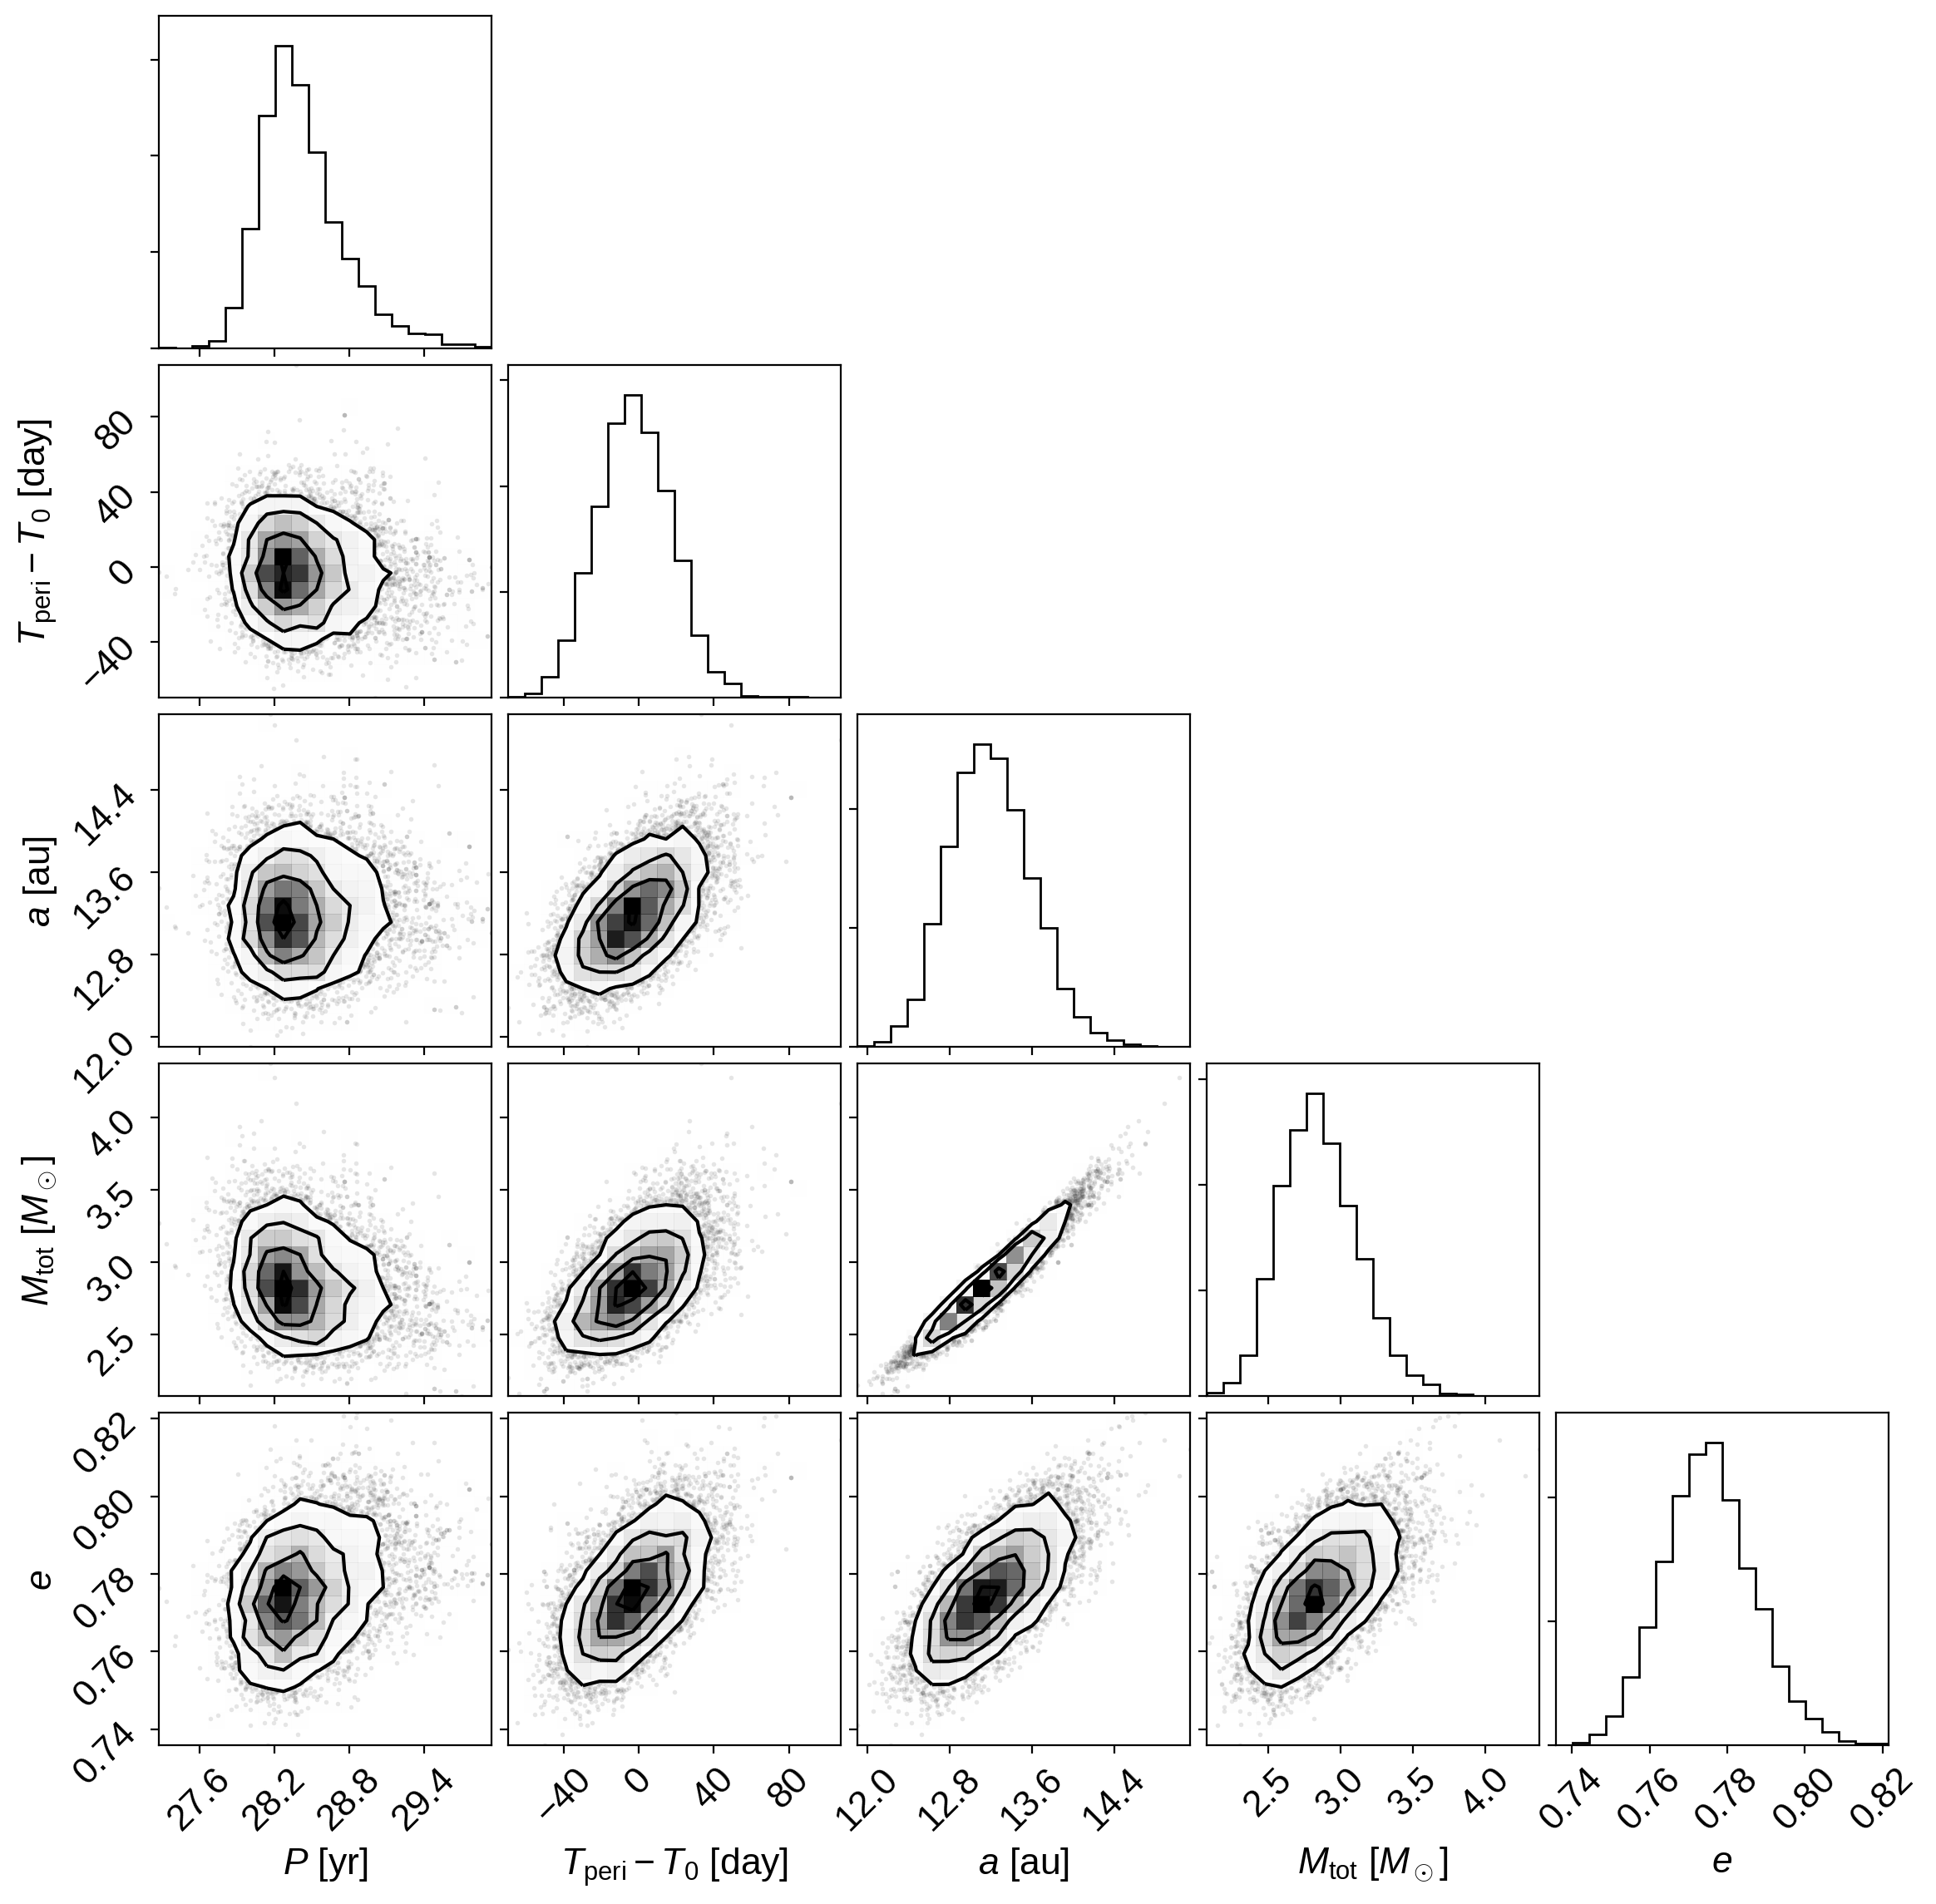

In [17]:
samples = pm.trace_to_dataframe(plx_trace, varnames=["ecc"])
samples["$P$ [yr]"] = plx_trace["P"] / yr
samples["$T_\mathrm{peri} - T_0$ [day]"] = plx_trace["tperi"] - T0
samples["$a$ [au]"] = plx_trace["a"]
samples["$M_\mathrm{tot}$ [$M_\odot$]"] = plx_trace["M_tot"]
samples["$e$"] = plx_trace["ecc"]
del samples["ecc"]
_ = corner.corner(samples)

## Citations

As described in the :ref:`citation` tutorial, we can use :func:`exoplanet.citations.get_citations_for_model` to construct an acknowledgement and BibTeX listing that includes the relevant citations for this model.

In [18]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:exoplanet, exoplanet:pymc3, exoplanet:theano}.


In [19]:
print("\n".join(bib.splitlines()[:10]) + "\n...")


@misc{exoplanet:exoplanet,
  author = {Daniel Foreman-Mackey and Ian Czekala and Rodrigo Luger and
            Eric Agol and Geert Barentsen and Tom Barclay},
   title = {exoplanet-dev/exoplanet v0.3.0},
   month = apr,
    year = 2020,
     doi = {10.5281/zenodo.1998447},
     url = {https://doi.org/10.5281/zenodo.1998447}
}
...
